In [1]:
import ROOT as r
import numpy as np
import matplotlib.pyplot as plt
import math
from ROOT import RooFit
from ROOT import TChain
from ROOT import RooStats
from datetime import datetime
from uncertainties import ufloat
from scipy.optimize import curve_fit

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# %jsroot on

c = r.TCanvas()

# Functions

# Monte Carlo mass fits

## Monte Carlo mass fit, $B^+ \rightarrow \bar{D}^0\pi^+$

In [ ]:
from IPython.display import display

trees = []

file_arrays = [
    "00265767_*_1.highmult_2024-Friend-B2CC-W3134-UP.root",
    "00265769_*_1.highmult_2024-Friend-B2CC-W3739-DOWN.root",
    "00265771_*_1.highmult_2024-Friend-B2CC-W4042-UP.root",
    "00265773_*_1.highmult_2024-Friend-B2CC-W35I37-UP.root",
    "00265775_*_1.highmult_2024-Friend-B2CC-W4042-DOWN.root",
    "00266897_*_1.highmult_2024-Friend-B2OC-W4042-DOWN.root",
    "00266897_*_1.highmult_2024-Friend-B2OC-W4042-DOWN.root",
]

try:
    for i, file_path in enumerate(file_arrays):
        if "B2CC" in file_arrays[i]:
            trees.append(TChain("ST-b2cc"))
        else:
            trees.append(TChain("ST-b2oc"))
        trees[-1].Add(file_path)
except Exception as e:
    print(f"Error loading files: {e}")

2

In [2]:
# import the data
tree = TChain("ST-b2oc")
tree.Add("00266897_0000000*_1.highmult_2024-Friend-B2OC-W4042-DOWN.root") # path to MC data

# plotting the mass
# tree.Draw("Bp_DTF_OwnPV_MASS", "Bp_DTF_OwnPV_MASS < 5950", "logy")
# c.Draw()

2

In [ ]:
c = r.TCanvas()
trees[0].Draw("Bp_DTF_OwnPV_MASS", "Bp_DTF_OwnPV_MASS < 5950", "logy")
c.Draw()

In [ ]:
# Printing all the variables that are available in the tree
tree.Print()

In [4]:
# create a RooRealVar for the observable to fit
# In simple language, this line creates a variable `x` that represents the mass of the B+ meson in the dataset.
# So, RooRealVar is a way to define a variable in the RooFit framework that can be used for fitting and analysis.
# create a RooRealVar for the observable to fit
r.EnableImplicitMT()  # Enable multithreading for faster processing
x = r.RooRealVar("Bp_DTF_OwnPV_MASS", "Bp_DTF_OwnPV_MASS", 4900, 5950)

# convert the data to RooDataSet
# This line creates a RooDataSet named "data" from the TChain `tree`, using the variable `x` as the observable.
# Arguments of this function are in order with explanation:
# 1. Name of the dataset
# 2. Title of the dataset
# 3. Set of observables (in this case, just `x`). This means that the dataset will contain values for the variable `x`.
# 4. Import the data from the TChain `tree`. This means that the data from the ROOT tree will be used to fill the dataset.
data = r.RooDataSet("data", "dataset from tree", r.RooArgSet(x), r.RooFit.Import(tree))

# create the pdfs
# How this code works is that it defines the probability density functions (PDFs) for the mass distribution of B+ mesons.
# These 4 lines below create the variables needed for the Crystal Ball function.
# They use RooRealVar which defines a variable as the name, title, initial value, and range.
mean = r.RooRealVar("mean", "mean", 5278.46, 5250, 5300) # TThe literature value of mass of B+ meson, as searched in the google is 5279.34.
alpha = r.RooRealVar("alpha", "alpha", 1.25015, 1, 2)
# n here is a parameter that controls the shape of the tail of the distribution.
n = r.RooRealVar("n", "n", 2.40748, 0.5, 5)
cb_sigma = r.RooRealVar("cb_sigma", "cb_sigma", 25.7691, 20, 30)

# This line creates a Crystal Ball PDF, which is a type of probability distribution function used to model the mass distribution of B+ mesons.
# Argunments and how it works: (1) Name of the PDF, (2) Title of the PDF, (3) Observable variable `x`, (4) Mean of the distribution, (5) Sigma of the distribution, (6) Alpha parameter, and (7) n parameter.
crystal_ball = r.RooCBShape("crystal_ball", "Crystal ball PDF", x, mean, cb_sigma, alpha, n)

tau = r.RooRealVar("tau", "Decay constant", -0.00219122, -1, 0) 

# This line creates an exponential background PDF. x here is the observable variable, and tau is the decay constant.
background = r.RooExponential("background", "Exponential background", x, tau)

# create the second crystal ball pdf, with new alpha, n, and sigma values, while keeping the same mean, which is because the mass peak is the same.
alpha_2 = r.RooRealVar("alpha2", "alpha2", -2.2701, -20, -0.01)
n_2 = r.RooRealVar("n2", "n2", 2.47972, 0.05, 50)
cb_sigma_2 = r.RooRealVar("cb_sigma2", "cb_sigma2", 12.7184, 5, 20)
crystal_ball_2 = r.RooCBShape("crystal_ball2", "Crystal ball PDF 2", x, mean, cb_sigma_2, alpha_2, n_2)

# combine the pdfs
frac_cb_2 = r.RooRealVar("frac_cb_2", "Fraction of crystal ball 2", 0.5, 0.0, 1.0)
frac_background = r.RooRealVar("frac_background", "Fraction of background", 0.2, 0.05, 0.25)

#
frac_cb = r.RooFormulaVar("frac_cb", "1-frac_cb_2-frac_background", "1-@0-@1", r.RooArgList(frac_cb_2, frac_background))
combined_pdf = r.RooAddPdf("combined_pdf", "Gaussian + crystal ball + background",
                           r.RooArgList(crystal_ball_2, crystal_ball, background),
                           r.RooArgList(frac_cb_2, frac_cb, frac_background))

# lock variables
# Deep and detailed explanation of what these lines do:
# The following lines set certain parameters to be constant during the fitting process.
# This means that their values will not change when the fitting algorithm tries to find the best fit.
# Why mean is not changing? Because the mean of the mass peak is a known value from literature, and we want to keep it fixed during the fit.
# This is done to ensure that the fit focuses on adjusting the other parameters that are more uncertain.
# But the problem is that the mean of the mass peak is not exactly the same as the literature value, so we need to adjust it slightly.
mean.setConstant(False)
alpha.setConstant(False)
n.setConstant(False)
cb_sigma.setConstant(False)
tau.setConstant(False)
alpha_2.setConstant(False)
n_2.setConstant(False)
cb_sigma_2.setConstant(False)
frac_background.setConstant(False)
# So here we only let mean and tau to be constant, while the other parameters are allowed to vary during the fit. We should explore what's the effect of letting everything change on the fit result.

# fit to the data and plot
# This line fits the combined PDF to the data using the RooFit framework.
# The first argument is the dataset to fit, and the second argument sets the print level to 1, which means it will print some information about the fitting process. 
# The more detail of second argument is that it will print the fitting status, the number of iterations, and the final parameter values.
# If we don't provide the second argument, it will use the default print level, which is usually 0 (no output).
combined_pdf.fitTo(data, RooFit.PrintLevel(1))

# Below line, creates a frame for plotting the fit results. Here x is the observable variable, and the title describes the fit being performed.
frame = x.frame(RooFit.Title("2 crystal ball fit, B^{+} #rightarrow #bar{D}^{0}#pi^{+} Monte Carlo B^{+} mass"))

data.plotOn(frame)
combined_pdf.plotOn(frame)
combined_pdf.plotOn(frame, RooFit.Components(crystal_ball), RooFit.LineStyle(r.kDashed))
combined_pdf.plotOn(frame, RooFit.Components(crystal_ball_2), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kRed))
combined_pdf.plotOn(frame, RooFit.Components(background), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kGreen))

# This line creates a canvas to draw the frame on, with a specified name, title, and size.
canvas = r.TCanvas("canvas", "2 crystal ball fit", 800, 600)
frame.Draw() # This line draws the frame on the canvas.
canvas.SetLogy() # This line sets the y-axis to a logarithmic scale, which is useful for visualizing data that spans several orders of magnitude.
frame.GetXaxis().SetTitle("Mass (MeV/c^{2})") 
frame.SetMinimum(0.3) # This line sets the minimum value of the y-axis to 0.3, which helps to avoid cluttering the plot with very small values.
canvas.Draw()

[#1] INFO:DataHandling -- RooAbsReal::attachToTree(Bp_DTF_OwnPV_MASS) TTree Float_t branch Bp_DTF_OwnPV_MASS will be converted to double precision.
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data) Skipping event #1863 because Bp_DTF_OwnPV_MASS cannot accommodate the value 4871.36
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data) Skipping event #3106 because Bp_DTF_OwnPV_MASS cannot accommodate the value 4898.38
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data) Skipping event #4688 because Bp_DTF_OwnPV_MASS cannot accommodate the value 4888.02
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data) Skipping event #4793 because Bp_DTF_OwnPV_MASS cannot accommodate the value 6096.33
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data) Skipping ...
[#0] WARNING:DataHandling -- RooTreeDataStore::loadValues(data) Ignored 84 out-of-range events
[#1] INFO:Minimization -- p.d.f. provides expected number of events, including extended term in likelih

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       322119.2879 Edm =       13347665.27 NCalls =     49
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 312481.8469
  Edm           : 3934.739218
  Internal parameters:	[    -0.5232524001     0.8849399212     -1.570541384    0.02912411707     -1.560429764                0     0.1388456842    -0.1528253039     -1.126036245      1.477141165]	
  Internal gradient  :	[     -1636.909225      2988.718343     0.3965548185      2800.587857      43.67221942     -4756.022572     -1050.573437     -1757.638196     -1241.091848      1298.361002]	
  Internal covariance matrix:
[[   0.0020335767              0              0              0              0              0              0              0              0  

In [ ]:
print(x, mean, cb_sigma, alpha, n, tau, alpha_2, n_2, cb_sigma_2, frac_cb_2, frac_background)

RooRealVar::Bp_DTF_OwnPV_MASS = 5425  L(4900 - 5950) 
 RooRealVar::mean = 5278.46 C  L(5250 - 5300) 
 RooRealVar::cb_sigma = 20 +/- 7.53533  L(20 - 30) 
 RooRealVar::alpha = 1.2431 +/- 0.108969  L(1 - 2) 
 RooRealVar::n = 2.14184 +/- 0.254885  L(0.5 - 5) 
 RooRealVar::tau = -0.00219122 C  L(-1 - 0) 
 RooRealVar::alpha2 = -2.2701 +/- 0.332413  L(-20 - -0.01) 
 RooRealVar::n2 = 2.47972 +/- 0.922778  L(0.05 - 50) 
 RooRealVar::cb_sigma2 = 12.6922 +/- 0.154665  L(5 - 20) 
 RooRealVar::frac_cb_2 = 0.74373 +/- 0.00156394  L(0 - 1) 
 RooRealVar::frac_background = 0.25 +/- 0.000212901  L(0.15 - 0.25) 



## Monte Carlo mass fit,  $B^+ \rightarrow J/\psi K^+$

In [2]:
# import the data
tree = TChain("ST-b2cc")
tree.Add("00265775_0000000*_1.highmult_2024-Friend-B2CC-W4042-DOWN.root") # path to MC data

# plotting the mass
# tree.Draw("Bp_DTF_OwnPV_MASS", "Bp_DTF_OwnPV_MASS < 5750", "logy")
# c.Draw()

6

In [ ]:
# create a RooRealVar for the observable to fit
x = r.RooRealVar("Bp_DTF_OwnPV_MASS", "Bp_DTF_OwnPV_MASS", 5050, 5550)

# convert the data to RooDataSet
data = r.RooDataSet("data", "dataset from tree", r.RooArgSet(x), r.RootFit.Import(tree) )

# create the pdfs (2 crystal balls)
mean = r.RooRealVar("mean", "mean", 5279.38, 5250, 5300)

tau = r.RooRealVar("tau", "Decay constant", -0.00107319, -1, 0)
background = r.RooExponential("background", "Exponential background", x, tau)

alpha_1 = r.RooRealVar("alpha", "alpha", 1.59501, 0.1, 2)
n_1 = r.RooRealVar("n", "n", 2.75673, 0.5, 5)
cb_sigma_1 = r.RooRealVar("cb_sigma", "cb_sigma", 7.2753, 5, 10)
crystal_ball = r.RooCBShape("crystal_ball", "Crystal ball PDF", x, mean, cb_sigma_1, alpha_1, n_1)

alpha_2 = r.RooRealVar("alpha2", "alpha2", -1.29179, -1.5, -0.1)
n_2 = r.RooRealVar("n2", "n2", 5.29, 0.5, 10)
cb_sigma_2 = r.RooRealVar("cb_sigma2", "cb_sigma2", 8.21279, 5, 10)
crystal_ball_2 = r.RooCBShape("crystal_ball2", "Crystal ball PDF 2", x, mean, cb_sigma_2, alpha_2, n_2)

# combine the pdfs and fit the data
frac_cb_2 = r.RooRealVar("frac_cb_2", "Fraction of crystal ball 2", 0.5, 0.0, 1.0)
frac_background = r.RooRealVar("frac_background", "Fraction of background", 0.2, 0.0, 1.0)
combined_pdf = r.RooAddPdf("combined_pdf", "Gaussian + crystal ball + background",
                           r.RooArgList(crystal_ball_2, crystal_ball, background),
                           r.RooArgList(frac_cb_2, frac_background))

mean.setConstant(True)
tau.setConstant(True)
alpha_1.setConstant(True)
n_1.setConstant(True)
cb_sigma_1.setConstant(True)
alpha_2.setConstant(True)
n_2.setConstant(True)
cb_sigma_2.setConstant(True)

combined_pdf.fitTo(data, RooFit.PrintLevel(1))

# plot it
frame = x.frame(RooFit.Title("2 crystal ball fit, B^{+} #rightarrow J/#psiK^{+} Monte Carlo B^{+} mass"))
data.plotOn(frame)
combined_pdf.plotOn(frame)
combined_pdf.plotOn(frame, RooFit.Components(crystal_ball), RooFit.LineStyle(r.kDashed))
combined_pdf.plotOn(frame, RooFit.Components(crystal_ball_2), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kRed))
combined_pdf.plotOn(frame, RooFit.Components(background), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kGreen))

canvas = r.TCanvas("canvas", "2x crystal ball fit", 800, 600)
frame.Draw()
canvas.SetLogy()
frame.SetMinimum(100)
frame.GetXaxis().SetTitle("Mass (MeV/c^{2})")
canvas.Draw()

TypeError: none of the 5 overloaded methods succeeded. Full details:
  RooDataSet::RooDataSet(RooStringView name, RooStringView title, const RooArgSet& vars, const RooCmdArg& arg1 = {}, const RooCmdArg& arg2 = {}, const RooCmdArg& arg3 = {}, const RooCmdArg& arg4 = {}, const RooCmdArg& arg5 = {}, const RooCmdArg& arg6 = {}, const RooCmdArg& arg7 = {}, const RooCmdArg& arg8 = {}) =>
    TypeError: could not convert argument 1
  RooDataSet::RooDataSet(RooStringView name, RooStringView title, RooDataSet* data, const RooArgSet& vars, const RooFormulaVar& cutVar, const char* wgtVarName = nullptr) =>
    TypeError: takes at least 5 arguments (4 given)
  RooDataSet::RooDataSet(RooStringView name, RooStringView title, RooDataSet* data, const RooArgSet& vars, const char* cuts = nullptr, const char* wgtVarName = nullptr) =>
    TypeError: could not convert argument 1
  RooDataSet::RooDataSet(const RooDataSet& other, const char* newname = nullptr) =>
    TypeError: takes at most 2 arguments (4 given)
  RooDataSet::RooDataSet() =>
    TypeError: takes at most 0 arguments (4 given)

In [ ]:
print(x, mean, cb_sigma_1, alpha_1, n_1, cb_sigma_2, alpha_2, n_2, tau, frac_cb_2, frac_background)

RooRealVar::Bp_DTF_OwnPV_MASS = 5275  L(5050 - 5500) 
 RooRealVar::mean = 5279.38 C  L(5250 - 5300) 
 RooRealVar::cb_sigma = 7.2753 C  L(5 - 10) 
 RooRealVar::alpha = 1.59501 C  L(0.1 - 2) 
 RooRealVar::n = 2.75673 C  L(0.5 - 5) 
 RooRealVar::cb_sigma2 = 8.21279 C  L(5 - 10) 
 RooRealVar::alpha2 = -1.29179 C  L(-1.5 - -0.1) 
 RooRealVar::n2 = 5.29 C  L(0.5 - 10) 
 RooRealVar::tau = -0.00107319 C  L(-1 - 0) 
 RooRealVar::frac_cb_2 = 0.403208 +/- 0.00207894  L(0 - 1) 
 RooRealVar::frac_background = 0.562514 +/- 0.00208014  L(0 - 1) 



# Time binned mass, $B^+ \rightarrow \bar{D}^0\pi^+$

## Up

In [ ]:
# import the data
tree_mdpi_up = TChain("ST-b2oc")
tree_mdpi_up.Add("more_more_data/combined/0028*_1.highstats-Small-B2OC-UP.root") # path to data

4

In [ ]:
# create a RooRealVar for the observable to fit
x = r.RooRealVar("Bp_M", "Bp_M", 5200, 5950)

# this to have time in the dataset for later
min_time_dpi_up = tree_mdpi_up.GetMinimum("GPSTIME")
max_time_dpi_up = tree_mdpi_up.GetMaximum("GPSTIME")
print(min_time_dpi_up, max_time_dpi_up)
print(datetime.fromtimestamp(min_time_dpi_up / 1e6), datetime.fromtimestamp(max_time_dpi_up / 1e6))
time = r.RooRealVar("GPSTIME", "GPSTIME", min_time_dpi_up, max_time_dpi_up)
block = r.RooRealVar("block", "block", 1, 8)

# convert the data to RooDataSet
data_dpi_up = r.RooDataSet("data_dpi_up", "dataset from tree", tree_mdpi_up, r.RooArgSet(x, time, block))

1721300083015680.0 1729076658176000.0
2024-07-18 12:54:43.015680 2024-10-16 13:04:18.176000
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(Bp_M) TTree Float_t branch Bp_M will be converted to double precision.
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(GPSTIME) TTree Float_t branch GPSTIME will be converted to double precision.
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(block) TTree Int_t branch block will be converted to double precision.
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data_dpi_up) Skipping event #1 because Bp_M cannot accommodate the value 5011.7
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data_dpi_up) Skipping event #2 because Bp_M cannot accommodate the value 5151.94
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data_dpi_up) Skipping event #3 because Bp_M cannot accommodate the value 4850.51
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data_dpi_up) Skipping event #5 because Bp_M cannot accommodate the value 5

In [ ]:
data_dpi_up_b5 = data_dpi_up.reduce("block >= 5 && block < 6")
data_dpi_up_b8 = data_dpi_up.reduce("block >= 8 && block < 9")

[#1] INFO:InputArguments -- The formula block >= 5 && block < 6 claims to use the variables (Bp_M,GPSTIME,block) but only (block) seem to be in use.
  inputs:         block >= 5 && block < 6
[#1] INFO:InputArguments -- The formula block >= 8 && block < 9 claims to use the variables (Bp_M,GPSTIME,block) but only (block) seem to be in use.
  inputs:         block >= 8 && block < 9


In [ ]:
print(data_dpi_up_b5.numEntries())
print(data_dpi_up_b8.numEntries())

6427801
3125867


### Plots

In [ ]:
c = r.TCanvas()

tree_mdpi_up.Draw("block >> histblock(8, 1, 9)")

c.Draw()

In [ ]:
c = r.TCanvas()

tree_mdpi_up.Draw("Bp_M >> histmass(100, 4875, 5900)")

hist = r.gPad.GetPrimitive("histmass")

hist.GetXaxis().SetTitle("Mass (MeV/c^{2})")
hist.GetYaxis().SetTitle("Events")
hist.SetTitle(f"B^{{+}} mass, B^{{+}} #rightarrow #bar{{D}}^{{0}}#pi^{{+}}")

hist.SetStats(False)

r.gPad.Update()

c.Draw()

### Block 5

In [ ]:
# extract and sort all the times
n_entries = data_dpi_up_b5.numEntries()
times_dpi_up_b5 = np.empty(n_entries, dtype=np.float64)

for i in range(n_entries):
    values = data_dpi_up_b5.get(i)
    times_dpi_up_b5[i] = values.getRealValue("GPSTIME")

times_dpi_up_b5.sort()

# define bin edges
n_bins = 10
time_bins_up_b5 = np.quantile(times_dpi_up_b5, np.linspace(0, 1, n_bins+1))

print(time_bins_up_b5)

[1.72468358e+15 1.72496356e+15 1.72507375e+15 1.72516837e+15
 1.72540379e+15 1.72548902e+15 1.72560377e+15 1.72569920e+15
 1.72580953e+15 1.72591664e+15 1.72601341e+15]


In [ ]:
signal_yields_dpi_up_b5 = np.empty(10, dtype=object)

background_yields_dpi_up_b5 = np.empty(10, dtype=object)

In [ ]:
for i in range(n_bins):
    time_min = time_bins_up_b5[i]
    time_max = time_bins_up_b5[i+1]

    # define the cut string for this time bin
    cut_str = f"GPSTIME >= {time_min} && GPSTIME < {time_max}"

    # create the binned dataset
    binned_data_dpi_up = data_dpi_up_b5.reduce(cut_str)

    print(f"Bin {i+1}: {time_min} - {time_max}, entries: {binned_data_dpi_up.numEntries()}")

    # create the pdfs
    mean = r.RooRealVar("mean", "mean", 5277.8, 5277, 5280)

    cb_sigma_oldg = r.RooRealVar("cb_sigma_oldg", "cb_sigma_oldg", 18.39, 15, 25)
    alpha_oldg = r.RooRealVar("alpha_oldg", "alpha_oldg", -1.42686, -2, -0.8)
    n_oldg = r.RooRealVar("n_oldg", "n_oldg", 19.9954, 10, 20)
    cb_oldg = r.RooCBShape("cb_oldg", "Second CB PDF", x, mean, cb_sigma_oldg, alpha_oldg, n_oldg)

    alpha = r.RooRealVar("alpha", "alpha", 0.6, 0.5, 1)
    n = r.RooRealVar("n", "n", 19.6699, 15, 25)
    cb_sigma = r.RooRealVar("cb_sigma", "cb_sigma", 24.7, 20, 50)
    crystal_ball = r.RooCBShape("crystal_ball", "Crystal ball PDF", x, mean, cb_sigma, alpha, n)

    tau = r.RooRealVar("tau", "Decay constant", -0.00051, -0.0006, 0)
    background = r.RooExponential("background", "Exponential background", x, tau)

    mean.setConstant(True)
    tau.setConstant(True)
    cb_sigma_oldg.setConstant(True)
    alpha_oldg.setConstant(True)
    n_oldg.setConstant(True)
    alpha.setConstant(True) #
    n.setConstant(True)
    cb_sigma.setConstant(True)

    # use yields instead of fractions
    ntot = r.RooRealVar("ntot", "total yield", binned_data_dpi_up.numEntries(), 0, data_dpi_up.numEntries() * 10)

#    ncb1 = r.RooRealVar("ncb1", "yield cb1", binned_data_dpi_up.numEntries() / 10, binned_data_dpi_up.numEntries() / 40, binned_data_dpi_up.numEntries())
#    ncb2 = r.RooRealVar("ncb2", "yield cb2", binned_data_dpi_up.numEntries() / 10, binned_data_dpi_up.numEntries() / 40, binned_data_dpi_up.numEntries())
    nsig = r.RooRealVar("nsig", "yield sig", binned_data_dpi_up.numEntries() * 0.15, binned_data_dpi_up.numEntries() * 0.12, binned_data_dpi_up.numEntries() * 0.4)
    nbkg = r.RooRealVar("nbkg", "yield bkg", binned_data_dpi_up.numEntries() * 0.85, binned_data_dpi_up.numEntries() * 0.6, binned_data_dpi_up.numEntries() * 0.88)
    f_cb1 = r.RooRealVar("f_cb1", "fraction of cb1", 0.6)

    # build the model and fit the data

    cb_sum = r.RooAddPdf("cb_sum", "signal pdf", r.RooArgList(cb_oldg, crystal_ball), r.RooArgList(f_cb1))

    combined_pdf_dpi_up_timebinned = r.RooAddPdf("combined_pdf", "2x crystal ball + background",
                               r.RooArgList(cb_sum, background),
                               r.RooArgList(nsig, nbkg))

    # fit the model
    fit_result = combined_pdf_dpi_up_timebinned.fitTo(binned_data_dpi_up,
                                                      #RooFit.Minos(True), # asymmetric uncertainties
                                                      #RooFit.Extended(True),
                                                      RooFit.Save(),
                                                      Strategy=2)

    print(x, mean, cb_sigma_oldg, alpha_oldg, n_oldg, cb_sigma, alpha, n, tau, ntot, nsig, nbkg)
    print(f"Background ratio: {nbkg.getVal() / ntot.getVal()}")
#    print(f"CB1/nsig ratio: {ncb1.getVal() / (ncb1.getVal() + ncb2.getVal())}")
    print(f"Status: {fit_result.status()}, CovQual: {fit_result.covQual()}")
    fit_result.Print()

    # extract the yield
    #nsig = r.RooAddition("nsig", "ncb1 + ncb2", r.RooArgList(ncb1, ncb2))

    #ncb1_err = ufloat(ncb1.getVal(), ncb1.getError())
    #ncb2_err = ufloat(ncb2.getVal(), ncb2.getError())

    #signal_yield = ncb1_err + ncb2_err

    signal_yield = ufloat(nsig.getVal(), nsig.getError())
    background_yield = ufloat(nbkg.getVal(), nbkg.getError())

    signal_yields_dpi_up_b5[i] = signal_yield
    background_yields_dpi_up_b5[i] = background_yield

    #frame = x.frame(RooFit.Title(f"Block 5 up Dpi, time bin {i+1}: {datetime.fromtimestamp(time_min / 1e6)} - {datetime.fromtimestamp(time_max / 1e6)}"))
    frame = x.frame(RooFit.Title(f"B^{{+}} mass fit, B^{{+}} #rightarrow #bar{{D}}^{{0}}#pi^{{+}}, block 5 (up), time bin {i+1}: {datetime.fromtimestamp(time_min / 1e6).date()} - {datetime.fromtimestamp(time_max / 1e6).date()}"))
    binned_data_dpi_up.plotOn(frame)
    combined_pdf_dpi_up_timebinned.plotOn(frame)
    combined_pdf_dpi_up_timebinned.plotOn(frame, RooFit.Components(crystal_ball), RooFit.LineStyle(r.kDashed))
    combined_pdf_dpi_up_timebinned.plotOn(frame, RooFit.Components(cb_oldg), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kRed))
    combined_pdf_dpi_up_timebinned.plotOn(frame, RooFit.Components(background), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kGreen))

    canvas = r.TCanvas(f"c_bin_{i+1}", f"Fit for time bin {i+1}", 800, 600)
    frame.GetXaxis().SetTitle("Mass (MeV/c^{2})")
    frame.Draw()
    frame.SetMinimum(0)
    frame.GetXaxis().SetRangeUser(5200, 5950)
    canvas.SaveAs(f"fulldata_b5_up_time_binned_dpi_fit_bin_{i+1}.png")
    frame.Draw()
    canvas.SetLogy()
    frame.SetMinimum(4000)
    canvas.SaveAs(f"fulldata_b5_up_time_binned_dpi_fit_bin_{i+1}_log.png")

    print(f"Yield for {datetime.fromtimestamp(time_min / 1e6)} - {datetime.fromtimestamp(time_max / 1e6)}: {signal_yield:.2f}\n\n")# ± {signal_error:.2f}")

print(f"All yields: {signal_yields_dpi_up_b5}")
print(f"Background yields: {background_yields_dpi_up_b5}")

Bin 1: 1724683577720832.0 - 1724963555901440.0, entries: 642206
RooRealVar::Bp_M = 5575  L(5200 - 5950) 
 RooRealVar::mean = 5277.8 C  L(5277 - 5280) 
 RooRealVar::cb_sigma_oldg = 18.39 C  L(15 - 25) 
 RooRealVar::alpha_oldg = -1.42686 C  L(-2 - -0.8) 
 RooRealVar::n_oldg = 19.9954 C  L(10 - 20) 
 RooRealVar::cb_sigma = 24.7 C  L(20 - 50) 
 RooRealVar::alpha = 0.6 C  L(0.5 - 1) 
 RooRealVar::n = 19.6699 C  L(15 - 25) 
 RooRealVar::tau = -0.00051 C  L(-0.0006 - 0) 
 RooRealVar::ntot = 642206  L(0 - 2.09768e+08) 
 RooRealVar::nsig = 97158.3 +/- 440.886  L(77064.7 - 256882) 
 RooRealVar::nbkg = 545046 +/- 801.392  L(385324 - 565141) 

Background ratio: 0.84870850053955
Status: 0, CovQual: 3
Yield for 2024-08-26 16:46:17.720832 - 2024-08-29 22:32:35.901440: 97158.35+/-440.89


Bin 2: 1724963555901440.0 - 1725073748656128.0, entries: 642048
RooRealVar::Bp_M = 5575  L(5200 - 5950) 
 RooRealVar::mean = 5277.8 C  L(5277 - 5280) 
 RooRealVar::cb_sigma_oldg = 18.39 C  L(15 - 25) 
 RooRealVar::al

Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_dpi_fit_bin_1.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_dpi_fit_bin_1_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_dpi_fit_bin_2.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_dpi_fit_bin_2_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_dpi_fit_bin_3.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_dpi_fit_bin_3_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_dpi_fit_bin_4.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_dpi_fit_bin_4_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_dpi_fit_bin_5.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_dpi_fit_bin_5_log.png has been created
Info in <T

In [ ]:
# compute sWeights if needed
# splot_dpi_up = RooStats.SPlot("splot_dpi_b5_up", "sPlot Dpi block 5 up", data_dpi_up_b5, combined_pdf_dpi_up_timebinned, r.RooArgList(nsig, nbkg))

In [ ]:
# print("sWeight branches:", [var.GetName() for var in data_dpi_up_b5.get() if var.GetName().endswith("_sw")])

### Block 8

In [ ]:
# extract and sort all the times
n_entries = data_dpi_up_b8.numEntries()
times_dpi_up_b8 = np.empty(n_entries, dtype=np.float64)

for i in range(n_entries):
    values = data_dpi_up_b8.get(i)
    times_dpi_up_b8[i] = values.getRealValue("GPSTIME")

times_dpi_up_b8.sort()

# define bin edges
n_bins = 10
time_bins_up_b8 = np.quantile(times_dpi_up_b8, np.linspace(0, 1, n_bins+1))

print(time_bins_up_b8)

[1.72854422e+15 1.72870045e+15 1.72872219e+15 1.72875668e+15
 1.72877977e+15 1.72885413e+15 1.72887694e+15 1.72897224e+15
 1.72899532e+15 1.72904579e+15 1.72907666e+15]


In [ ]:
signal_yields_dpi_up_b8 = np.empty(10, dtype=object)

background_yields_dpi_up_b8 = np.empty(10, dtype=object)

In [ ]:
for i in range(n_bins):
    time_min = time_bins_up_b8[i]
    time_max = time_bins_up_b8[i+1]

    # define the cut string for this time bin
    cut_str = f"GPSTIME >= {time_min} && GPSTIME < {time_max}"

    # create the binned dataset
    binned_data_dpi_up = data_dpi_up_b8.reduce(cut_str)

    print(f"Bin {i+1}: {time_min} - {time_max}, entries: {binned_data_dpi_up.numEntries()}")

    # create the pdfs
    mean = r.RooRealVar("mean", "mean", 5277.8, 5277, 5280)

    cb_sigma_oldg = r.RooRealVar("cb_sigma_oldg", "cb_sigma_oldg", 18.39, 15, 25)
    alpha_oldg = r.RooRealVar("alpha_oldg", "alpha_oldg", -1.42686, -2, -0.8)
    n_oldg = r.RooRealVar("n_oldg", "n_oldg", 19.9954, 10, 20)
    cb_oldg = r.RooCBShape("cb_oldg", "Second CB PDF", x, mean, cb_sigma_oldg, alpha_oldg, n_oldg)

    alpha = r.RooRealVar("alpha", "alpha", 0.618402, 0.4, 1)
    n = r.RooRealVar("n", "n", 5, 4, 15)
    cb_sigma = r.RooRealVar("cb_sigma", "cb_sigma", 24.7, 20, 50)
    crystal_ball = r.RooCBShape("crystal_ball", "Crystal ball PDF", x, mean, cb_sigma, alpha, n)

    tau = r.RooRealVar("tau", "Decay constant", -0.000395081, -0.0006, 0)
    background = r.RooExponential("background", "Exponential background", x, tau)

    mean.setConstant(True)
    tau.setConstant(True)
    cb_sigma_oldg.setConstant(True)
    alpha_oldg.setConstant(True)
    n_oldg.setConstant(True)
    alpha.setConstant(True) #
    n.setConstant(True)
    cb_sigma.setConstant(True)

    # use yields instead of fractions
    ntot = r.RooRealVar("ntot", "total yield", binned_data_dpi_up.numEntries(), 0, data_dpi_up.numEntries() * 10)

#    ncb1 = r.RooRealVar("ncb1", "yield cb1", binned_data_dpi_up.numEntries() / 10, binned_data_dpi_up.numEntries() / 40, binned_data_dpi_up.numEntries())
#    ncb2 = r.RooRealVar("ncb2", "yield cb2", binned_data_dpi_up.numEntries() / 10, binned_data_dpi_up.numEntries() / 40, binned_data_dpi_up.numEntries())
    nsig = r.RooRealVar("nsig", "yield sig", binned_data_dpi_up.numEntries() * 0.15, binned_data_dpi_up.numEntries() * 0.1, binned_data_dpi_up.numEntries() * 0.17)
    nbkg = r.RooRealVar("nbkg", "yield bkg", binned_data_dpi_up.numEntries() * 0.85, binned_data_dpi_up.numEntries() * 0.81, binned_data_dpi_up.numEntries() * 0.91)
    f_cb1 = r.RooRealVar("f_cb1", "fraction of cb1", 0.6)

    # build the model and fit the data

    cb_sum = r.RooAddPdf("cb_sum", "signal pdf", r.RooArgList(cb_oldg, crystal_ball), r.RooArgList(f_cb1))

    combined_pdf_dpi_up_timebinned = r.RooAddPdf("combined_pdf", "2x crystal ball + background",
                               r.RooArgList(cb_sum, background),
                               r.RooArgList(nsig, nbkg))

    # fit the model
    fit_result = combined_pdf_dpi_up_timebinned.fitTo(binned_data_dpi_up,
                                                      #RooFit.Minos(True), # asymmetric uncertainties
                                                      #RooFit.Extended(True),
                                                      RooFit.Save(),
                                                      Strategy=2)

    print(x, mean, cb_sigma_oldg, alpha_oldg, n_oldg, cb_sigma, alpha, n, tau, ntot, nsig, nbkg)
    print(f"Background ratio: {nbkg.getVal() / ntot.getVal()}")
#    print(f"CB1/nsig ratio: {ncb1.getVal() / (ncb1.getVal() + ncb2.getVal())}")
    print(f"Status: {fit_result.status()}, CovQual: {fit_result.covQual()}")
    fit_result.Print()

    # extract the yield
    #nsig = r.RooAddition("nsig", "ncb1 + ncb2", r.RooArgList(ncb1, ncb2))

    #ncb1_err = ufloat(ncb1.getVal(), ncb1.getError())
    #ncb2_err = ufloat(ncb2.getVal(), ncb2.getError())

    #signal_yield = ncb1_err + ncb2_err

    signal_yield = ufloat(nsig.getVal(), nsig.getError())
    background_yield = ufloat(nbkg.getVal(), nbkg.getError())

    signal_yields_dpi_up_b8[i] = signal_yield
    background_yields_dpi_up_b8[i] = background_yield

    frame = x.frame(RooFit.Title(f"B^{{+}} mass fit, B^{{+}} #rightarrow #bar{{D}}^{{0}}#pi^{{+}}, block 8 (up), time bin {i+1}: {datetime.fromtimestamp(time_min / 1e6).date()} - {datetime.fromtimestamp(time_max / 1e6).date()}"))
    binned_data_dpi_up.plotOn(frame)
    combined_pdf_dpi_up_timebinned.plotOn(frame)
    combined_pdf_dpi_up_timebinned.plotOn(frame, RooFit.Components(crystal_ball), RooFit.LineStyle(r.kDashed))
    combined_pdf_dpi_up_timebinned.plotOn(frame, RooFit.Components(cb_oldg), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kRed))
    combined_pdf_dpi_up_timebinned.plotOn(frame, RooFit.Components(background), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kGreen))

    canvas = r.TCanvas(f"c_bin_{i+1}", f"Fit for time bin {i+1}", 800, 600)
    frame.GetXaxis().SetTitle("Mass (MeV/c^{2})")
    frame.Draw()
    frame.SetMinimum(0)
    canvas.SaveAs(f"fulldata_b8_up_time_binned_dpi_fit_bin_{i+1}.png")
    frame.Draw()
    canvas.SetLogy()
    frame.SetMaximum(10001)
    frame.SetMinimum(2000)
    canvas.SaveAs(f"fulldata_b8_up_time_binned_dpi_fit_bin_{i+1}_log.png")

    print(f"Yield for {datetime.fromtimestamp(time_min / 1e6)} - {datetime.fromtimestamp(time_max / 1e6)}: {signal_yield:.2f}\n\n")# ± {signal_error:.2f}")

print(f"All yields: {signal_yields_dpi_up_b8}")
print(f"Background yields: {background_yields_dpi_up_b8}")

Bin 1: 1728544216449024.0 - 1728700445884416.0, entries: 311525
RooRealVar::Bp_M = 5575  L(5200 - 5950) 
 RooRealVar::mean = 5277.8 C  L(5277 - 5280) 
 RooRealVar::cb_sigma_oldg = 18.39 C  L(15 - 25) 
 RooRealVar::alpha_oldg = -1.42686 C  L(-2 - -0.8) 
 RooRealVar::n_oldg = 19.9954 C  L(10 - 20) 
 RooRealVar::cb_sigma = 24.7 C  L(20 - 50) 
 RooRealVar::alpha = 0.618402 C  L(0.4 - 1) 
 RooRealVar::n = 5 C  L(4 - 15) 
 RooRealVar::tau = -0.000395081 C  L(-0.0006 - 0) 
 RooRealVar::ntot = 311525  L(0 - 2.09768e+08) 
 RooRealVar::nsig = 36170.3 +/- 286.865  L(31152.5 - 52959.3) 
 RooRealVar::nbkg = 275353 +/- 566.819  L(252335 - 283488) 

Background ratio: 0.8838879120570671
Status: 0, CovQual: 3
Yield for 2024-10-10 09:10:16.449024 - 2024-10-12 04:34:05.884416: 36170.33+/-286.86


Bin 2: 1728700445884416.0 - 1728722189156352.0, entries: 312064
RooRealVar::Bp_M = 5575  L(5200 - 5950) 
 RooRealVar::mean = 5277.8 C  L(5277 - 5280) 
 RooRealVar::cb_sigma_oldg = 18.39 C  L(15 - 25) 
 RooRealVa

Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_dpi_fit_bin_1.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_dpi_fit_bin_1_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_dpi_fit_bin_2.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_dpi_fit_bin_2_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_dpi_fit_bin_3.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_dpi_fit_bin_3_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_dpi_fit_bin_4.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_dpi_fit_bin_4_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_dpi_fit_bin_5.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_dpi_fit_bin_5_log.png has been created
Info in <T

## Down

In [ ]:
# import the data
tree_mdpi_down = TChain("ST-b2oc")
tree_mdpi_down.Add("more_more_data/combined/0028*_1.highstats-Small-B2OC-DOWN.root") # path to data

3

In [ ]:
# create a RooRealVar for the observable to fit
x = r.RooRealVar("Bp_M", "Bp_M", 5200, 5950) # 5950

# this to have time in the dataset for later
min_time_dpi_down = tree_mdpi_down.GetMinimum("GPSTIME")
max_time_dpi_down = tree_mdpi_down.GetMaximum("GPSTIME")
print(min_time_dpi_down, max_time_dpi_down)
print(datetime.fromtimestamp(min_time_dpi_down / 1e6), datetime.fromtimestamp(max_time_dpi_down / 1e6))
time = r.RooRealVar("GPSTIME", "GPSTIME", min_time_dpi_down, max_time_dpi_down)
block = r.RooRealVar("block", "block", 1, 8)

# convert the data to RooDataSet
data_dpi_down = r.RooDataSet("data_dpi_up", "dataset from tree", tree_mdpi_down, r.RooArgSet(x, time, block))

1717516216827904.0 1728532271071232.0
2024-06-04 17:50:16.827904 2024-10-10 05:51:11.071232
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(Bp_M) TTree Float_t branch Bp_M will be converted to double precision.
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(GPSTIME) TTree Float_t branch GPSTIME will be converted to double precision.
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(block) TTree Int_t branch block will be converted to double precision.
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data_dpi_up) Skipping event #0 because Bp_M cannot accommodate the value 4943.75
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data_dpi_up) Skipping event #1 because block cannot accommodate the value 0
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data_dpi_up) Skipping event #2 because block cannot accommodate the value 0
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data_dpi_up) Skipping event #3 because Bp_M cannot accommodate the value 5965.83
[#

In [ ]:
data_dpi_down_b6 = data_dpi_down.reduce("block >= 6 && block < 7")
data_dpi_down_b7 = data_dpi_down.reduce("block >= 7 && block < 8")

[#1] INFO:InputArguments -- The formula block >= 6 && block < 7 claims to use the variables (Bp_M,GPSTIME,block) but only (block) seem to be in use.
  inputs:         block >= 6 && block < 7
[#1] INFO:InputArguments -- The formula block >= 7 && block < 8 claims to use the variables (Bp_M,GPSTIME,block) but only (block) seem to be in use.
  inputs:         block >= 7 && block < 8


In [ ]:
print(data_dpi_down_b6.numEntries())
print(data_dpi_down_b7.numEntries())

5224346
4999957


### Block 6

In [ ]:
# extract and sort all the times
n_entries = data_dpi_down_b6.numEntries()
times_dpi_down_b6 = np.empty(n_entries, dtype=np.float64)

for i in range(n_entries):
    values = data_dpi_down_b6.get(i)
    times_dpi_down_b6[i] = values.getRealValue("GPSTIME")

times_dpi_down_b6.sort()

# define bin edges
n_bins = 10
time_bins_down_b6 = np.quantile(times_dpi_down_b6, np.linspace(0, 1, n_bins+1))

print(time_bins_down_b6)

[1.72606562e+15 1.72615944e+15 1.72628090e+15 1.72636304e+15
 1.72644223e+15 1.72654088e+15 1.72662826e+15 1.72671617e+15
 1.72685106e+15 1.72692609e+15 1.72706366e+15]


In [ ]:
signal_yields_dpi_down_b6 = np.empty(10, dtype=object)

background_yields_dpi_down_b6 = np.empty(10, dtype=object)

In [ ]:
for i in range(n_bins):
    time_min = time_bins_down_b6[i]
    time_max = time_bins_down_b6[i+1]

    # define the cut string for this time bin
    cut_str = f"GPSTIME >= {time_min} && GPSTIME < {time_max}"

    # create the binned dataset
    binned_data_dpi_down = data_dpi_down_b6.reduce(cut_str)

    print(f"Bin {i+1}: {time_min} - {time_max}, entries: {binned_data_dpi_down.numEntries()}")

    # create the pdfs
    mean = r.RooRealVar("mean", "mean", 5277.8, 5277, 5280)

    cb_sigma_oldg = r.RooRealVar("cb_sigma_oldg", "cb_sigma_oldg", 18.39, 15, 25)
    alpha_oldg = r.RooRealVar("alpha_oldg", "alpha_oldg", -1.42686, -2, -0.8)
    n_oldg = r.RooRealVar("n_oldg", "n_oldg", 19.9954, 10, 20)
    cb_oldg = r.RooCBShape("cb_oldg", "Second CB PDF", x, mean, cb_sigma_oldg, alpha_oldg, n_oldg)

    alpha = r.RooRealVar("alpha", "alpha", 0.6, 0.4, 1)
    n = r.RooRealVar("n", "n", 19.6699, 15, 25)
    cb_sigma = r.RooRealVar("cb_sigma", "cb_sigma", 24.7, 20, 50)
    crystal_ball = r.RooCBShape("crystal_ball", "Crystal ball PDF", x, mean, cb_sigma, alpha, n)

    tau = r.RooRealVar("tau", "Decay constant", -0.00051, -0.0006, 0)
    background = r.RooExponential("background", "Exponential background", x, tau)

    mean.setConstant(True)
    tau.setConstant(True)
    cb_sigma_oldg.setConstant(True)
    alpha_oldg.setConstant(True)
    n_oldg.setConstant(True)
    alpha.setConstant(True) #
    n.setConstant(True)
    cb_sigma.setConstant(True)

    # use yields instead of fractions
    ntot = r.RooRealVar("ntot", "total yield", binned_data_dpi_down.numEntries(), 0, data_dpi_down.numEntries() * 10)

    nsig = r.RooRealVar("nsig", "yield sig", binned_data_dpi_down.numEntries() * 0.15, binned_data_dpi_down.numEntries() * 0.12, binned_data_dpi_down.numEntries() * 0.2)
    nbkg = r.RooRealVar("nbkg", "yield bkg", binned_data_dpi_down.numEntries() * 0.85, binned_data_dpi_down.numEntries() * 0.81, binned_data_dpi_down.numEntries() * 0.88)
    f_cb1 = r.RooRealVar("f_cb1", "fraction of cb1", 0.6)

    # build the model and fit the data

    cb_sum = r.RooAddPdf("cb_sum", "signal pdf", r.RooArgList(cb_oldg, crystal_ball), r.RooArgList(f_cb1))

    combined_pdf_dpi_down_timebinned = r.RooAddPdf("combined_pdf", "2x crystal ball + background",
                               r.RooArgList(cb_sum, background),
                               r.RooArgList(nsig, nbkg))

    # fit the model
    fit_result = combined_pdf_dpi_down_timebinned.fitTo(binned_data_dpi_down,
                                                      #RooFit.Minos(True), # asymmetric uncertainties
                                                      #RooFit.Extended(True),
                                                      RooFit.Save(),
                                                      Strategy=2)

    print(x, mean, cb_sigma_oldg, alpha_oldg, n_oldg, cb_sigma, alpha, n, tau, ntot, nsig, nbkg)
    print(f"Background ratio: {nbkg.getVal() / ntot.getVal()}")
#    print(f"CB1/nsig ratio: {ncb1.getVal() / (ncb1.getVal() + ncb2.getVal())}")
    print(f"Status: {fit_result.status()}, CovQual: {fit_result.covQual()}")
    fit_result.Print()

    signal_yield = ufloat(nsig.getVal(), nsig.getError())
    background_yield = ufloat(nbkg.getVal(), nbkg.getError())

    signal_yields_dpi_down_b6[i] = signal_yield
    background_yields_dpi_down_b6[i] = background_yield

    frame = x.frame(RooFit.Title(f"B^{{+}} mass fit, B^{{+}} #rightarrow #bar{{D}}^{{0}}#pi^{{+}}, block 6 (down), time bin {i+1}: {datetime.fromtimestamp(time_min / 1e6).date()} - {datetime.fromtimestamp(time_max / 1e6).date()}"))
    binned_data_dpi_down.plotOn(frame)
    combined_pdf_dpi_down_timebinned.plotOn(frame)
    combined_pdf_dpi_down_timebinned.plotOn(frame, RooFit.Components(crystal_ball), RooFit.LineStyle(r.kDashed))
    combined_pdf_dpi_down_timebinned.plotOn(frame, RooFit.Components(cb_oldg), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kRed))
    combined_pdf_dpi_down_timebinned.plotOn(frame, RooFit.Components(background), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kGreen))

    canvas = r.TCanvas(f"c_bin_{i+1}", f"Fit for time bin {i+1}", 800, 600)
    frame.GetXaxis().SetTitle("Mass (MeV/c^{2})")
    frame.Draw()
    frame.SetMinimum(0)
    canvas.SaveAs(f"fulldata_b6_down_time_binned_dpi_fit_bin_{i+1}.png")
    frame.Draw()
    canvas.SetLogy()
    frame.SetMinimum(3000)
    canvas.SaveAs(f"fulldata_b6_down_time_binned_dpi_fit_bin_{i+1}_log.png")

    print(f"Yield for {datetime.fromtimestamp(time_min / 1e6)} - {datetime.fromtimestamp(time_max / 1e6)}: {signal_yield:.2f}\n\n")# ± {signal_error:.2f}")

print(f"All yields: {signal_yields_dpi_down_b6}")
print(f"Background yields: {background_yields_dpi_down_b6}")

Bin 1: 1726065617666048.0 - 1726159435857920.0, entries: 521925
RooRealVar::Bp_M = 5575  L(5200 - 5950) 
 RooRealVar::mean = 5277.8 C  L(5277 - 5280) 
 RooRealVar::cb_sigma_oldg = 18.39 C  L(15 - 25) 
 RooRealVar::alpha_oldg = -1.42686 C  L(-2 - -0.8) 
 RooRealVar::n_oldg = 19.9954 C  L(10 - 20) 
 RooRealVar::cb_sigma = 24.7 C  L(20 - 50) 
 RooRealVar::alpha = 0.6 C  L(0.4 - 1) 
 RooRealVar::n = 19.6699 C  L(15 - 25) 
 RooRealVar::tau = -0.00051 C  L(-0.0006 - 0) 
 RooRealVar::ntot = 521925  L(0 - 1.31883e+08) 
 RooRealVar::nsig = 81038.1 +/- 399.897  L(62631 - 104385) 
 RooRealVar::nbkg = 440885 +/- 720.769  L(422759 - 459294) 

Background ratio: 0.8447294973439767
Status: 0, CovQual: 3
Yield for 2024-09-11 16:40:17.666048 - 2024-09-12 18:43:55.857920: 81038.08+/-399.90


Bin 2: 1726159435857920.0 - 1726280902901760.0, entries: 522622
RooRealVar::Bp_M = 5575  L(5200 - 5950) 
 RooRealVar::mean = 5277.8 C  L(5277 - 5280) 
 RooRealVar::cb_sigma_oldg = 18.39 C  L(15 - 25) 
 RooRealVar::al

Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_dpi_fit_bin_1.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_dpi_fit_bin_1_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_dpi_fit_bin_2.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_dpi_fit_bin_2_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_dpi_fit_bin_3.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_dpi_fit_bin_3_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_dpi_fit_bin_4.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_dpi_fit_bin_4_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_dpi_fit_bin_5.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_dpi_fit_bin_5_log.png has bee

### Block 7

In [ ]:
# extract and sort all the times
n_entries = data_dpi_down_b7.numEntries()
times_dpi_down_b7 = np.empty(n_entries, dtype=np.float64)

for i in range(n_entries):
    values = data_dpi_down_b7.get(i)
    times_dpi_down_b7[i] = values.getRealValue("GPSTIME")

times_dpi_down_b7.sort()

# define bin edges
n_bins = 10
time_bins_down_b7 = np.quantile(times_dpi_down_b7, np.linspace(0, 1, n_bins+1))

print(time_bins_down_b7)

[1.72797688e+15 1.72805271e+15 1.72809043e+15 1.72815042e+15
 1.72819968e+15 1.72826437e+15 1.72832007e+15 1.72837980e+15
 1.72843563e+15 1.72847415e+15 1.72853227e+15]


In [ ]:
signal_yields_dpi_down_b7 = np.empty(10, dtype=object)

background_yields_dpi_down_b7 = np.empty(10, dtype=object)

In [ ]:
for i in range(n_bins):
    time_min = time_bins_down_b7[i]
    time_max = time_bins_down_b7[i+1]

    # define the cut string for this time bin
    cut_str = f"GPSTIME >= {time_min} && GPSTIME < {time_max}"

    # create the binned dataset
    binned_data_dpi_down = data_dpi_down_b7.reduce(cut_str)

    print(f"Bin {i+1}: {time_min} - {time_max}, entries: {binned_data_dpi_down.numEntries()}")

    # create the pdfs
    mean = r.RooRealVar("mean", "mean", 5277.8, 5277, 5280)

    cb_sigma_oldg = r.RooRealVar("cb_sigma_oldg", "cb_sigma_oldg", 18.39, 15, 25)
    alpha_oldg = r.RooRealVar("alpha_oldg", "alpha_oldg", -1.42686, -2, -0.8)
    n_oldg = r.RooRealVar("n_oldg", "n_oldg", 19.9954, 10, 20)
    cb_oldg = r.RooCBShape("cb_oldg", "Second CB PDF", x, mean, cb_sigma_oldg, alpha_oldg, n_oldg)

    alpha = r.RooRealVar("alpha", "alpha", 0.6, 0.3, 1)
    n = r.RooRealVar("n", "n", 7, 0.01, 10)
    cb_sigma = r.RooRealVar("cb_sigma", "cb_sigma", 24, 20, 30)
    crystal_ball = r.RooCBShape("crystal_ball", "Crystal ball PDF", x, mean, cb_sigma, alpha, n)

    tau = r.RooRealVar("tau", "Decay constant", -0.000411144, -0.0006, 0)
    background = r.RooExponential("background", "Exponential background", x, tau)

    mean.setConstant(True)
    tau.setConstant(True)
    cb_sigma_oldg.setConstant(True)
    alpha_oldg.setConstant(True)
    n_oldg.setConstant(True)
    alpha.setConstant(True) #
    n.setConstant(True)
    cb_sigma.setConstant(True)

    # use yields instead of fractions
    ntot = r.RooRealVar("ntot", "total yield", binned_data_dpi_down.numEntries(), 0, data_dpi_down.numEntries() * 10)

    nsig = r.RooRealVar("nsig", "yield sig", binned_data_dpi_down.numEntries() * 0.15, binned_data_dpi_down.numEntries() * 0.12, binned_data_dpi_down.numEntries() * 0.17)
    nbkg = r.RooRealVar("nbkg", "yield bkg", binned_data_dpi_down.numEntries() * 0.85, binned_data_dpi_down.numEntries() * 0.81, binned_data_dpi_down.numEntries() * 0.88)
    f_cb1 = r.RooRealVar("f_cb1", "fraction of cb1", 0.6)

    # build the model and fit the data

    cb_sum = r.RooAddPdf("cb_sum", "signal pdf", r.RooArgList(cb_oldg, crystal_ball), r.RooArgList(f_cb1))

    combined_pdf_dpi_down_timebinned = r.RooAddPdf("combined_pdf", "2x crystal ball + background",
                               r.RooArgList(cb_sum, background),
                               r.RooArgList(nsig, nbkg))

    # fit the model
    fit_result = combined_pdf_dpi_down_timebinned.fitTo(binned_data_dpi_down,
                                                      #RooFit.Minos(True), # asymmetric uncertainties
                                                      #RooFit.Extended(True),
                                                      RooFit.Save(),
                                                      Strategy=2)

    print(x, mean, cb_sigma_oldg, alpha_oldg, n_oldg, cb_sigma, alpha, n, tau, ntot, nsig, nbkg)
    print(f"Background ratio: {nbkg.getVal() / ntot.getVal()}")
#    print(f"CB1/nsig ratio: {ncb1.getVal() / (ncb1.getVal() + ncb2.getVal())}")
    print(f"Status: {fit_result.status()}, CovQual: {fit_result.covQual()}")
    fit_result.Print()

    signal_yield = ufloat(nsig.getVal(), nsig.getError())
    background_yield = ufloat(nbkg.getVal(), nbkg.getError())

    signal_yields_dpi_down_b7[i] = signal_yield
    background_yields_dpi_down_b7[i] = background_yield

    frame = x.frame(RooFit.Title(f"B^{{+}} mass fit, B^{{+}} #rightarrow #bar{{D}}^{{0}}#pi^{{+}}, block 7 (down), time bin {i+1}: {datetime.fromtimestamp(time_min / 1e6).date()} - {datetime.fromtimestamp(time_max / 1e6).date()}"))
    binned_data_dpi_down.plotOn(frame)
    combined_pdf_dpi_down_timebinned.plotOn(frame)
    combined_pdf_dpi_down_timebinned.plotOn(frame, RooFit.Components(crystal_ball), RooFit.LineStyle(r.kDashed))
    combined_pdf_dpi_down_timebinned.plotOn(frame, RooFit.Components(cb_oldg), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kRed))
    combined_pdf_dpi_down_timebinned.plotOn(frame, RooFit.Components(background), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kGreen))

    canvas = r.TCanvas(f"c_bin_{i+1}", f"Fit for time bin {i+1}", 800, 600)
    frame.GetXaxis().SetTitle("Mass (MeV/c^{2})")
    frame.Draw()
    frame.SetMinimum(0)
    canvas.SaveAs(f"fulldata_b7_down_time_binned_dpi_fit_bin_{i+1}.png")
    frame.Draw()
    canvas.SetLogy()
    frame.SetMinimum(3000)
    canvas.SaveAs(f"fulldata_b7_down_time_binned_dpi_fit_bin_{i+1}_log.png")

    print(f"Yield for {datetime.fromtimestamp(time_min / 1e6)} - {datetime.fromtimestamp(time_max / 1e6)}: {signal_yield:.2f}\n\n")# ± {signal_error:.2f}")

print(f"All yields: {signal_yields_dpi_down_b7}")
print(f"Background yields: {background_yields_dpi_down_b7}")

Bin 1: 1727976878112768.0 - 1728052711129088.0, entries: 499159
RooRealVar::Bp_M = 5575  L(5200 - 5950) 
 RooRealVar::mean = 5277.8 C  L(5277 - 5280) 
 RooRealVar::cb_sigma_oldg = 18.39 C  L(15 - 25) 
 RooRealVar::alpha_oldg = -1.42686 C  L(-2 - -0.8) 
 RooRealVar::n_oldg = 19.9954 C  L(10 - 20) 
 RooRealVar::cb_sigma = 24 C  L(20 - 30) 
 RooRealVar::alpha = 0.6 C  L(0.3 - 1) 
 RooRealVar::n = 7 C  L(0.01 - 10) 
 RooRealVar::tau = -0.000411144 C  L(-0.0006 - 0) 
 RooRealVar::ntot = 499159  L(0 - 1.31883e+08) 
 RooRealVar::nsig = 64313.8 +/- 371.712  L(59899.1 - 84857) 
 RooRealVar::nbkg = 434848 +/- 712.916  L(404319 - 439260) 

Background ratio: 0.8711615919785479
Status: 0, CovQual: 3
Yield for 2024-10-03 19:34:38.112768 - 2024-10-04 16:38:31.129088: 64313.85+/-371.71


Bin 2: 1728052711129088.0 - 1728090426310656.0, entries: 499793
RooRealVar::Bp_M = 5575  L(5200 - 5950) 
 RooRealVar::mean = 5277.8 C  L(5277 - 5280) 
 RooRealVar::cb_sigma_oldg = 18.39 C  L(15 - 25) 
 RooRealVar::alp

Info in <TCanvas::Print>: png file fulldata_b7_down_time_binned_dpi_fit_bin_1.png has been created
Info in <TCanvas::Print>: png file fulldata_b7_down_time_binned_dpi_fit_bin_1_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b7_down_time_binned_dpi_fit_bin_2.png has been created
Info in <TCanvas::Print>: png file fulldata_b7_down_time_binned_dpi_fit_bin_2_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b7_down_time_binned_dpi_fit_bin_3.png has been created
Info in <TCanvas::Print>: png file fulldata_b7_down_time_binned_dpi_fit_bin_3_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b7_down_time_binned_dpi_fit_bin_4.png has been created
Info in <TCanvas::Print>: png file fulldata_b7_down_time_binned_dpi_fit_bin_4_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b7_down_time_binned_dpi_fit_bin_5.png has been created
Info in <TCanvas::Print>: png file fulldata_b7_down_time_binned_dpi_fit_bin_5_log.png has bee

# Time binned mass, $B^+ \rightarrow J/\psi K^+$

## Up

In [ ]:
# import the data
tree_mjpsik_up = TChain("ST-b2cc")
tree_mjpsik_up.Add("more_more_data/combined/0028*_1.highstats-Small-B2CC-UP.root") # path to data

10

In [ ]:
# create a RooRealVar for the observable to fit
x = r.RooRealVar("Bp_M", "Bp_M", 5160, 5400) #5200

# this to have time in the dataset for later
min_time_jpsik_up = tree_mjpsik_up.GetMinimum("GPSTIME")
max_time_jpsik_up = tree_mjpsik_up.GetMaximum("GPSTIME")
print(min_time_jpsik_up, max_time_jpsik_up)
print(datetime.fromtimestamp(min_time_jpsik_up / 1e6), datetime.fromtimestamp(max_time_jpsik_up / 1e6))
time = r.RooRealVar("GPSTIME", "GPSTIME", min_time_jpsik_up, max_time_jpsik_up)
block = r.RooRealVar("block", "block", 1, 8)

# convert the data to RooDataSet
data_jpsik_up = r.RooDataSet("data", "dataset from tree", tree_mjpsik_up, r.RooArgSet(x, time, block))

1721300083015680.0 1729076658176000.0
2024-07-18 12:54:43.015680 2024-10-16 13:04:18.176000
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(Bp_M) TTree Float_t branch Bp_M will be converted to double precision.
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(GPSTIME) TTree Float_t branch GPSTIME will be converted to double precision.
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(block) TTree Int_t branch block will be converted to double precision.
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data) Skipping event #8 because Bp_M cannot accommodate the value 5443.82
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data) Skipping event #12 because Bp_M cannot accommodate the value 5443.1
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data) Skipping event #14 because Bp_M cannot accommodate the value 5430.47
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data) Skipping event #18 because Bp_M cannot accommodate the value 5402.47
[#1] INFO:DataHand

In [ ]:
data_jpsik_up_b5 = data_jpsik_up.reduce("block >= 5 && block < 6")
data_jpsik_up_b8 = data_jpsik_up.reduce("block >= 8 && block < 9")

[#1] INFO:InputArguments -- The formula block >= 5 && block < 6 claims to use the variables (Bp_M,GPSTIME,block) but only (block) seem to be in use.
  inputs:         block >= 5 && block < 6
[#1] INFO:InputArguments -- The formula block >= 8 && block < 9 claims to use the variables (Bp_M,GPSTIME,block) but only (block) seem to be in use.
  inputs:         block >= 8 && block < 9


In [ ]:
print(data_jpsik_up_b5.numEntries())
print(data_jpsik_up_b8.numEntries())

15954480
9054515


### Plots

In [ ]:
c = r.TCanvas()

tree_mjpsik_up.Draw("block >> histblock(8, 1, 9)")

c.Draw()

In [ ]:
c = r.TCanvas()

tree_mjpsik_up.Draw("Bp_M >> histmass(100, 5100, 5500)", "block >= 5 && block < 6", "logy")

c.Draw()

In [ ]:
c = r.TCanvas()

tree_mjpsik_up.Draw("Bp_M >> histmass(100, 5160, 5400)")

hist = r.gPad.GetPrimitive("histmass")

hist.GetXaxis().SetTitle("Mass (MeV/c^{2})")
hist.GetYaxis().SetTitle("Events")
hist.SetTitle(f"B^{{+}} mass, B^{{+}} #rightarrow J/#psiK^{{+}}")

hist.SetStats(False)

r.gPad.Update()

c.Draw()

### Block 5

In [ ]:
signal_yields_jpsik_up_b5 = np.empty(10, dtype=object)

background_yields_jpsik_up_b5 = np.empty(10, dtype=object)

In [ ]:
for i in range(n_bins):
    time_min = time_bins_up_b5[i]
    time_max = time_bins_up_b5[i+1]

    # define the cut string for this time bin
    cut_str = f"GPSTIME >= {time_min} && GPSTIME < {time_max}"

    # create the binned dataset
    binned_data_jpsik_up = data_jpsik_up_b5.reduce(cut_str)

    print(f"Bin {i+1}: {time_min} - {time_max}, entries: {binned_data_jpsik_up.numEntries()}")

    # create the pdfs (2 crystal balls)
    mean = r.RooRealVar("mean", "mean", 5278.67, 5277, 5280)

    tau = r.RooRealVar("tau", "Decay constant", -0.000980333, -0.001, -0.0005)
    background = r.RooExponential("background", "Exponential background", x, tau)

    alpha_1 = r.RooRealVar("alpha", "alpha", 0.942242, 0.5, 2.5) # 1.10583
    n_1 = r.RooRealVar("n", "n", 7, 5, 10)
    cb_sigma_1 = r.RooRealVar("cb_sigma", "cb_sigma", 19.93, 15, 20)
    crystal_ball = r.RooCBShape("crystal_ball", "Crystal ball PDF", x, mean, cb_sigma_1, alpha_1, n_1)

    alpha_2 = r.RooRealVar("alpha2", "alpha2", -1.10518, -1.5, -0.7)
    n_2 = r.RooRealVar("n2", "n2", 50, 40, 60)
    cb_sigma_2 = r.RooRealVar("cb_sigma2", "cb_sigma2", 15, 10, 20)
    crystal_ball_2 = r.RooCBShape("crystal_ball2", "Crystal ball PDF 2", x, mean, cb_sigma_2, alpha_2, n_2)

    # fractions
    #frac_cb_2 = r.RooRealVar("frac_cb_2", "Fraction of crystal ball 2", 0.0537002, 0.0, 1.0)
    #frac_cb_1 = r.RooRealVar("frac_background", "Fraction of background", 0.199095, 0.0, 1.0)

    mean.setConstant(True)
    tau.setConstant(True)
    alpha_1.setConstant(False)
    n_1.setConstant(True)
    cb_sigma_1.setConstant(True)
    alpha_2.setConstant(True)
    n_2.setConstant(True)
    cb_sigma_2.setConstant(False)
    #frac_cb_2.setConstant(True)
    #frac_cb_1.setConstant(True)

    # use yields instead of fractions
    ntot = r.RooRealVar("ntot", "total yield",  binned_data_jpsik_up.numEntries(), 0,  binned_data_jpsik_up.numEntries() * 10)

#    ncb1 = r.RooRealVar("ncb1", "yield cb1", binned_data_dpi_up.numEntries() / 10, binned_data_dpi_up.numEntries() / 40, binned_data_dpi_up.numEntries())
#    ncb2 = r.RooRealVar("ncb2", "yield cb2", binned_data_dpi_up.numEntries() / 10, binned_data_dpi_up.numEntries() / 40, binned_data_dpi_up.numEntries())
    nsig = r.RooRealVar("nsig", "yield sig", binned_data_jpsik_up.numEntries() * 0.075, binned_data_jpsik_up.numEntries() * 0.06, binned_data_jpsik_up.numEntries() * 0.09)
    nbkg = r.RooRealVar("nbkg", "yield bkg", binned_data_jpsik_up.numEntries() * 0.915, binned_data_jpsik_up.numEntries() * 0.9, binned_data_jpsik_up.numEntries() * 0.93)
    f_cb1 = r.RooRealVar("f_cb1", "fraction of cb1", 0.6)

    # build the model and fit the data

    cb_sum = r.RooAddPdf("cb_sum", "signal pdf", r.RooArgList(crystal_ball, crystal_ball_2), r.RooArgList(f_cb1))

    combined_pdf_jpsik_up_timebinned = r.RooAddPdf("combined_pdf", "2x crystal ball + background",
                               r.RooArgList(cb_sum, background),
                               r.RooArgList(nsig, nbkg))

    # fit the model
    fit_result = combined_pdf_jpsik_up_timebinned.fitTo(binned_data_jpsik_up, RooFit.Save(),
    RooFit.Extended(True),         # use extended ML
    Strategy=2#,                   # more thorough minimization
    #RooFit.Hesse(True),           # always compute the Hesse matrix
    #RooFit.Minos(True)            # asymmetric uncertainties
    )

    print(x, mean, cb_sigma_1, alpha_1, n_1, cb_sigma_2, alpha_2, n_2, tau, ntot, nsig, nbkg)
    print(f"Background ratio: {nbkg.getVal() / ntot.getVal()}")
#    print(f"CB1/nsig ratio: {ncb1.getVal() / (ncb1.getVal() + ncb2.getVal())}")
    print(f"Status: {fit_result.status()}, CovQual: {fit_result.covQual()}")
    fit_result.Print()

    # extract the yield
    #nsig = r.RooAddition("nsig", "ncb1 + ncb2", r.RooArgList(ncb1, ncb2))

    #ncb1_err = ufloat(ncb1.getVal(), ncb1.getError())
    #ncb2_err = ufloat(ncb2.getVal(), ncb2.getError())

    #signal_yield = ncb1_err + ncb2_err

    signal_yield = ufloat(nsig.getVal(), nsig.getError())
    background_yield = ufloat(nbkg.getVal(), nbkg.getError())

    signal_yields_jpsik_up_b5[i] = signal_yield
    background_yields_jpsik_up_b5[i] = background_yield

    # plotting
    #frame = x.frame(RooFit.Title(f"Block 5 up JpsiK, time bin {i+1}: {datetime.fromtimestamp(time_min / 1e6)} - {datetime.fromtimestamp(time_max / 1e6)}"))
    frame = x.frame(RooFit.Title(f"B^{{+}} mass fit, B^{{+}} #rightarrow J/#psiK^{{+}}, block 5 (up), time bin {i+1}: {datetime.fromtimestamp(time_min / 1e6).date()} - {datetime.fromtimestamp(time_max / 1e6).date()}"))

    binned_data_jpsik_up.plotOn(frame)
    combined_pdf_jpsik_up_timebinned.plotOn(frame)
    combined_pdf_jpsik_up_timebinned.plotOn(frame, RooFit.Components("crystal_ball"), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kBlue))
    combined_pdf_jpsik_up_timebinned.plotOn(frame, RooFit.Components("crystal_ball2"), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kRed))
    combined_pdf_jpsik_up_timebinned.plotOn(frame, RooFit.Components("background"), RooFit.LineStyle(3), RooFit.LineColor(r.kGreen))

    #frame.GetYaxis().SetNdivisions(40)

    canvas = r.TCanvas(f"c_bin_{i+1}", f"Fit for time bin {i+1}", 800, 600)
    frame.GetXaxis().SetTitle("Mass (MeV/c^{2})")
    frame.Draw()
    frame.SetMinimum(0)
    canvas.SaveAs(f"fulldata_b5_up_time_binned_jpsik_fit_bin_{i+1}.png")
    frame.Draw()
    canvas.SetLogy()
    #canvas.SetTicky(1)
    frame.GetYaxis().SetMoreLogLabels(True)
    frame.GetYaxis().SetNdivisions(100520, True)

    latex = r.TLatex()
    latex.SetTextAngle(90)
    latex.SetTextSize(0.035)
    latex.SetTextFont(42)
    latex.SetTextAlign(22)  # center alignment
    latex.DrawLatexNDC(0.04, 0.55, "Events / ( 2.4 )")  # (x, y) in NDC
    frame.GetYaxis().SetTitle("")  # hide original title

    frame.GetXaxis().SetTitle("Mass (MeV/c^{2})")

    frame.SetMinimum(9999)
    canvas.SaveAs(f"fulldata_b5_up_time_binned_jpsik_fit_bin_{i+1}_log.png", "png 1000")

    print(f"Yield for {datetime.fromtimestamp(time_min / 1e6)} - {datetime.fromtimestamp(time_max / 1e6)}: {signal_yield:.2f}\n\n")# ± {signal_error:.2f}")

print(f"All yields: {signal_yields_jpsik_up_b5}")
print(f"Background yields: {background_yields_jpsik_up_b5}")

Bin 1: 1724683577720832.0 - 1724963555901440.0, entries: 1623855
RooRealVar::Bp_M = 5280  L(5160 - 5400) 
 RooRealVar::mean = 5278.67 C  L(5277 - 5280) 
 RooRealVar::cb_sigma = 19.93 C  L(15 - 20) 
 RooRealVar::alpha = 1.09285 +/- 0.068773  L(0.5 - 2.5) 
 RooRealVar::n = 7 C  L(5 - 10) 
 RooRealVar::cb_sigma2 = 15.4648 +/- 0.335673  L(10 - 20) 
 RooRealVar::alpha2 = -1.10518 C  L(-1.5 - -0.7) 
 RooRealVar::n2 = 50 C  L(40 - 60) 
 RooRealVar::tau = -0.000980333 C  L(-0.001 - -0.0005) 
 RooRealVar::ntot = 1.62386e+06  L(0 - 1.62386e+07) 
 RooRealVar::nsig = 123203 +/- 1595.14  L(97431.3 - 146147) 
 RooRealVar::nbkg = 1.50065e+06 +/- 1979.73  L(1.46147e+06 - 1.51019e+06) 

Background ratio: 0.9241294197422403
Status: 0, CovQual: 3
Yield for 2024-08-26 16:46:17.720832 - 2024-08-29 22:32:35.901440: 123202.69+/-1595.14


Bin 2: 1724963555901440.0 - 1725073748656128.0, entries: 1587095
RooRealVar::Bp_M = 5280  L(5160 - 5400) 
 RooRealVar::mean = 5278.67 C  L(5277 - 5280) 
 RooRealVar::cb_sigm

Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_jpsik_fit_bin_1.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_jpsik_fit_bin_1_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_jpsik_fit_bin_2.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_jpsik_fit_bin_2_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_jpsik_fit_bin_3.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_jpsik_fit_bin_3_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_jpsik_fit_bin_4.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_jpsik_fit_bin_4_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_jpsik_fit_bin_5.png has been created
Info in <TCanvas::Print>: png file fulldata_b5_up_time_binned_jpsik_fit_bin_5_log.png has bee

### Block 8

In [ ]:
signal_yields_jpsik_up_b8 = np.empty(10, dtype=object)

background_yields_jpsik_up_b8 = np.empty(10, dtype=object)

In [ ]:
for i in range(n_bins):
    time_min = time_bins_up_b8[i]
    time_max = time_bins_up_b8[i+1]

    # define the cut string for this time bin
    cut_str = f"GPSTIME >= {time_min} && GPSTIME < {time_max}"

    # create the binned dataset
    binned_data_jpsik_up = data_jpsik_up_b8.reduce(cut_str)

    print(f"Bin {i+1}: {time_min} - {time_max}, entries: {binned_data_jpsik_up.numEntries()}")

    # create the pdfs (2 crystal balls)
    mean = r.RooRealVar("mean", "mean", 5278.67, 5277, 5280)

    tau = r.RooRealVar("tau", "Decay constant", -0.000980333, -0.001, -0.0005)
    background = r.RooExponential("background", "Exponential background", x, tau)

    alpha_1 = r.RooRealVar("alpha", "alpha", 0.942242, 0.5, 2.5) # 1.10583
    n_1 = r.RooRealVar("n", "n", 7, 5, 10)
    cb_sigma_1 = r.RooRealVar("cb_sigma", "cb_sigma", 19.93, 15, 20)
    crystal_ball = r.RooCBShape("crystal_ball", "Crystal ball PDF", x, mean, cb_sigma_1, alpha_1, n_1)

    alpha_2 = r.RooRealVar("alpha2", "alpha2", -1.10518, -1.5, -0.7)
    n_2 = r.RooRealVar("n2", "n2", 50, 40, 60)
    cb_sigma_2 = r.RooRealVar("cb_sigma2", "cb_sigma2", 15, 10, 20)
    crystal_ball_2 = r.RooCBShape("crystal_ball2", "Crystal ball PDF 2", x, mean, cb_sigma_2, alpha_2, n_2)

    # fractions
    #frac_cb_2 = r.RooRealVar("frac_cb_2", "Fraction of crystal ball 2", 0.0537002, 0.0, 1.0)
    #frac_cb_1 = r.RooRealVar("frac_background", "Fraction of background", 0.199095, 0.0, 1.0)

    mean.setConstant(True)
    tau.setConstant(True)
    alpha_1.setConstant(False)
    n_1.setConstant(True)
    cb_sigma_1.setConstant(True)
    alpha_2.setConstant(True)
    n_2.setConstant(True)
    cb_sigma_2.setConstant(False)
    #frac_cb_2.setConstant(True)
    #frac_cb_1.setConstant(True)

    # use yields instead of fractions
    ntot = r.RooRealVar("ntot", "total yield",  binned_data_jpsik_up.numEntries(), 0,  binned_data_jpsik_up.numEntries() * 10)

#    ncb1 = r.RooRealVar("ncb1", "yield cb1", binned_data_dpi_up.numEntries() / 10, binned_data_dpi_up.numEntries() / 40, binned_data_dpi_up.numEntries())
#    ncb2 = r.RooRealVar("ncb2", "yield cb2", binned_data_dpi_up.numEntries() / 10, binned_data_dpi_up.numEntries() / 40, binned_data_dpi_up.numEntries())
    nsig = r.RooRealVar("nsig", "yield sig", binned_data_jpsik_up.numEntries() * 0.045, binned_data_jpsik_up.numEntries() * 0.03, binned_data_jpsik_up.numEntries() * 0.08)
    nbkg = r.RooRealVar("nbkg", "yield bkg", binned_data_jpsik_up.numEntries() * 0.945, binned_data_jpsik_up.numEntries() * 0.93, binned_data_jpsik_up.numEntries() * 0.97)
    f_cb1 = r.RooRealVar("f_cb1", "fraction of cb1", 0.6)

    # build the model and fit the data

    cb_sum = r.RooAddPdf("cb_sum", "signal pdf", r.RooArgList(crystal_ball, crystal_ball_2), r.RooArgList(f_cb1))

    combined_pdf_jpsik_up_timebinned = r.RooAddPdf("combined_pdf", "2x crystal ball + background",
                               r.RooArgList(cb_sum, background),
                               r.RooArgList(nsig, nbkg))

    # fit the model
    fit_result = combined_pdf_jpsik_up_timebinned.fitTo(binned_data_jpsik_up, RooFit.Save(),
    RooFit.Extended(True),         # use extended ML
    Strategy=2#,                   # more thorough minimization
    #RooFit.Hesse(True),           # always compute the Hesse matrix
    #RooFit.Minos(True)            # asymmetric uncertainties
    )

    print(x, mean, cb_sigma_1, alpha_1, n_1, cb_sigma_2, alpha_2, n_2, tau, ntot, nsig, nbkg)
    print(f"Background ratio: {nbkg.getVal() / ntot.getVal()}")
#    print(f"CB1/nsig ratio: {ncb1.getVal() / (ncb1.getVal() + ncb2.getVal())}")
    print(f"Status: {fit_result.status()}, CovQual: {fit_result.covQual()}")
    fit_result.Print()

    # extract the yield
    #nsig = r.RooAddition("nsig", "ncb1 + ncb2", r.RooArgList(ncb1, ncb2))

    #ncb1_err = ufloat(ncb1.getVal(), ncb1.getError())
    #ncb2_err = ufloat(ncb2.getVal(), ncb2.getError())

    #signal_yield = ncb1_err + ncb2_err

    signal_yield = ufloat(nsig.getVal(), nsig.getError())

    #signal_yield = nsig#.getVal()
    #signal_error = nsig.getError() # error propagation to be done

    signal_yield = ufloat(nsig.getVal(), nsig.getError())
    background_yield = ufloat(nbkg.getVal(), nbkg.getError())

    signal_yields_jpsik_up_b8[i] = signal_yield
    background_yields_jpsik_up_b8[i] = background_yield

    # plotting
    frame = x.frame(RooFit.Title(f"B^{{+}} mass fit, B^{{+}} #rightarrow J/#psiK^{{+}}, block 8 (up), time bin {i+1}: {datetime.fromtimestamp(time_min / 1e6).date()} - {datetime.fromtimestamp(time_max / 1e6).date()}"))
    binned_data_jpsik_up.plotOn(frame)
    combined_pdf_jpsik_up_timebinned.plotOn(frame)
    combined_pdf_jpsik_up_timebinned.plotOn(frame, RooFit.Components("crystal_ball"), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kBlue))
    combined_pdf_jpsik_up_timebinned.plotOn(frame, RooFit.Components("crystal_ball2"), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kRed))
    combined_pdf_jpsik_up_timebinned.plotOn(frame, RooFit.Components("background"), RooFit.LineStyle(3), RooFit.LineColor(r.kGreen))

    canvas = r.TCanvas(f"c_bin_{i+1}", f"Fit for time bin {i+1}", 800, 600)
    frame.GetXaxis().SetTitle("Mass (MeV/c^{2})")
    frame.Draw()
    frame.SetMinimum(0)
    canvas.SaveAs(f"fulldata_b8_up_time_binned_jpsik_fit_bin_{i+1}.png")
    frame.Draw()
    canvas.SetLogy()
    frame.SetMinimum(7000)
    canvas.SaveAs(f"fulldata_b8_up_time_binned_jpsik_fit_bin_{i+1}_log.png")

    print(f"Yield for {datetime.fromtimestamp(time_min / 1e6)} - {datetime.fromtimestamp(time_max / 1e6)}: {signal_yield:.2f}\n\n")# ± {signal_error:.2f}")

print(f"All yields: {signal_yields_jpsik_up_b8}")
print(f"Background yields: {background_yields_jpsik_up_b8}")

Bin 1: 1728544216449024.0 - 1728700445884416.0, entries: 904806
RooRealVar::Bp_M = 5280  L(5160 - 5400) 
 RooRealVar::mean = 5278.67 C  L(5277 - 5280) 
 RooRealVar::cb_sigma = 19.93 C  L(15 - 20) 
 RooRealVar::alpha = 1.14572 +/- 0.108168  L(0.5 - 2.5) 
 RooRealVar::n = 7 C  L(5 - 10) 
 RooRealVar::cb_sigma2 = 16.8742 +/- 0.773014  L(10 - 20) 
 RooRealVar::alpha2 = -1.10518 C  L(-1.5 - -0.7) 
 RooRealVar::n2 = 50 C  L(40 - 60) 
 RooRealVar::tau = -0.000980333 C  L(-0.001 - -0.0005) 
 RooRealVar::ntot = 904806  L(0 - 9.04806e+06) 
 RooRealVar::nsig = 45340.4 +/- 977.077  L(27144.2 - 72384.5) 
 RooRealVar::nbkg = 859466 +/- 1328.96  L(841470 - 877662) 

Background ratio: 0.9498901601777004
Status: 0, CovQual: 3
Yield for 2024-10-10 09:10:16.449024 - 2024-10-12 04:34:05.884416: 45340.38+/-977.08


Bin 2: 1728700445884416.0 - 1728722189156352.0, entries: 909193
RooRealVar::Bp_M = 5280  L(5160 - 5400) 
 RooRealVar::mean = 5278.67 C  L(5277 - 5280) 
 RooRealVar::cb_sigma = 19.93 C  L(15 - 20

Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_jpsik_fit_bin_1.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_jpsik_fit_bin_1_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_jpsik_fit_bin_2.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_jpsik_fit_bin_2_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_jpsik_fit_bin_3.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_jpsik_fit_bin_3_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_jpsik_fit_bin_4.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_jpsik_fit_bin_4_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_jpsik_fit_bin_5.png has been created
Info in <TCanvas::Print>: png file fulldata_b8_up_time_binned_jpsik_fit_bin_5_log.png has bee

### JpsiK new fit (block 5)

In [ ]:
#data_jpsik_up_b5 = data_jpsik_up.reduce("block >= 5 && block < 6")

In [ ]:
# create the pdfs (2 crystal balls)
mean = r.RooRealVar("mean", "mean", 5278.67, 5277, 5280)

tau = r.RooRealVar("tau", "Decay constant", -0.000980333, -0.001, -0.0005)
background = r.RooExponential("background", "Exponential background", x, tau)

alpha_1 = r.RooRealVar("alpha", "alpha", 0.942242, 0.7, 1.5) # 1.10583
n_1 = r.RooRealVar("n", "n", 7, 5, 10)
cb_sigma_1 = r.RooRealVar("cb_sigma", "cb_sigma", 19.93, 15, 20)
crystal_ball = r.RooCBShape("crystal_ball", "Crystal ball PDF", x, mean, cb_sigma_1, alpha_1, n_1)

alpha_2 = r.RooRealVar("alpha2", "alpha2", -1.10518, -1.5, -0.7)
n_2 = r.RooRealVar("n2", "n2", 50, 40, 60)
cb_sigma_2 = r.RooRealVar("cb_sigma2", "cb_sigma2", 15, 10, 20)
crystal_ball_2 = r.RooCBShape("crystal_ball2", "Crystal ball PDF 2", x, mean, cb_sigma_2, alpha_2, n_2)

# fractions
#frac_cb_2 = r.RooRealVar("frac_cb_2", "Fraction of crystal ball 2", 0.0537002, 0.0, 1.0)
#frac_cb_1 = r.RooRealVar("frac_background", "Fraction of background", 0.199095, 0.0, 1.0)

mean.setConstant(True)
tau.setConstant(True)
alpha_1.setConstant(True)
n_1.setConstant(False)
cb_sigma_1.setConstant(True)
alpha_2.setConstant(True)
n_2.setConstant(True)
cb_sigma_2.setConstant(True)
#frac_cb_2.setConstant(True)
#frac_cb_1.setConstant(True)

# use yields instead of fractions
ntot = r.RooRealVar("ntot", "total yield",  data_jpsik_up_b5.numEntries(), 0,  data_jpsik_up_b5.numEntries() * 10)

ncb1 = r.RooRealVar("ncb1", "yield cb1", data_jpsik_up_b5.numEntries() / 50, data_jpsik_up_b5.numEntries() / 100, data_jpsik_up_b5.numEntries() / 10)
ncb2 = r.RooRealVar("ncb2", "yield cb2", data_jpsik_up_b5.numEntries() / 50, data_jpsik_up_b5.numEntries() / 100, data_jpsik_up_b5.numEntries() / 10)
nbkg = r.RooRealVar("nbkg", "yield bkg", data_jpsik_up_b5.numEntries() * 0.94, data_jpsik_up_b5.numEntries() * 0.93, data_jpsik_up_b5.numEntries() * 0.95)

# build the model and fit the data
combined_pdf_jpsik_up_timebinned = r.RooAddPdf("combined_pdf", "2x crystal ball + background",
                           r.RooArgList(crystal_ball_2, crystal_ball, background),
                           r.RooArgList(ncb2, ncb1, nbkg))

# fit the model
fit_result = combined_pdf_jpsik_up_timebinned.fitTo(data_jpsik_up_b5, RooFit.Save()#,
#r.RooFit.Extended(True),       # use extended ML
#r.RooFit.Strategy(2),          # more thorough minimization
#r.RooFit.Hesse(True),          # always compute the Hesse matrix
#r.RooFit.Minos(True)           # skip slow MINOS
)

print(x, mean, cb_sigma_1, alpha_1, n_1, cb_sigma_2, alpha_2, n_2, tau, ntot, ncb2, ncb1, nbkg)
print(f"Background ratio: {nbkg.getVal() / ntot.getVal()}")
print(f"Status: {fit_result.status()}, CovQual: {fit_result.covQual()}")
fit_result.Print()

# extract the yield
#nsig = r.RooAddition("nsig", "ncb1 + ncb2", r.RooArgList(ncb1, ncb2))

#ncb1_err = ufloat(ncb1.getVal(), ncb1.getError())
#ncb2_err = ufloat(ncb2.getVal(), ncb2.getError())

#signal_yield = ncb1_err + ncb2_err

#signal_yield = nsig#.getVal()
#signal_error = nsig.getError() # error propagation to be done

#signal_yields_jpsik_up[i] = signal_yield

# plotting
frame = x.frame(RooFit.Title("2CB JpsiK mass, block 5"))
data_jpsik_up_b5.plotOn(frame)
combined_pdf_jpsik_up_timebinned.plotOn(frame)
combined_pdf_jpsik_up_timebinned.plotOn(frame, RooFit.Components("crystal_ball"), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kBlue))
combined_pdf_jpsik_up_timebinned.plotOn(frame, RooFit.Components("crystal_ball2"), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kRed))
combined_pdf_jpsik_up_timebinned.plotOn(frame, RooFit.Components("background"), RooFit.LineStyle(3), RooFit.LineColor(r.kGreen))

canvas = r.TCanvas("canvas", "2x crystal ball fit", 800, 600)
frame.Draw()
canvas.SetLogy()
frame.SetMinimum(150000)
canvas.Draw()

RooRealVar::Bp_M = 5355  L(5160 - 5550) 
 RooRealVar::mean = 5278.67 C  L(5277 - 5280) 
 RooRealVar::cb_sigma = 19.93 C  L(15 - 20) 
 RooRealVar::alpha = 0.942242 C  L(0.7 - 1.5) 
 RooRealVar::n = 9.99969 +/- 0.101455  L(5 - 10) 
 RooRealVar::cb_sigma2 = 15 C  L(10 - 20) 
 RooRealVar::alpha2 = -1.10518 C  L(-1.5 - -0.7) 
 RooRealVar::n2 = 50 C  L(40 - 60) 
 RooRealVar::tau = -0.000980333 C  L(-0.001 - -0.0005) 
 RooRealVar::ntot = 2.35545e+07  L(0 - 2.35545e+08) 
 RooRealVar::ncb2 = 499892 +/- 14639.3  L(235545 - 2.35545e+06) 
 RooRealVar::ncb1 = 736355 +/- 17697.2  L(235545 - 2.35545e+06) 
 RooRealVar::nbkg = 2.2318e+07 +/- 5667.48  L(2.19057e+07 - 2.23768e+07) 

Background ratio: 0.9475072596323092
Status: 0, CovQual: 3
[#1] INFO:Minimization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization --  The following expressions have been ide

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


## Down

In [ ]:
# import the data
tree_mjpsik_down = TChain("ST-b2cc")
tree_mjpsik_down.Add("more_more_data/combined/0028*_1.highstats-Small-B2CC-DOWN.root") # path to data

5

In [ ]:
# create a RooRealVar for the observable to fit
x = r.RooRealVar("Bp_M", "Bp_M", 5160, 5400) #5200

# this to have time in the dataset for later
min_time_jpsik_down = tree_mjpsik_down.GetMinimum("GPSTIME")
max_time_jpsik_down = tree_mjpsik_down.GetMaximum("GPSTIME")
print(min_time_jpsik_down, max_time_jpsik_down)
print(datetime.fromtimestamp(min_time_jpsik_down / 1e6), datetime.fromtimestamp(max_time_jpsik_down / 1e6))
time = r.RooRealVar("GPSTIME", "GPSTIME", min_time_jpsik_down, max_time_jpsik_down)
block = r.RooRealVar("block", "block", 1, 8)

# convert the data to RooDataSet
data_jpsik_down = r.RooDataSet("data", "dataset from tree", tree_mjpsik_down, r.RooArgSet(x, time, block))

1717516216827904.0 1728532271071232.0
2024-06-04 17:50:16.827904 2024-10-10 05:51:11.071232
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(Bp_M) TTree Float_t branch Bp_M will be converted to double precision.
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(GPSTIME) TTree Float_t branch GPSTIME will be converted to double precision.
[#1] INFO:DataHandling -- RooAbsReal::attachToTree(block) TTree Int_t branch block will be converted to double precision.
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data) Skipping event #1 because Bp_M cannot accommodate the value 5157.26
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data) Skipping event #5 because Bp_M cannot accommodate the value 5431.24
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data) Skipping event #11 because Bp_M cannot accommodate the value 5421.27
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(data) Skipping event #13 because Bp_M cannot accommodate the value 5425.54
[#1] INFO:DataHand

In [ ]:
data_jpsik_down_b6 = data_jpsik_down.reduce("block >= 6 && block < 7")
data_jpsik_down_b7 = data_jpsik_down.reduce("block >= 7 && block < 8")

[#1] INFO:InputArguments -- The formula block >= 6 && block < 7 claims to use the variables (Bp_M,GPSTIME,block) but only (block) seem to be in use.
  inputs:         block >= 6 && block < 7
[#1] INFO:InputArguments -- The formula block >= 7 && block < 8 claims to use the variables (Bp_M,GPSTIME,block) but only (block) seem to be in use.
  inputs:         block >= 7 && block < 8


In [ ]:
print(data_jpsik_down_b6.numEntries())
print(data_jpsik_down_b7.numEntries())

13194461
14927043


### Block 6

In [ ]:
signal_yields_jpsik_down_b6 = np.empty(10, dtype=object)

background_yields_jpsik_down_b6 = np.empty(10, dtype=object)

In [ ]:
for i in range(n_bins):
    time_min = time_bins_down_b6[i]
    time_max = time_bins_down_b6[i+1]

    # define the cut string for this time bin
    cut_str = f"GPSTIME >= {time_min} && GPSTIME < {time_max}"

    # create the binned dataset
    binned_data_jpsik_down = data_jpsik_down_b6.reduce(cut_str)

    print(f"Bin {i+1}: {time_min} - {time_max}, entries: {binned_data_jpsik_down.numEntries()}")

    # create the pdfs (2 crystal balls)
    mean = r.RooRealVar("mean", "mean", 5278.67, 5277, 5280)

    tau = r.RooRealVar("tau", "Decay constant", -0.000980333, -0.001, -0.0005)
    background = r.RooExponential("background", "Exponential background", x, tau)

    alpha_1 = r.RooRealVar("alpha", "alpha", 0.942242, 0.7, 1.5) # 1.10583
    n_1 = r.RooRealVar("n", "n", 7, 5, 10)
    cb_sigma_1 = r.RooRealVar("cb_sigma", "cb_sigma", 19.93, 17, 22)
    crystal_ball = r.RooCBShape("crystal_ball", "Crystal ball PDF", x, mean, cb_sigma_1, alpha_1, n_1)

    alpha_2 = r.RooRealVar("alpha2", "alpha2", -1.10518, -1.5, -0.7)
    n_2 = r.RooRealVar("n2", "n2", 50, 40, 60)
    cb_sigma_2 = r.RooRealVar("cb_sigma2", "cb_sigma2", 15.8, 10, 20)
    crystal_ball_2 = r.RooCBShape("crystal_ball2", "Crystal ball PDF 2", x, mean, cb_sigma_2, alpha_2, n_2)

    # fractions
    #frac_cb_2 = r.RooRealVar("frac_cb_2", "Fraction of crystal ball 2", 0.0537002, 0.0, 1.0)
    #frac_cb_1 = r.RooRealVar("frac_background", "Fraction of background", 0.199095, 0.0, 1.0)

    mean.setConstant(True)
    tau.setConstant(True)
    alpha_1.setConstant(False)
    n_1.setConstant(True)
    cb_sigma_1.setConstant(True)
    alpha_2.setConstant(True)
    n_2.setConstant(True)
    cb_sigma_2.setConstant(False)
    #frac_cb_2.setConstant(True)
    #frac_cb_1.setConstant(True)

    # use yields instead of fractions
    ntot = r.RooRealVar("ntot", "total yield",  binned_data_jpsik_down.numEntries(), 0,  binned_data_jpsik_down.numEntries() * 10)

    nsig = r.RooRealVar("nsig", "yield sig", binned_data_jpsik_down.numEntries() * 0.075, binned_data_jpsik_down.numEntries() * 0.06, binned_data_jpsik_down.numEntries() * 0.09)
    nbkg = r.RooRealVar("nbkg", "yield bkg", binned_data_jpsik_down.numEntries() * 0.915, binned_data_jpsik_down.numEntries() * 0.9, binned_data_jpsik_down.numEntries() * 0.93)
    f_cb1 = r.RooRealVar("f_cb1", "fraction of cb1", 0.6)

    # build the model and fit the data

    cb_sum = r.RooAddPdf("cb_sum", "signal pdf", r.RooArgList(crystal_ball, crystal_ball_2), r.RooArgList(f_cb1))

    combined_pdf_jpsik_down_timebinned = r.RooAddPdf("combined_pdf", "2x crystal ball + background",
                               r.RooArgList(cb_sum, background),
                               r.RooArgList(nsig, nbkg))

    # fit the model
    fit_result = combined_pdf_jpsik_down_timebinned.fitTo(binned_data_jpsik_down, RooFit.Save(),
    RooFit.Extended(True),         # use extended ML
    Strategy=2#,                   # more thorough minimization
    #RooFit.Hesse(True),           # always compute the Hesse matrix
    #RooFit.Minos(True)            # asymmetric uncertainties
    )

    print(x, mean, cb_sigma_1, alpha_1, n_1, cb_sigma_2, alpha_2, n_2, tau, ntot, nsig, nbkg)
    print(f"Background ratio: {nbkg.getVal() / ntot.getVal()}")
#    print(f"CB1/nsig ratio: {ncb1.getVal() / (ncb1.getVal() + ncb2.getVal())}")
    print(f"Status: {fit_result.status()}, CovQual: {fit_result.covQual()}")
    fit_result.Print()

    signal_yield = ufloat(nsig.getVal(), nsig.getError())
    background_yield = ufloat(nbkg.getVal(), nbkg.getError())

    signal_yields_jpsik_down_b6[i] = signal_yield
    background_yields_jpsik_down_b6[i] = background_yield

    # plotting
    frame = x.frame(RooFit.Title(f"B^{{+}} mass fit, B^{{+}} #rightarrow J/#psiK^{{+}}, block 6 (down)), time bin {i+1}: {datetime.fromtimestamp(time_min / 1e6).date()} - {datetime.fromtimestamp(time_max / 1e6).date()}"))
    binned_data_jpsik_down.plotOn(frame)
    combined_pdf_jpsik_down_timebinned.plotOn(frame)
    combined_pdf_jpsik_down_timebinned.plotOn(frame, RooFit.Components("crystal_ball"), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kBlue))
    combined_pdf_jpsik_down_timebinned.plotOn(frame, RooFit.Components("crystal_ball2"), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kRed))
    combined_pdf_jpsik_down_timebinned.plotOn(frame, RooFit.Components("background"), RooFit.LineStyle(3), RooFit.LineColor(r.kGreen))

    canvas = r.TCanvas(f"c_bin_{i+1}", f"Fit for time bin {i+1}", 800, 600)
    frame.GetXaxis().SetTitle("Mass (MeV/c^{2})")
    frame.Draw()
    frame.SetMinimum(0)
    canvas.SaveAs(f"fulldata_b6_down_time_binned_jpsik_fit_bin_{i+1}.png")
    frame.Draw()
    canvas.SetLogy()
    frame.GetYaxis().SetMoreLogLabels(True)
    frame.GetYaxis().SetNdivisions(100520, True)

    latex = r.TLatex()
    latex.SetTextAngle(90)
    latex.SetTextSize(0.035)
    latex.SetTextFont(42)
    latex.SetTextAlign(22)  # center alignment
    latex.DrawLatexNDC(0.04, 0.55, "Events / ( 2.4 )")  # (x, y) in NDC
    frame.GetYaxis().SetTitle("")  # hide original title

    frame.GetXaxis().SetTitle("Mass (MeV/c^{2})")

    frame.SetMinimum(9999)
    frame.SetMaximum(20001)
    canvas.SaveAs(f"fulldata_b6_down_time_binned_jpsik_fit_bin_{i+1}_log.png")

    print(f"Yield for {datetime.fromtimestamp(time_min / 1e6)} - {datetime.fromtimestamp(time_max / 1e6)}: {signal_yield:.2f}\n\n")# ± {signal_error:.2f}")

print(f"All yields: {signal_yields_jpsik_down_b6}")
print(f"Background yields: {background_yields_jpsik_down_b6}")

Bin 1: 1726065617666048.0 - 1726159435857920.0, entries: 1333571
RooRealVar::Bp_M = 5280  L(5160 - 5400) 
 RooRealVar::mean = 5278.67 C  L(5277 - 5280) 
 RooRealVar::cb_sigma = 19.93 C  L(17 - 22) 
 RooRealVar::alpha = 0.908173 +/- 0.0597292  L(0.7 - 1.5) 
 RooRealVar::n = 7 C  L(5 - 10) 
 RooRealVar::cb_sigma2 = 15.8926 +/- 0.348858  L(10 - 20) 
 RooRealVar::alpha2 = -1.10518 C  L(-1.5 - -0.7) 
 RooRealVar::n2 = 50 C  L(40 - 60) 
 RooRealVar::tau = -0.000980333 C  L(-0.001 - -0.0005) 
 RooRealVar::ntot = 1.33357e+06  L(0 - 1.33357e+07) 
 RooRealVar::nsig = 110030 +/- 1605.62  L(80014.3 - 120021) 
 RooRealVar::nbkg = 1.22353e+06 +/- 1919.85  L(1.20021e+06 - 1.24022e+06) 

Background ratio: 0.9174851363676004
Status: 0, CovQual: 3
Yield for 2024-09-11 16:40:17.666048 - 2024-09-12 18:43:55.857920: 110030.00+/-1605.62


Bin 2: 1726159435857920.0 - 1726280902901760.0, entries: 1310310
RooRealVar::Bp_M = 5280  L(5160 - 5400) 
 RooRealVar::mean = 5278.67 C  L(5277 - 5280) 
 RooRealVar::cb_si

Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_jpsik_fit_bin_1.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_jpsik_fit_bin_1_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_jpsik_fit_bin_2.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_jpsik_fit_bin_2_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_jpsik_fit_bin_3.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_jpsik_fit_bin_3_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_jpsik_fit_bin_4.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_jpsik_fit_bin_4_log.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_jpsik_fit_bin_5.png has been created
Info in <TCanvas::Print>: png file fulldata_b6_down_time_binned_jpsik_fit_b

### Block 7

In [ ]:
signal_yields_jpsik_down_b7 = np.empty(10, dtype=object)

background_yields_jpsik_down_b7 = np.empty(10, dtype=object)

In [ ]:
for i in range(n_bins):
    time_min = time_bins_down_b7[i]
    time_max = time_bins_down_b7[i+1]

    # define the cut string for this time bin
    cut_str = f"GPSTIME >= {time_min} && GPSTIME < {time_max}"

    # create the binned dataset
    binned_data_jpsik_down = data_jpsik_down_b7.reduce(cut_str)

    print(f"Bin {i+1}: {time_min} - {time_max}, entries: {binned_data_jpsik_down.numEntries()}")

    # create the pdfs (2 crystal balls)
    mean = r.RooRealVar("mean", "mean", 5278.67, 5277, 5280)

    tau = r.RooRealVar("tau", "Decay constant", -0.000984097, -0.001, -0.0005)
    background = r.RooExponential("background", "Exponential background", x, tau)

    # fix misbehaving bin, could be wise to figure out why it was misbehaving instead
    if i == 8:
        alpha_1 = r.RooRealVar("alpha", "alpha", 1.47924, 0.5, 2.5)
        alpha_1.setConstant(True)

    else:
        alpha_1 = r.RooRealVar("alpha", "alpha", 1.20315, 0.5, 2.5) # 1.10583
        alpha_1.setConstant(False)

    n_1 = r.RooRealVar("n", "n", 3.62277, 3, 10)
    cb_sigma_1 = r.RooRealVar("cb_sigma", "cb_sigma", 19.6, 15, 25)
    crystal_ball = r.RooCBShape("crystal_ball", "Crystal ball PDF", x, mean, cb_sigma_1, alpha_1, n_1)

    alpha_2 = r.RooRealVar("alpha2", "alpha2", -1.13179, -1.5, -0.8)
    n_2 = r.RooRealVar("n2", "n2", 72.0858, 40, 100)
    cb_sigma_2 = r.RooRealVar("cb_sigma2", "cb_sigma2", 16.5, 14, 19)
    crystal_ball_2 = r.RooCBShape("crystal_ball2", "Crystal ball PDF 2", x, mean, cb_sigma_2, alpha_2, n_2)

    # fractions
    #frac_cb_2 = r.RooRealVar("frac_cb_2", "Fraction of crystal ball 2", 0.0537002, 0.0, 1.0)
    #frac_cb_1 = r.RooRealVar("frac_background", "Fraction of background", 0.199095, 0.0, 1.0)

    mean.setConstant(True)
    tau.setConstant(True)
    #alpha_1.setConstant(False)
    n_1.setConstant(True)
    cb_sigma_1.setConstant(False)
    alpha_2.setConstant(True)
    n_2.setConstant(True)
    cb_sigma_2.setConstant(True)
    #frac_cb_2.setConstant(True)
    #frac_cb_1.setConstant(True)

    # use yields instead of fractions
    ntot = r.RooRealVar("ntot", "total yield",  binned_data_jpsik_down.numEntries(), 0,  binned_data_jpsik_down.numEntries() * 10)

    nsig = r.RooRealVar("nsig", "yield sig", binned_data_jpsik_down.numEntries() * 0.075, binned_data_jpsik_down.numEntries() * 0.03, binned_data_jpsik_down.numEntries() * 0.09)
    nbkg = r.RooRealVar("nbkg", "yield bkg", binned_data_jpsik_down.numEntries() * 0.95, binned_data_jpsik_down.numEntries() * 0.915, binned_data_jpsik_down.numEntries() * 0.97)
    f_cb1 = r.RooRealVar("f_cb1", "fraction of cb1", 0.6)

    # build the model and fit the data

    cb_sum = r.RooAddPdf("cb_sum", "signal pdf", r.RooArgList(crystal_ball, crystal_ball_2), r.RooArgList(f_cb1))

    combined_pdf_jpsik_down_timebinned = r.RooAddPdf("combined_pdf", "2x crystal ball + background",
                               r.RooArgList(cb_sum, background),
                               r.RooArgList(nsig, nbkg))

   # alpha.setError(0.01)

    # fit the model
    fit_result = combined_pdf_jpsik_down_timebinned.fitTo(binned_data_jpsik_down, RooFit.Save(),
    RooFit.Extended(True),         # use extended ML
    RooFit.Strategy(2),            # more thorough minimization
    #RooFit.Hesse(True),           # always compute the Hesse matrix
    #RooFit.Minos(True)            # asymmetric uncertainties
    RooFit.Minimizer("Minuit2"),
    RooFit.MaxCalls(2000000000)
    )

    print(x, mean, cb_sigma_1, alpha_1, n_1, cb_sigma_2, alpha_2, n_2, tau, ntot, nsig, nbkg)
    print(f"Background ratio: {nbkg.getVal() / ntot.getVal()}")
#    print(f"CB1/nsig ratio: {ncb1.getVal() / (ncb1.getVal() + ncb2.getVal())}")
    print(f"Status: {fit_result.status()}, CovQual: {fit_result.covQual()}")
    fit_result.Print()

    signal_yield = ufloat(nsig.getVal(), nsig.getError())
    background_yield = ufloat(nbkg.getVal(), nbkg.getError())

    signal_yields_jpsik_down_b7[i] = signal_yield
    background_yields_jpsik_down_b7[i] = background_yield

    # plotting
    frame = x.frame(RooFit.Title(f"B^{{+}} mass fit, B^{{+}} #rightarrow J/#psiK^{{+}}, block 7 (down), time bin {i+1}: {datetime.fromtimestamp(time_min / 1e6).date()} - {datetime.fromtimestamp(time_max / 1e6).date()}"))
    binned_data_jpsik_down.plotOn(frame)
    combined_pdf_jpsik_down_timebinned.plotOn(frame)
    combined_pdf_jpsik_down_timebinned.plotOn(frame, RooFit.Components("crystal_ball"), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kBlue))
    combined_pdf_jpsik_down_timebinned.plotOn(frame, RooFit.Components("crystal_ball2"), RooFit.LineStyle(r.kDashed), RooFit.LineColor(r.kRed))
    combined_pdf_jpsik_down_timebinned.plotOn(frame, RooFit.Components("background"), RooFit.LineStyle(3), RooFit.LineColor(r.kGreen))

    canvas = r.TCanvas(f"c_bin_{i+1}", f"Fit for time bin {i+1}", 800, 600)
    frame.GetXaxis().SetTitle("Mass (MeV/c^{2})")
    frame.Draw()
    frame.SetMinimum(0)
    canvas.SaveAs(f"fulldata_b7_down_time_binned_jpsik_fit_bin_{i+1}.png")
    frame.Draw()
    canvas.SetLogy()
    frame.GetYaxis().SetMoreLogLabels(True)
    frame.GetYaxis().SetNdivisions(100520, True)

    latex = r.TLatex()
    latex.SetTextAngle(90)
    latex.SetTextSize(0.035)
    latex.SetTextFont(42)
    latex.SetTextAlign(22)  # center alignment
    latex.DrawLatexNDC(0.04, 0.55, "Events / ( 2.4 )")  # (x, y) in NDC
    frame.GetYaxis().SetTitle("")  # hide original title

    frame.GetXaxis().SetTitle("Mass (MeV/c^{2})")

    frame.SetMinimum(9999)
    frame.SetMaximum(20001)
    canvas.SaveAs(f"fulldata_b7_down_time_binned_jpsik_fit_bin_{i+1}_log.png")

    print(f"Yield for {datetime.fromtimestamp(time_min / 1e6)} - {datetime.fromtimestamp(time_max / 1e6)}: {signal_yield:.2f}\n\n")# ± {signal_error:.2f}")

print(f"All yields: {signal_yields_jpsik_down_b7}")
print(f"Background yields: {background_yields_jpsik_down_b7}")

Bin 1: 1727976878112768.0 - 1728052711129088.0, entries: 1485487
RooRealVar::Bp_M = 5280  L(5160 - 5400) 
 RooRealVar::mean = 5278.67 C  L(5277 - 5280) 
 RooRealVar::cb_sigma = 18.9703 +/- 0.51843  L(15 - 25) 
 RooRealVar::alpha = 1.25454 +/- 0.110244  L(0.5 - 2.5) 
 RooRealVar::n = 3.62277 C  L(3 - 10) 
 RooRealVar::cb_sigma2 = 16.5 C  L(14 - 19) 
 RooRealVar::alpha2 = -1.13179 C  L(-1.5 - -0.8) 
 RooRealVar::n2 = 72.0858 C  L(40 - 100) 
 RooRealVar::tau = -0.000984097 C  L(-0.001 - -0.0005) 
 RooRealVar::ntot = 1.48549e+06  L(0 - 1.48549e+07) 
 RooRealVar::nsig = 80027.8 +/- 1559.06  L(44564.6 - 133694) 
 RooRealVar::nbkg = 1.40546e+06 +/- 1937.58  L(1.35922e+06 - 1.44092e+06) 

Background ratio: 0.9461280961623729
Status: 3, CovQual: 3
Yield for 2024-10-03 19:34:38.112768 - 2024-10-04 16:38:31.129088: 80027.75+/-1559.06


Bin 2: 1728052711129088.0 - 1728090426310656.0, entries: 1458496
RooRealVar::Bp_M = 5280  L(5160 - 5400) 
 RooRealVar::mean = 5278.67 C  L(5277 - 5280) 
 RooRealVa

Yield for 2024-10-09 13:42:34.795008 - 2024-10-10 05:51:11.071232: 73936.18+/-1207.35


All yields: [80027.7535674734+/-1559.0598587626955
 74976.37065185771+/-1567.4317617198394
 72286.90936987025+/-1251.3287762236068
 80812.65496154065+/-1746.769737551549
 72626.67579044093+/-1220.2115171309051
 78243.83555222585+/-1561.161126415791
 74429.2863555792+/-1106.6391506682849
 76162.53532558655+/-1551.788880466287
 78409.90094716975+/-1182.2739279905727
 73936.1799619485+/-1207.3457348974116]
Background yields: [1405460.9871839548+/-1937.5781326851575
 1383487.6200095895+/-1939.1948384990683
 1381005.7938222024+/-1695.053099883371
 1392593.381585964+/-2087.8834540875396
 1421443.4600320407+/-1688.7990343064303
 1438228.0248837215+/-1948.1139412327902
 1451053.0058516124+/-1610.7046486206818
 1426077.0913968263+/-1935.4834776761709
 1429754.464775993+/-1657.643579317024
 1433080.130503951+/-1678.8203616960673]
[#1] INFO:InputArguments -- The formula GPSTIME >= 1727976878112768.0 && GPSTIME

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -11490949.16 Edm =       2177.211015 NCalls =     17
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: NegativeG2LineSearch Approximate covariance using only G2
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : -11491281.33
  Edm           : 1303.405833
  Internal parameters:	[     -1.602503195   -0.08008558003     0.2762266308     0.5235987756]	
  Internal gradient  :	[     -4.825216438     -92.97744571      924.2118441      1337.623637]	
  Internal covariance matrix:
[[    0.016559004              0              0              0]
 [              0    0.015161252              0              0]
 [              0              0   0.0027243557              0]
 [              0              0              0    0.001539827]]]
Warning

# Ratios

In [ ]:
signal_yields_dpi = [signal_yields_dpi_up_b5, signal_yields_dpi_down_b6, signal_yields_dpi_down_b7, signal_yields_dpi_up_b8]
signal_yields_jpsik = [signal_yields_jpsik_up_b5, signal_yields_jpsik_down_b6, signal_yields_jpsik_down_b7, signal_yields_jpsik_up_b8]
block_time_bins = [time_bins_up_b5, time_bins_down_b6, time_bins_down_b7, time_bins_up_b8]

In [ ]:
print(signal_yields_dpi)
print(signal_yields_jpsik)

[array([97158.34712389331+/-440.8857998348176,
       100131.62493081827+/-444.04279686860536,
       96329.5624760596+/-440.0858745279329,
       98314.843468699+/-442.0984302734869,
       98893.50372641398+/-442.78994971094653,
       97948.71575760079+/-441.7171373738165,
       96353.1655211029+/-439.63747658591456,
       97423.35166121178+/-441.4015920647653,
       98230.10280185952+/-442.4027420277271,
       96637.99840045013+/-440.4920140817412], dtype=object), array([81038.08451550135+/-399.89678055464174,
       80858.11268762719+/-399.95570547033276,
       79188.65414730296+/-398.00083057882875,
       80552.6641561571+/-399.7587448992708,
       78714.88763363354+/-397.33058532750147,
       81580.21726101407+/-400.93300888444355,
       78559.13615514562+/-397.3758147222761,
       80812.02214749367+/-399.92586761705024,
       77309.68902517555+/-395.5677812007125,
       78786.7619292555+/-397.6121130888132], dtype=object), array([64313.846826451445+/-371.71202716503

In [ ]:
avg_ratios = np.empty(4, dtype=object)

## All blocks

[97158.34712389331+/-440.8857998348176
 100131.62493081827+/-444.04279686860536
 96329.5624760596+/-440.0858745279329 98314.843468699+/-442.0984302734869
 98893.50372641398+/-442.78994971094653
 97948.71575760079+/-441.7171373738165
 96353.1655211029+/-439.63747658591456
 97423.35166121178+/-441.4015920647653
 98230.10280185952+/-442.4027420277271
 96637.99840045013+/-440.4920140817412]
[123202.69148948629+/-1595.1377315260324
 128567.74015925464+/-1575.06080131411
 118286.15063499969+/-1513.3833697232549
 123019.04272089181+/-1597.2125371503353
 124067.26238827071+/-1536.3194076618238
 124505.99092065191+/-1587.6516579500603
 122990.49248349352+/-1570.6024579920631
 123491.31168836176+/-1570.309649261384
 126597.45934648652+/-1559.0098790686388
 124339.24988400648+/-1630.0478330082624]
[0.7886057191549625+/-0.01081923725089373, 0.7788238698664763+/-0.010147100520853053, 0.8143773549052888+/-0.011063687293481384, 0.7991839417232157+/-0.01098088740995858, 0.797095880272791+/-0.010495821

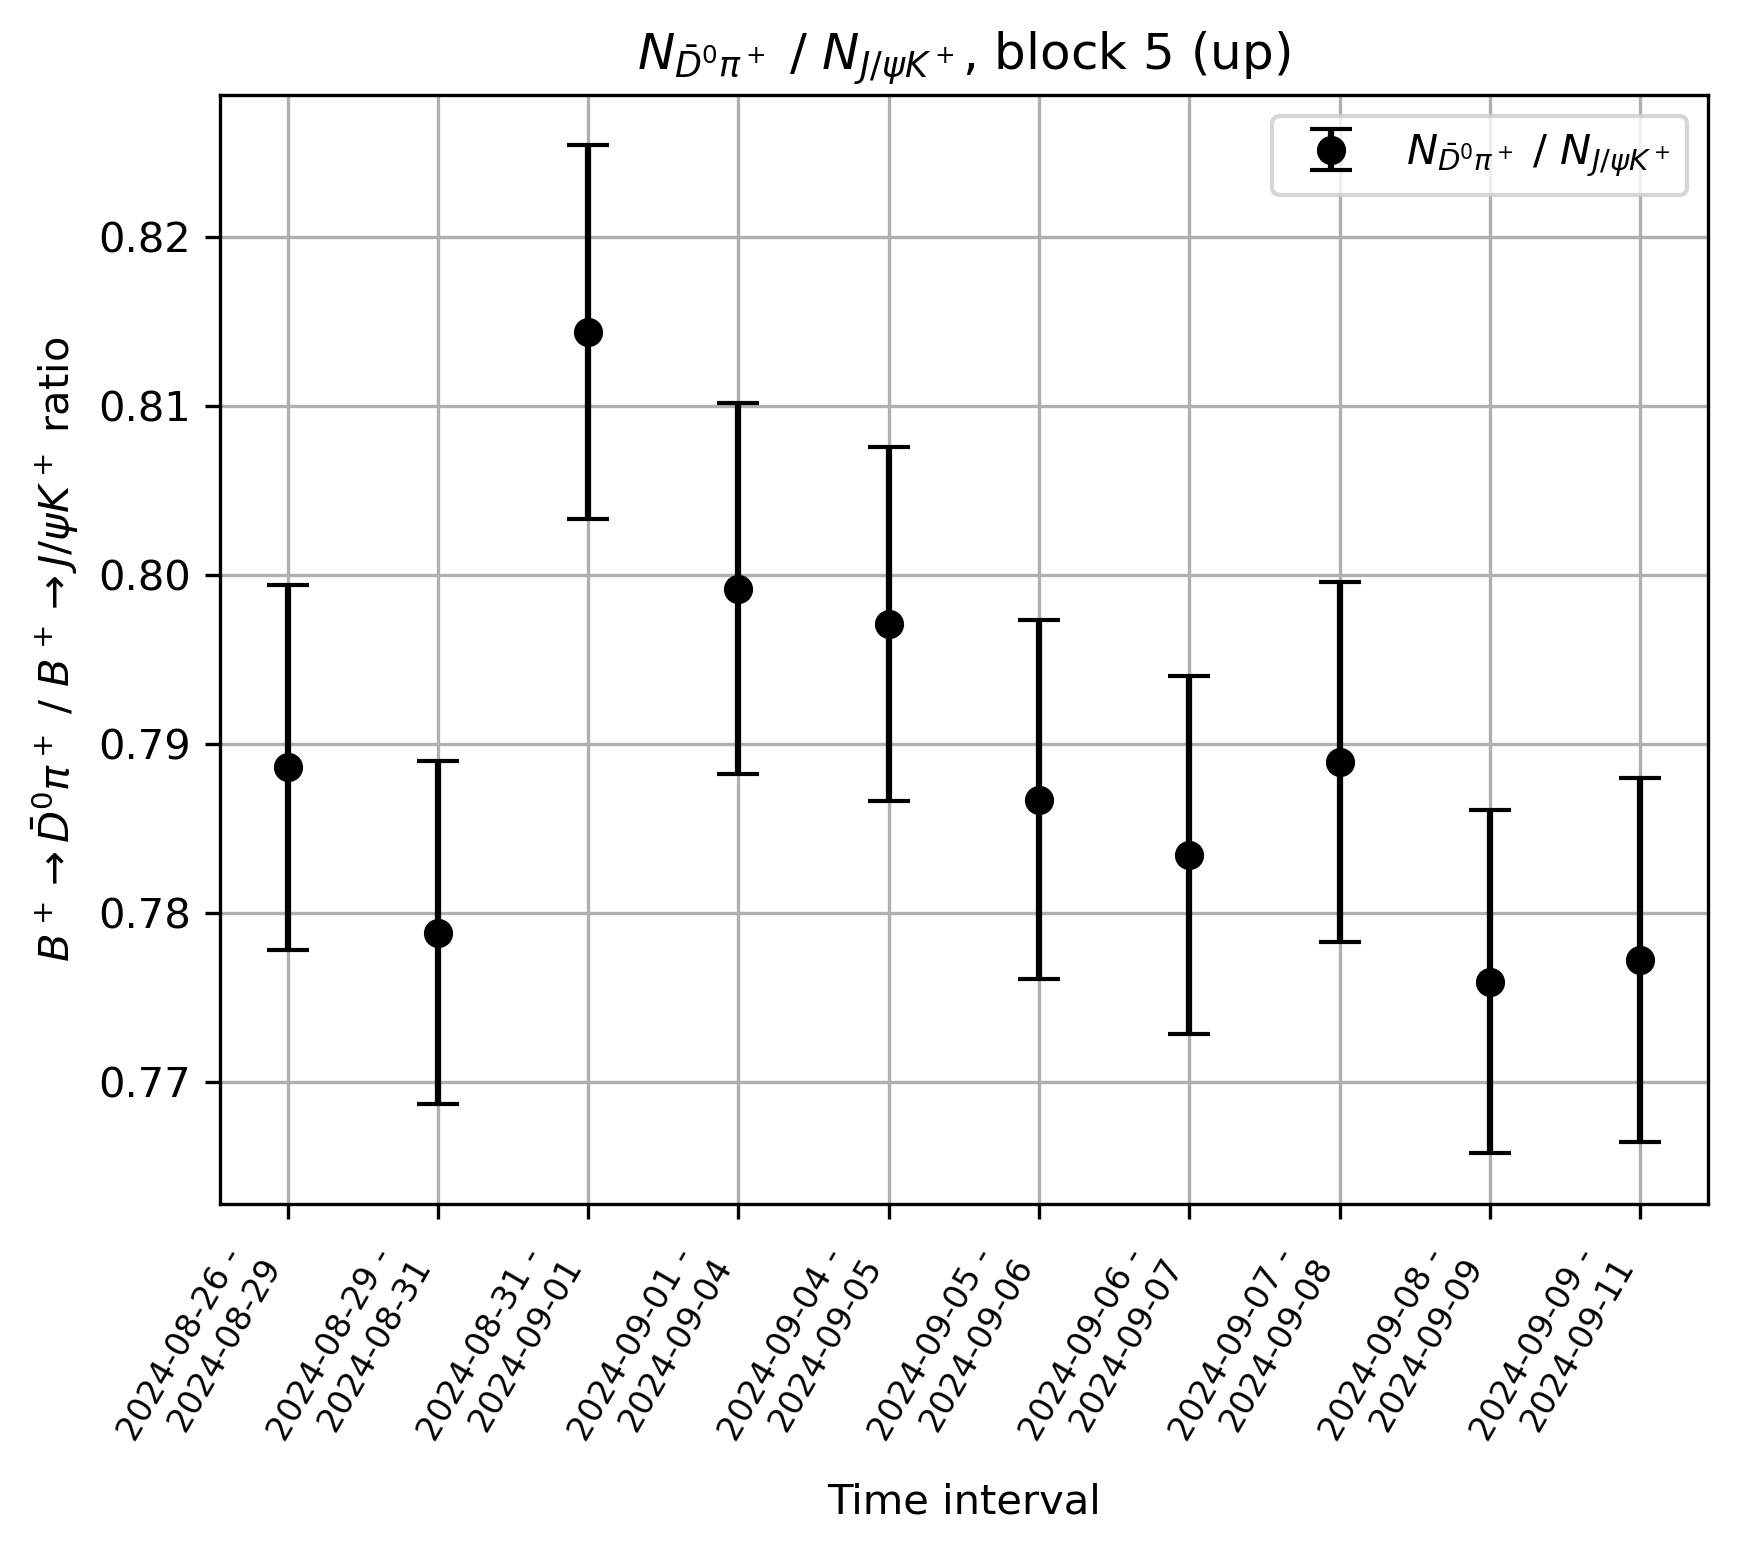

Fitted constant: 0.789+/-0.004
Chi^2: 10.877903410980823
Chi^2/dof: 1.2086559345534247


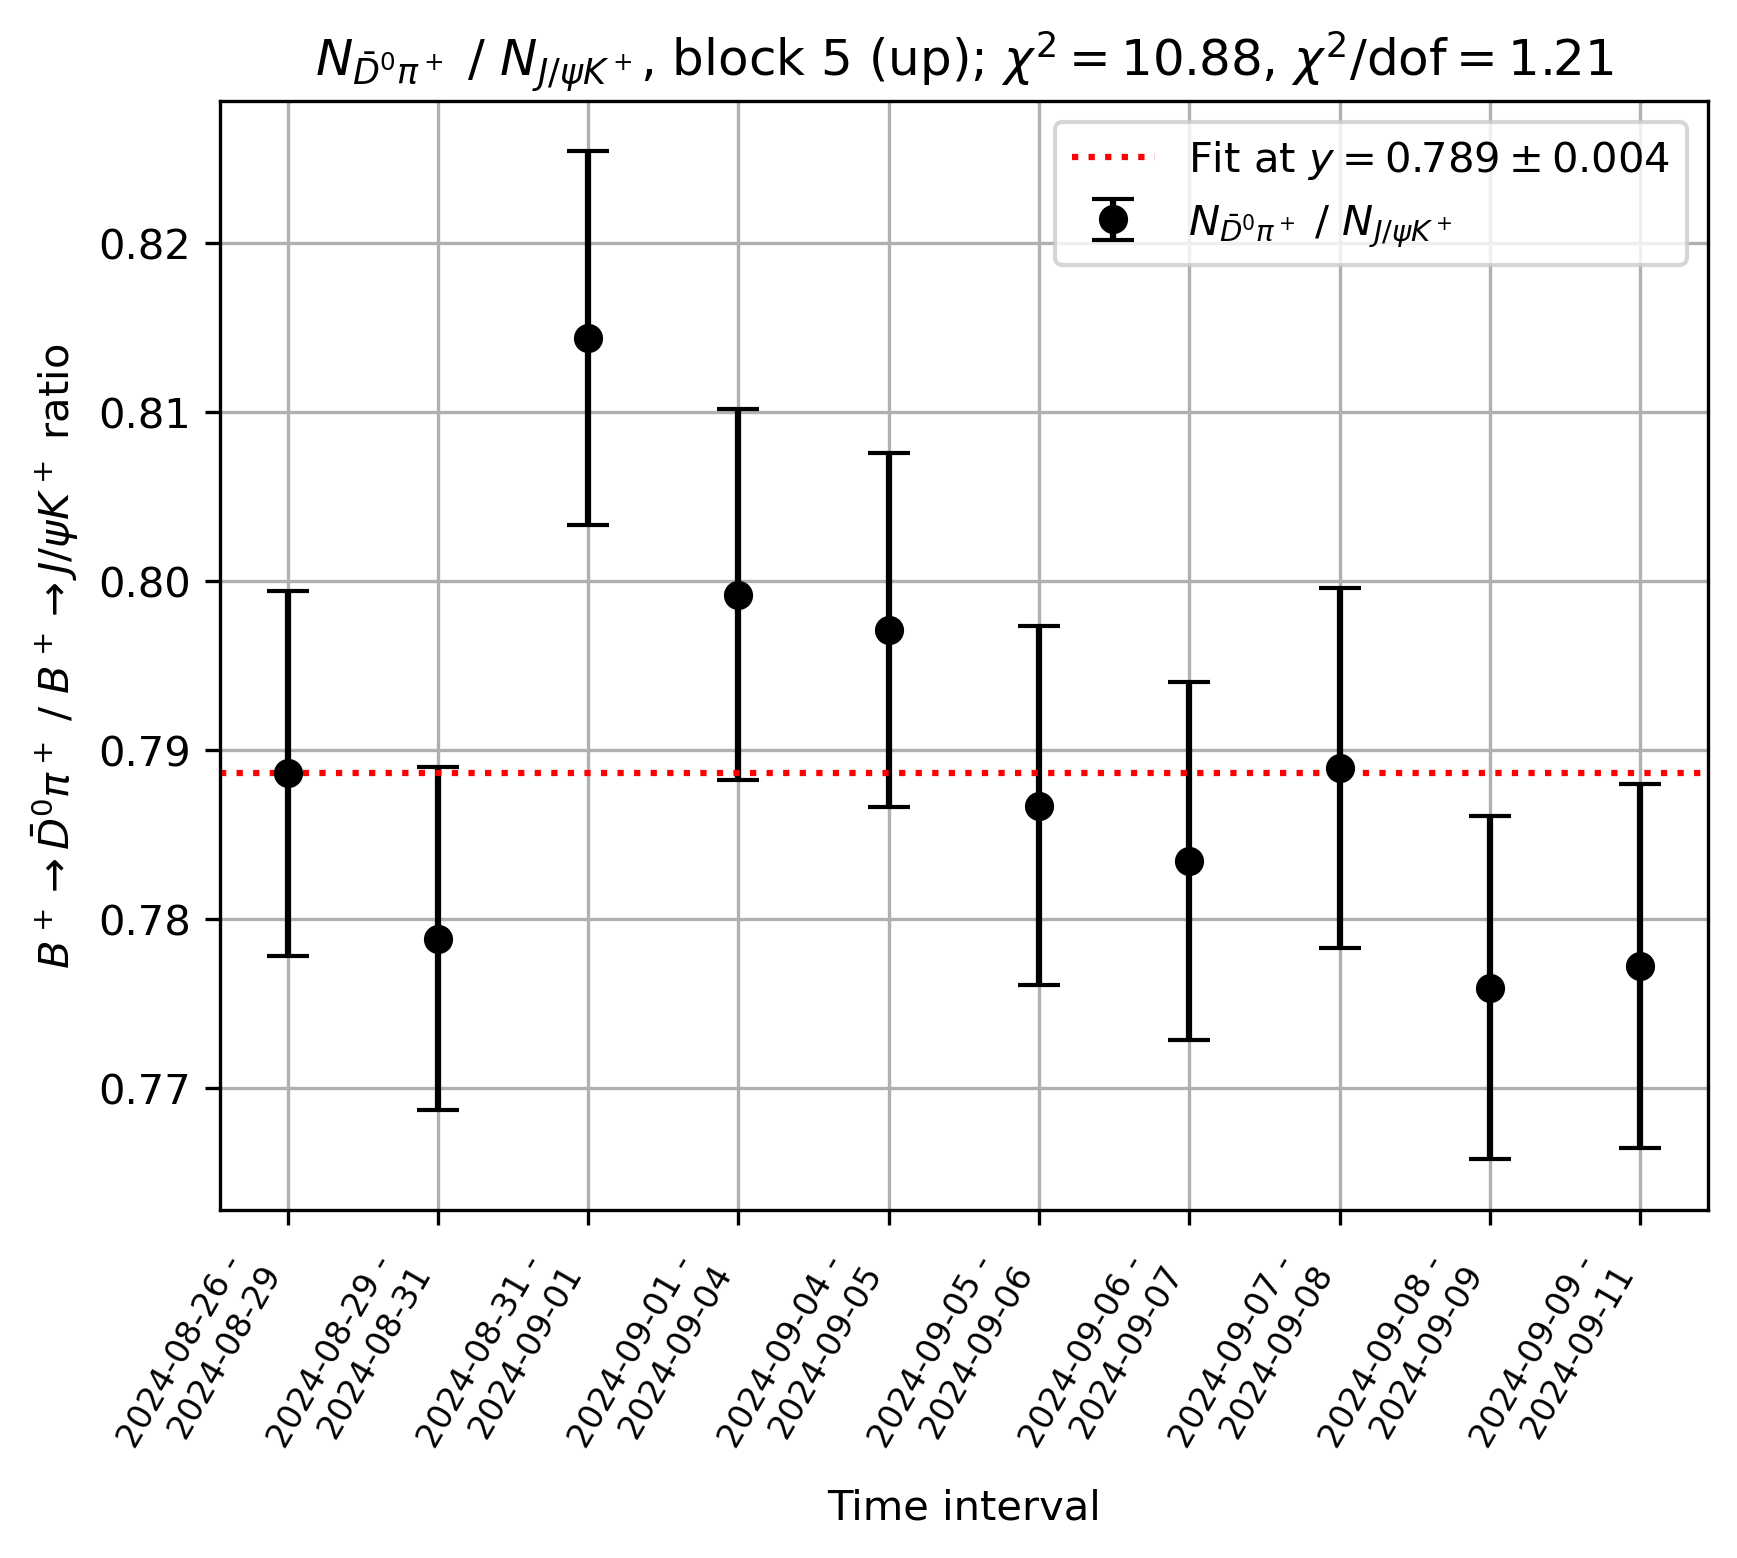

[81038.08451550135+/-399.89678055464174
 80858.11268762719+/-399.95570547033276
 79188.65414730296+/-398.00083057882875
 80552.6641561571+/-399.7587448992708
 78714.88763363354+/-397.33058532750147
 81580.21726101407+/-400.93300888444355
 78559.13615514562+/-397.3758147222761
 80812.02214749367+/-399.92586761705024
 77309.68902517555+/-395.5677812007125
 78786.7619292555+/-397.6121130888132]
[110029.99743929572+/-1605.6193290171286
 108655.86812286645+/-1487.2304092014238
 103247.20867126774+/-1487.2369755003965
 107224.29634406567+/-1477.2865630754968
 106845.49163280654+/-1512.8181767758724
 105983.4598974708+/-1490.071110371442
 101664.57081726563+/-1489.360000729168
 105678.58478650282+/-1482.0832265097197
 101428.39216539191+/-1430.7661518944078
 101615.71106318964+/-1435.5898988391928]
[0.7365090102834057+/-0.011345438839201985, 0.7441670117272823+/-0.01083051254044498, 0.7669810657974724+/-0.011701266587561198, 0.7512538380077258+/-0.011001416301468099, 0.7367169772979396+/-0.01

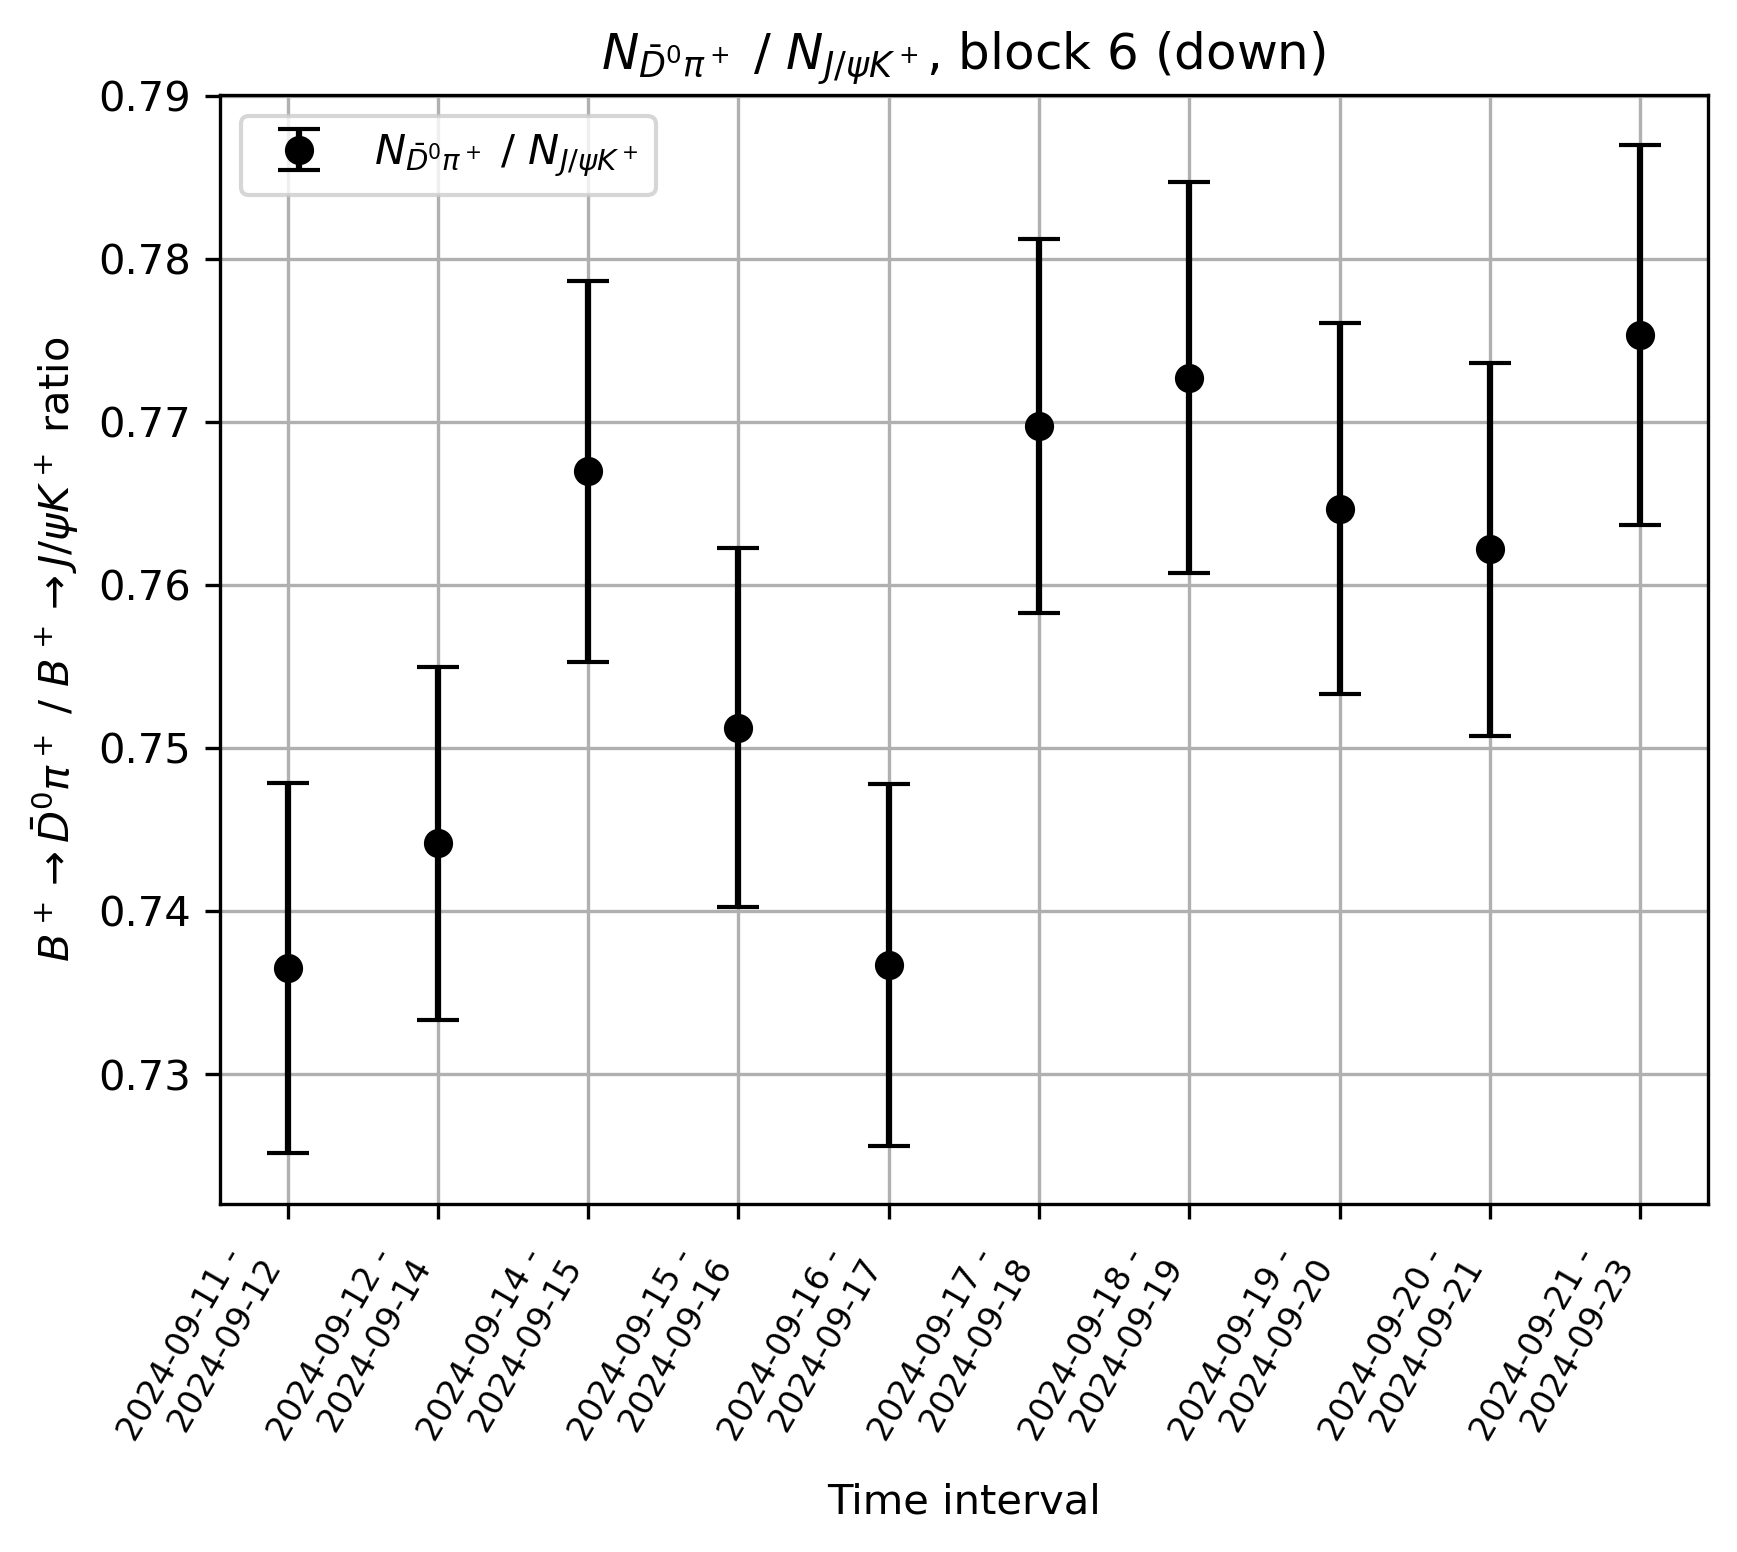

Fitted constant: 0.757+/-0.005
Chi^2: 15.119309701730193
Chi^2/dof: 1.6799233001922438


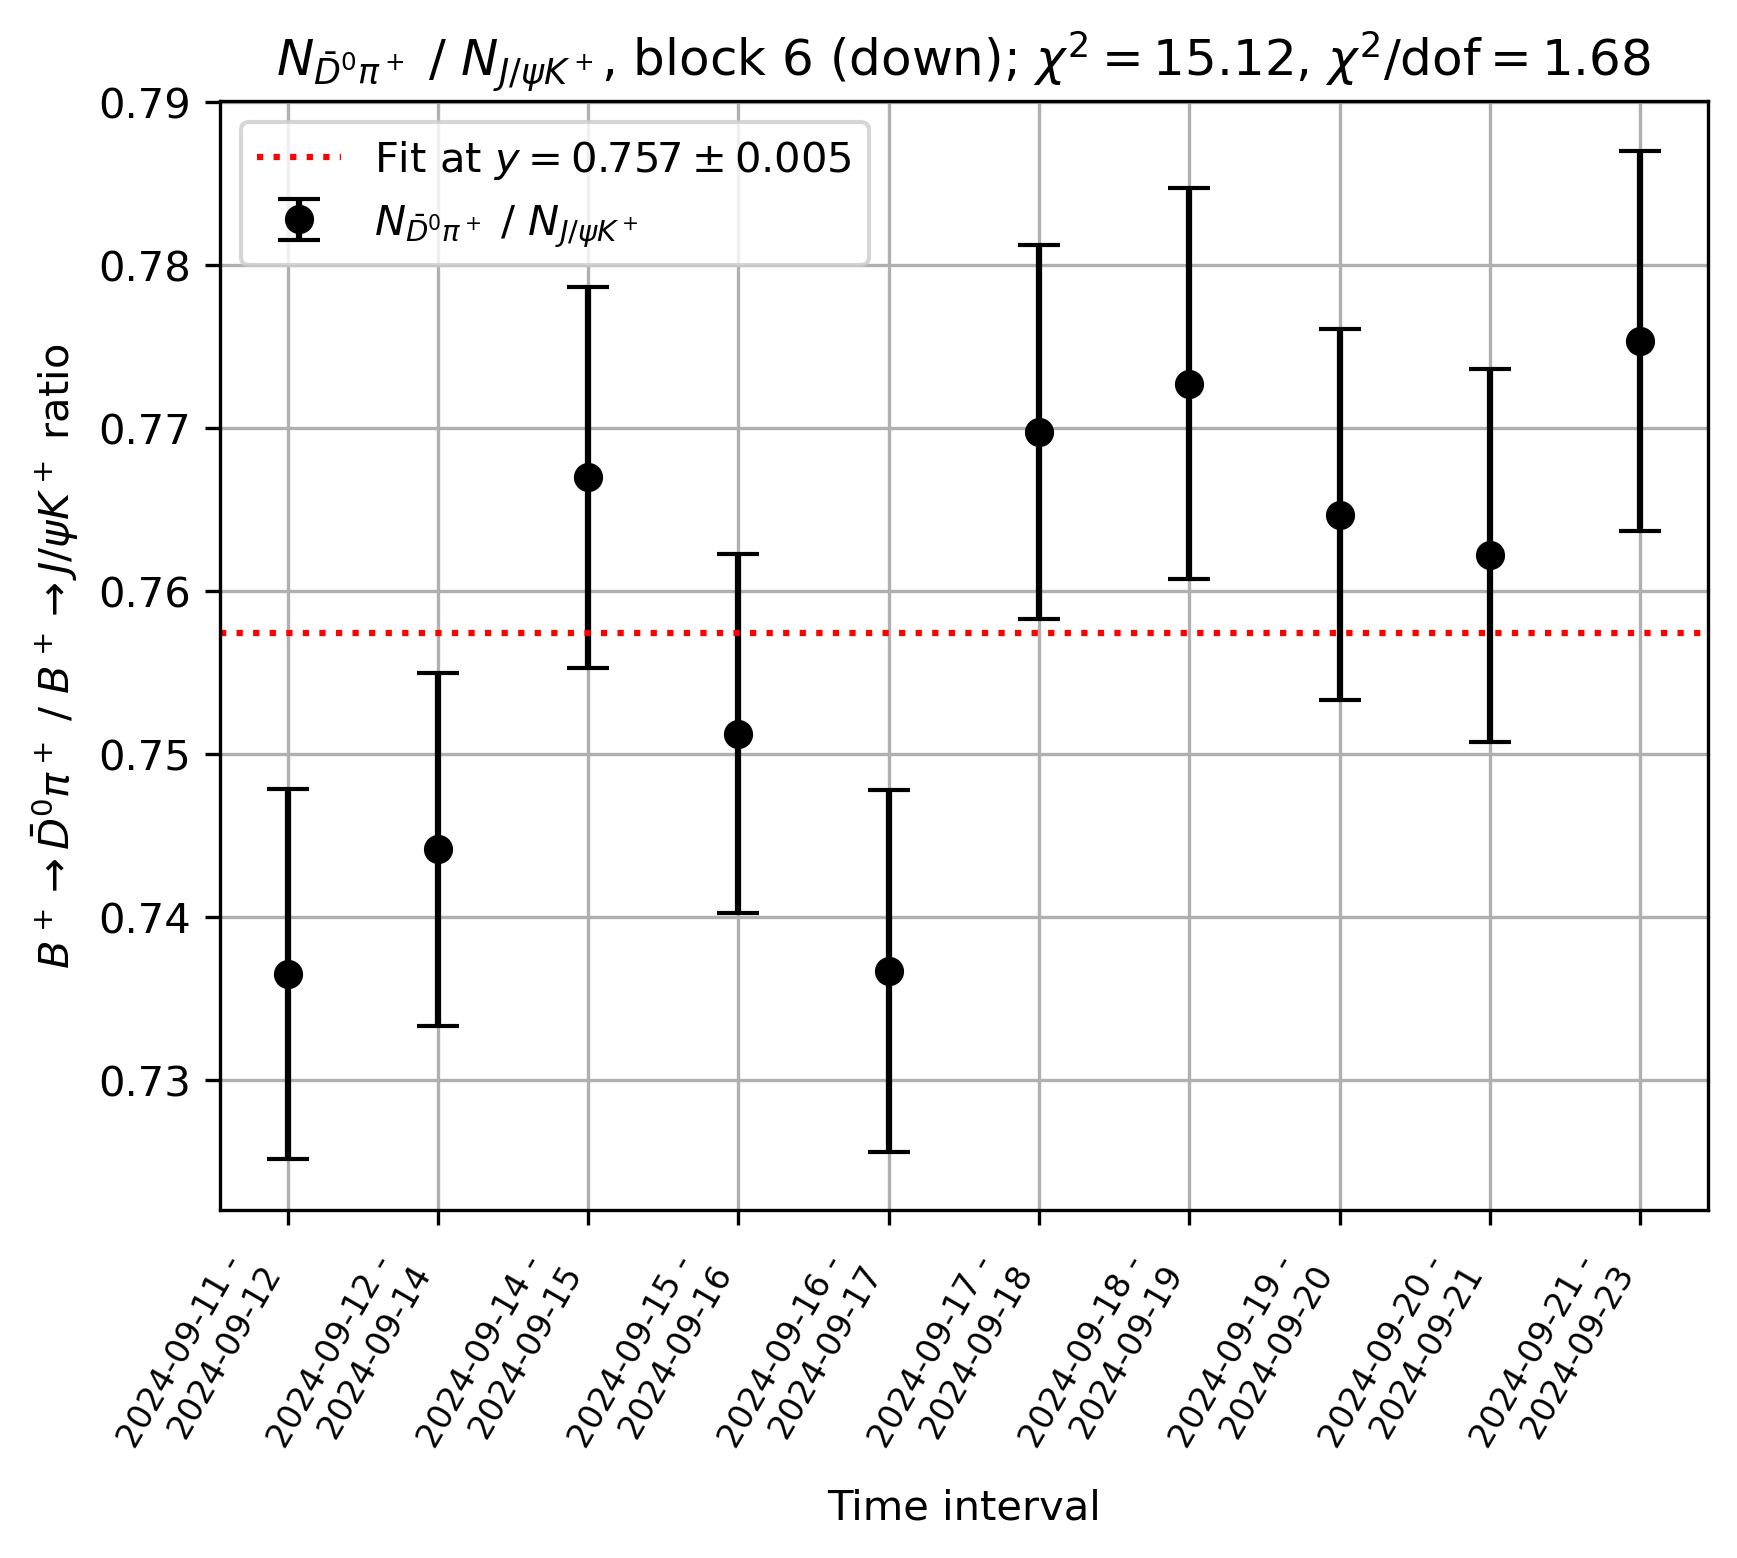

[64313.846826451445+/-371.7120271650383
 62317.43190803861+/-369.1880545441127
 61142.33644099694+/-367.1889568107108
 61419.93886849877+/-367.81156261893557
 61060.83122853668+/-362.6913448133819
 62824.94542133655+/-369.8638295743949
 62285.36133200583+/-368.81744784045804
 62187.183093399326+/-369.0245986844857
 63284.562787993986+/-370.833513581656
 61193.62092973978+/-367.57264736524303]
[80027.7535674734+/-1559.0598587626955
 74976.37065185771+/-1567.4317617198394
 72286.90936987025+/-1251.3287762236068
 80812.65496154065+/-1746.769737551549
 72626.67579044093+/-1220.2115171309051
 78243.83555222585+/-1561.161126415791
 74429.2863555792+/-1106.6391506682849
 76162.53532558655+/-1551.788880466287
 78409.90094716975+/-1182.2739279905727
 73936.1799619485+/-1207.3457348974116]
[0.8036442853819061+/-0.01633065472523099, 0.831160955995068+/-0.018060207969699295, 0.8458286150836813+/-0.015497883021774825, 0.7600287219585717+/-0.01704689131041647, 0.8407493605341835+/-0.0149823381865920

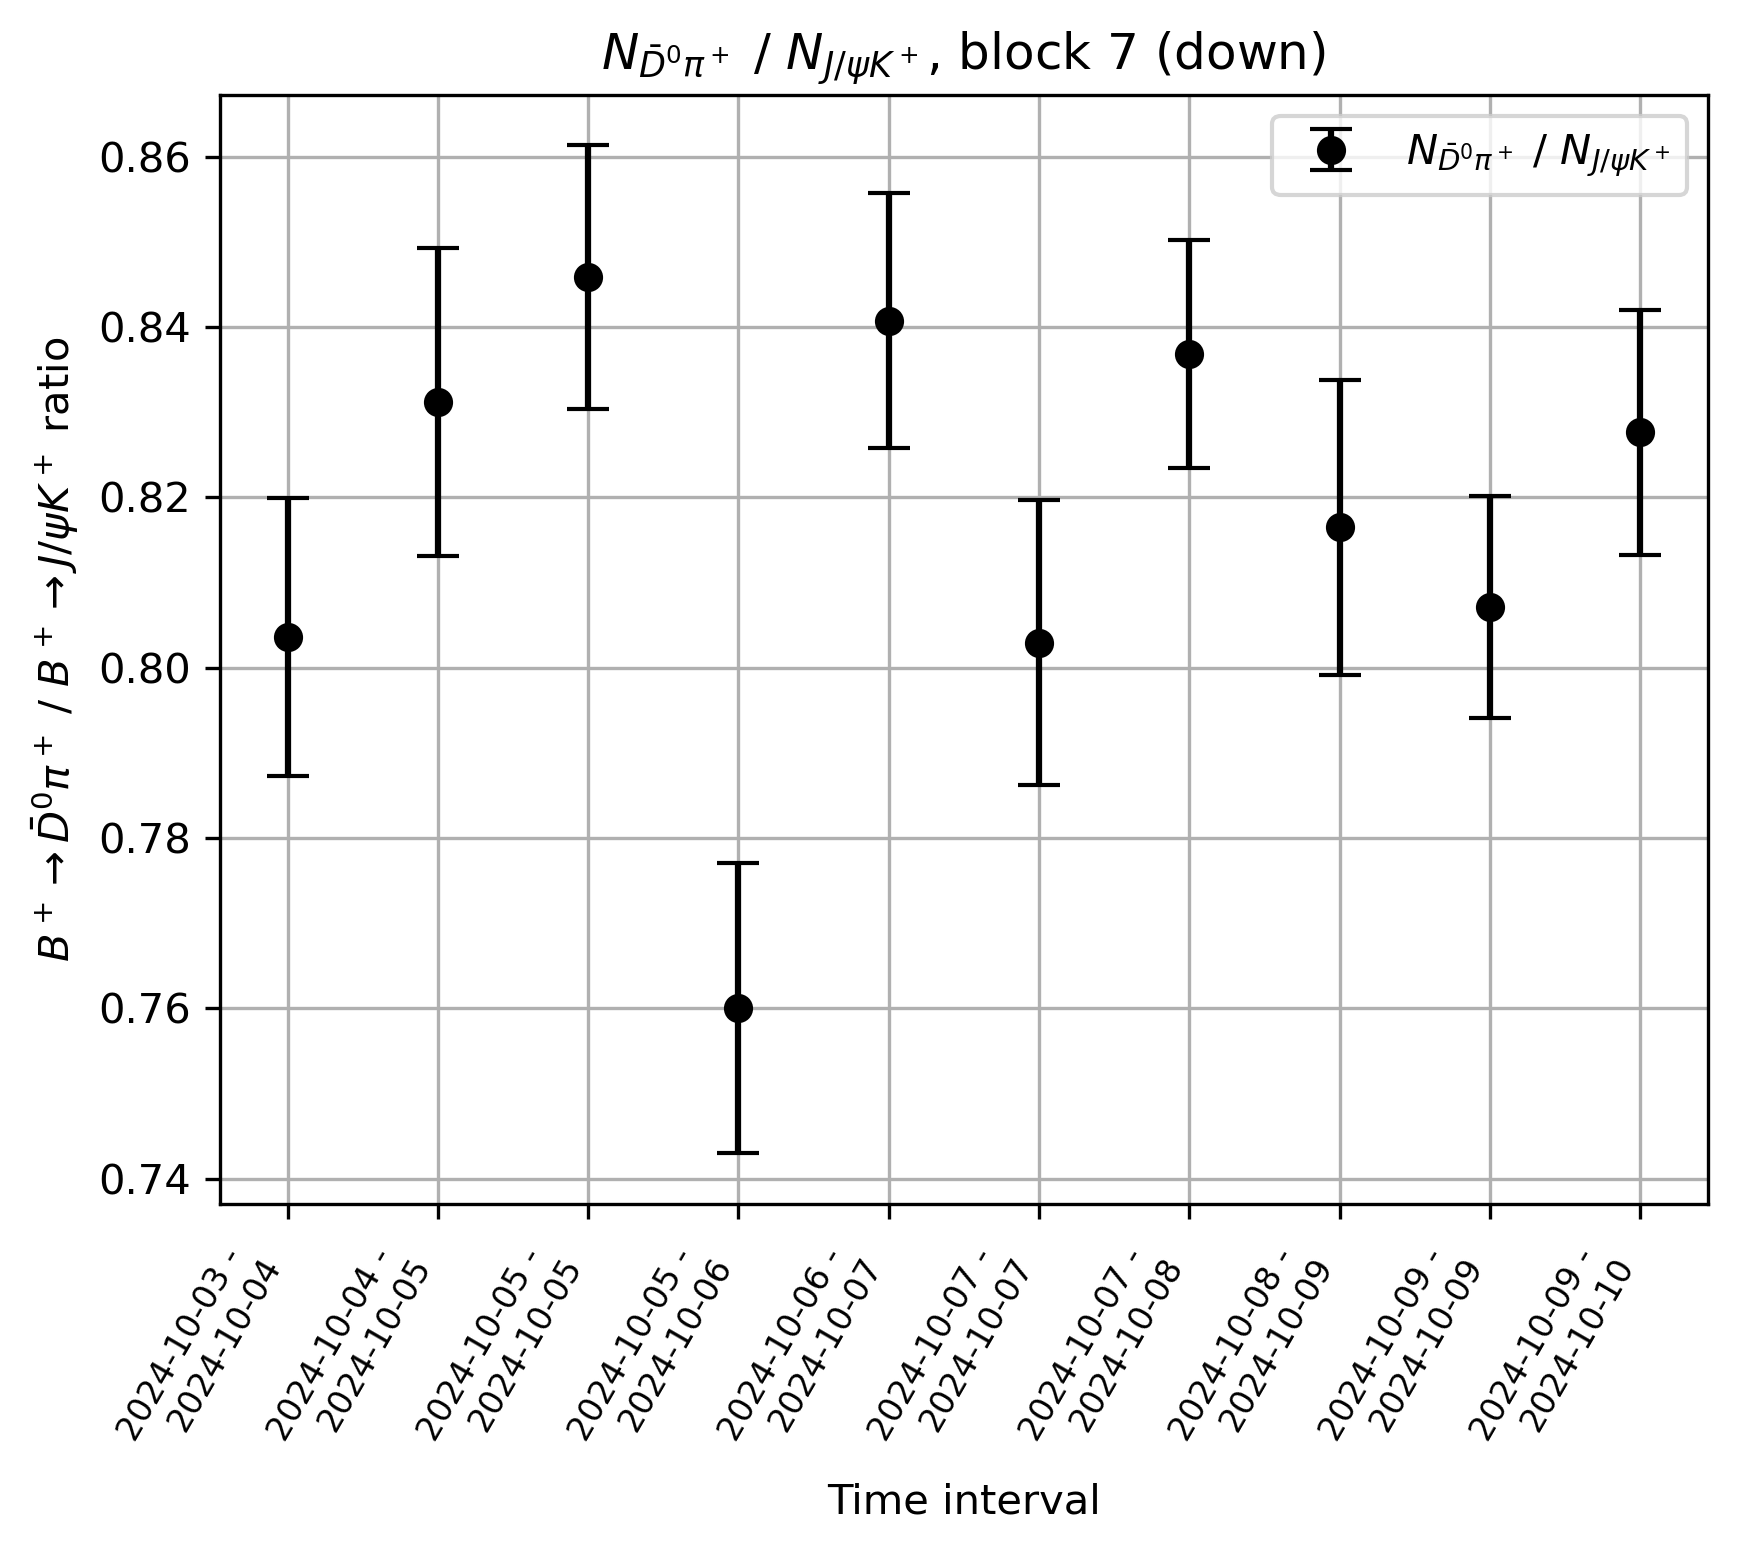

Fitted constant: 0.819+/-0.008
Chi^2: 22.318514790878524
Chi^2/dof: 2.4798349767642804


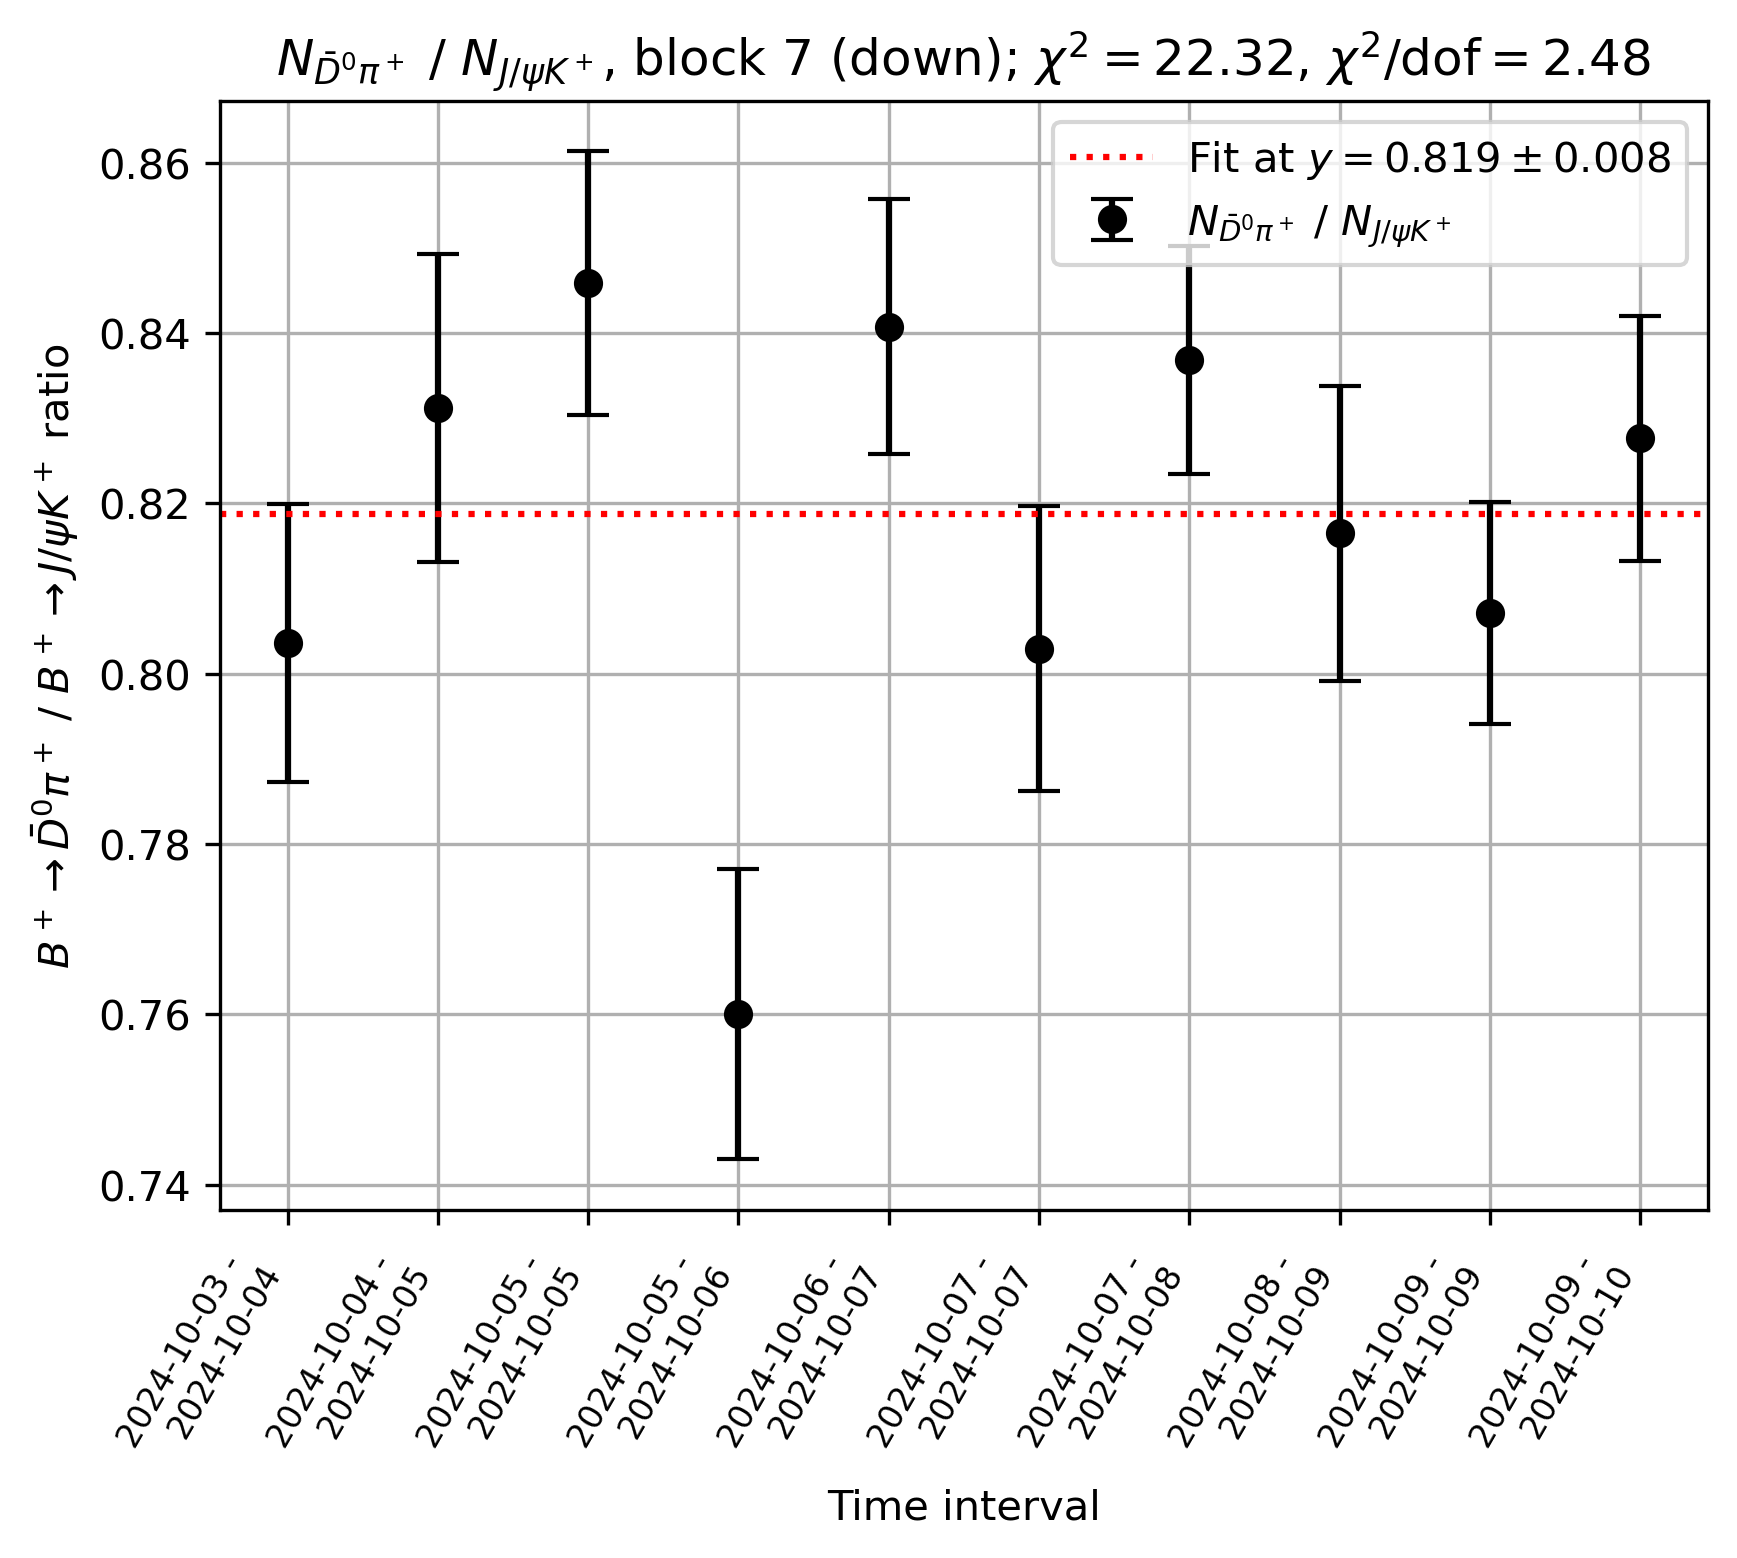

[36170.332645339346+/-286.864684992448
 37247.77731844068+/-289.1075995623578
 38840.65394042295+/-292.20982617081245
 39113.411043392814+/-292.08219814827316
 37260.780505034156+/-289.3924212618331
 38709.137586088174+/-291.8212892031188
 36082.14185005325+/-287.09625744396544
 38196.45235187092+/-290.56981568993797
 38124.07507169402+/-291.08319673333244
 37071.91366015967+/-288.6956802809218]
[45340.38182435997+/-977.0766253194633
 46548.688649152115+/-1213.667976434299
 45351.404318046174+/-923.3088701981978
 47397.44084718636+/-1172.8659678851036
 44811.60075755301+/-1117.9901110054743
 46097.118752862734+/-1112.0366986519948
 44060.16510539528+/-1112.6943104917627
 45870.4681669217+/-1026.27431979858 46706.19103826994+/-1071.589746954709
 43228.742627736654+/-1084.172141885825]
[0.7977509493734823+/-0.018318663667893552, 0.8001896164935068+/-0.021768252969862647, 0.8564377338358963+/-0.018588616830756462, 0.8252220023755712+/-0.021329980112652705, 0.8314985377699063+/-0.021726751

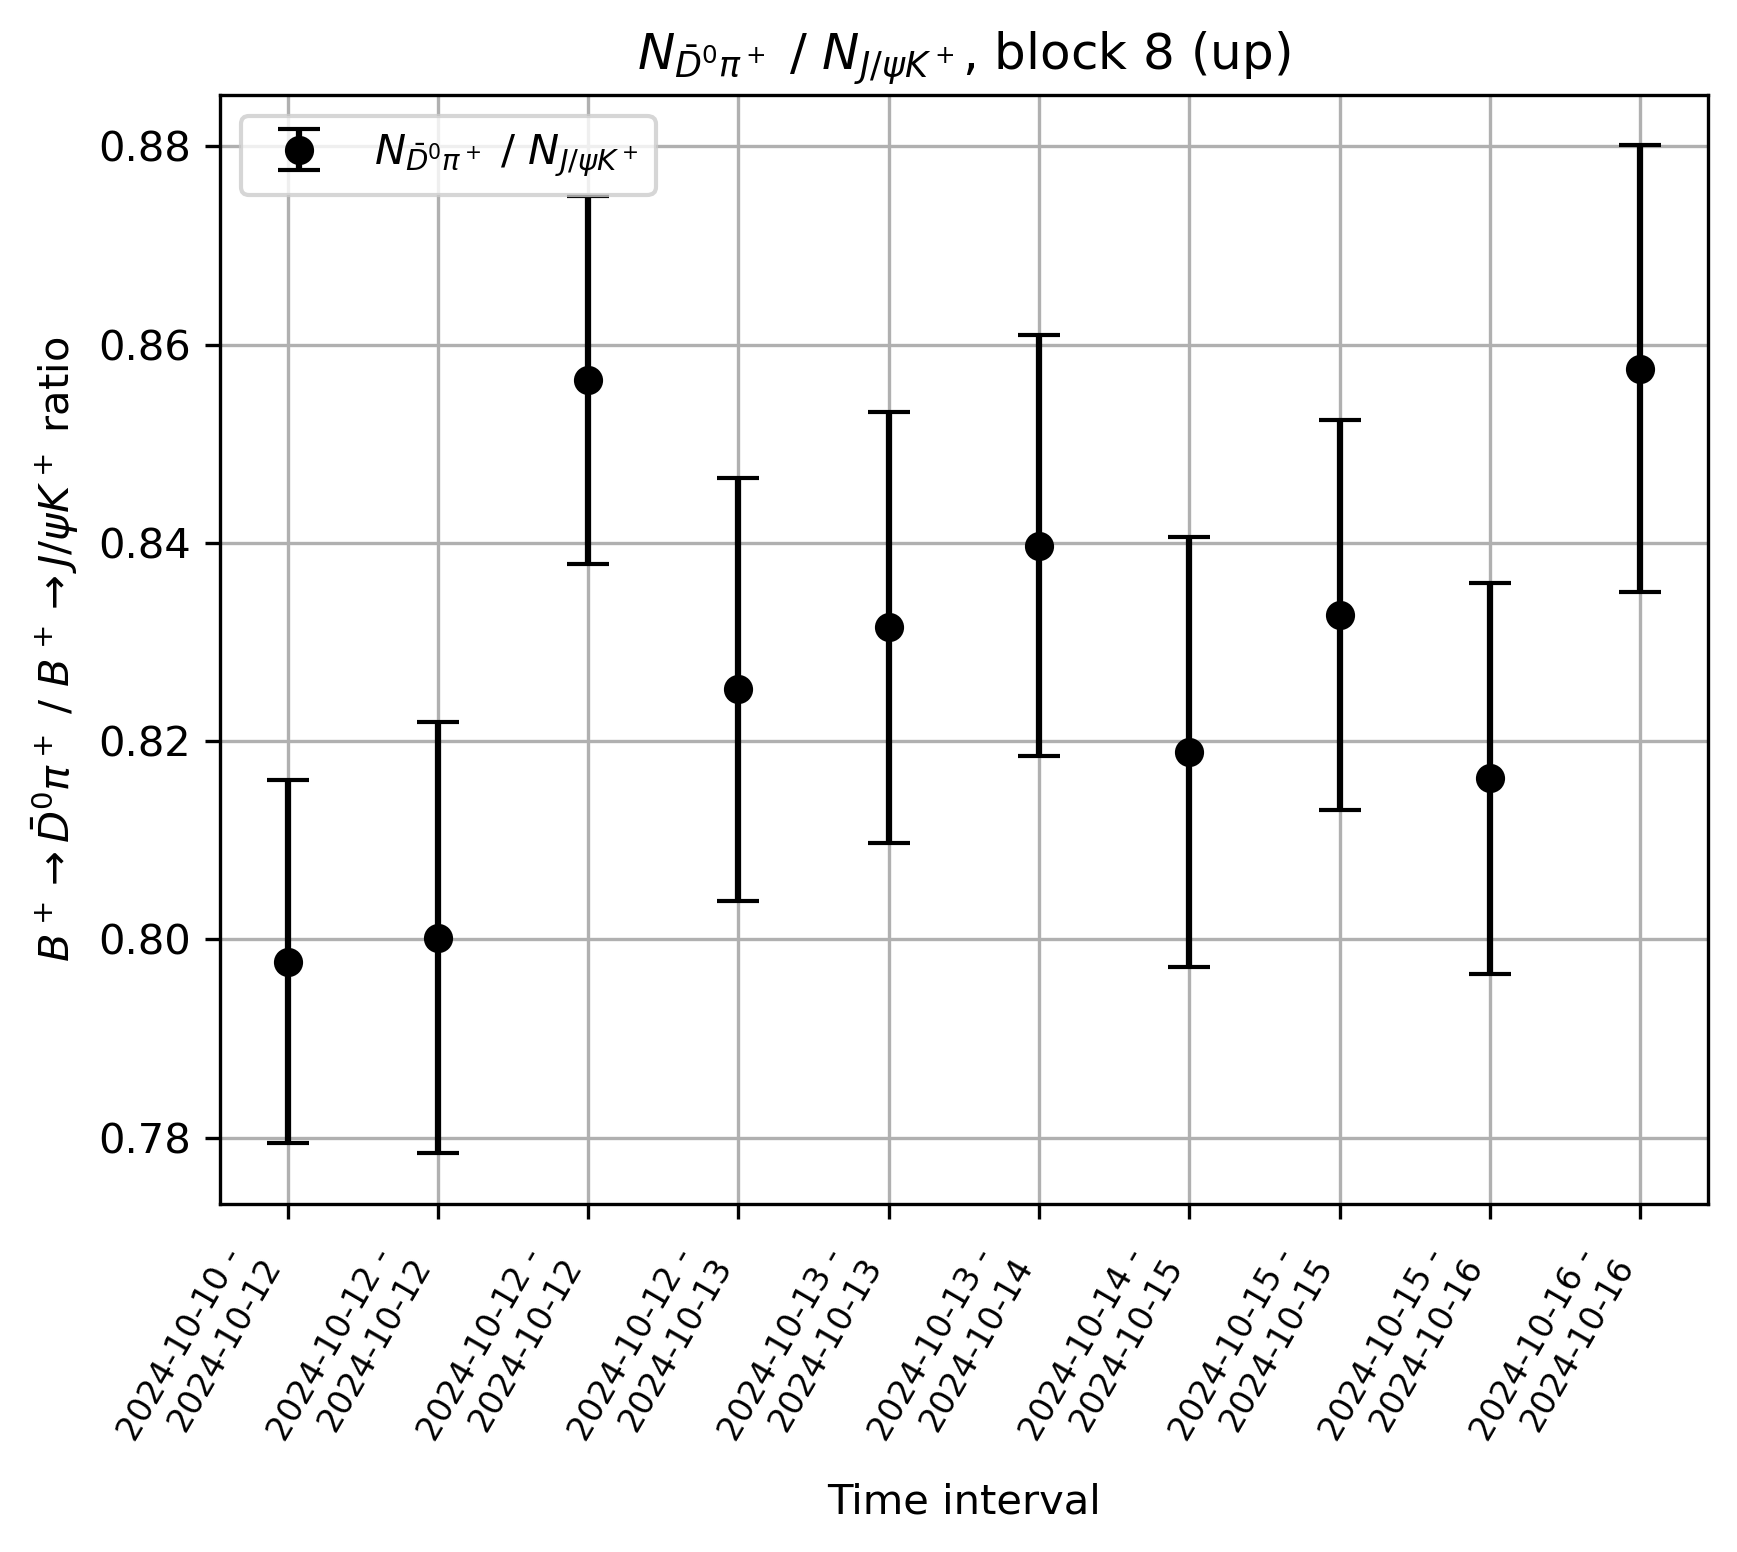

Fitted constant: 0.827+/-0.007
Chi^2: 9.344725781020948
Chi^2/dof: 1.0383028645578831


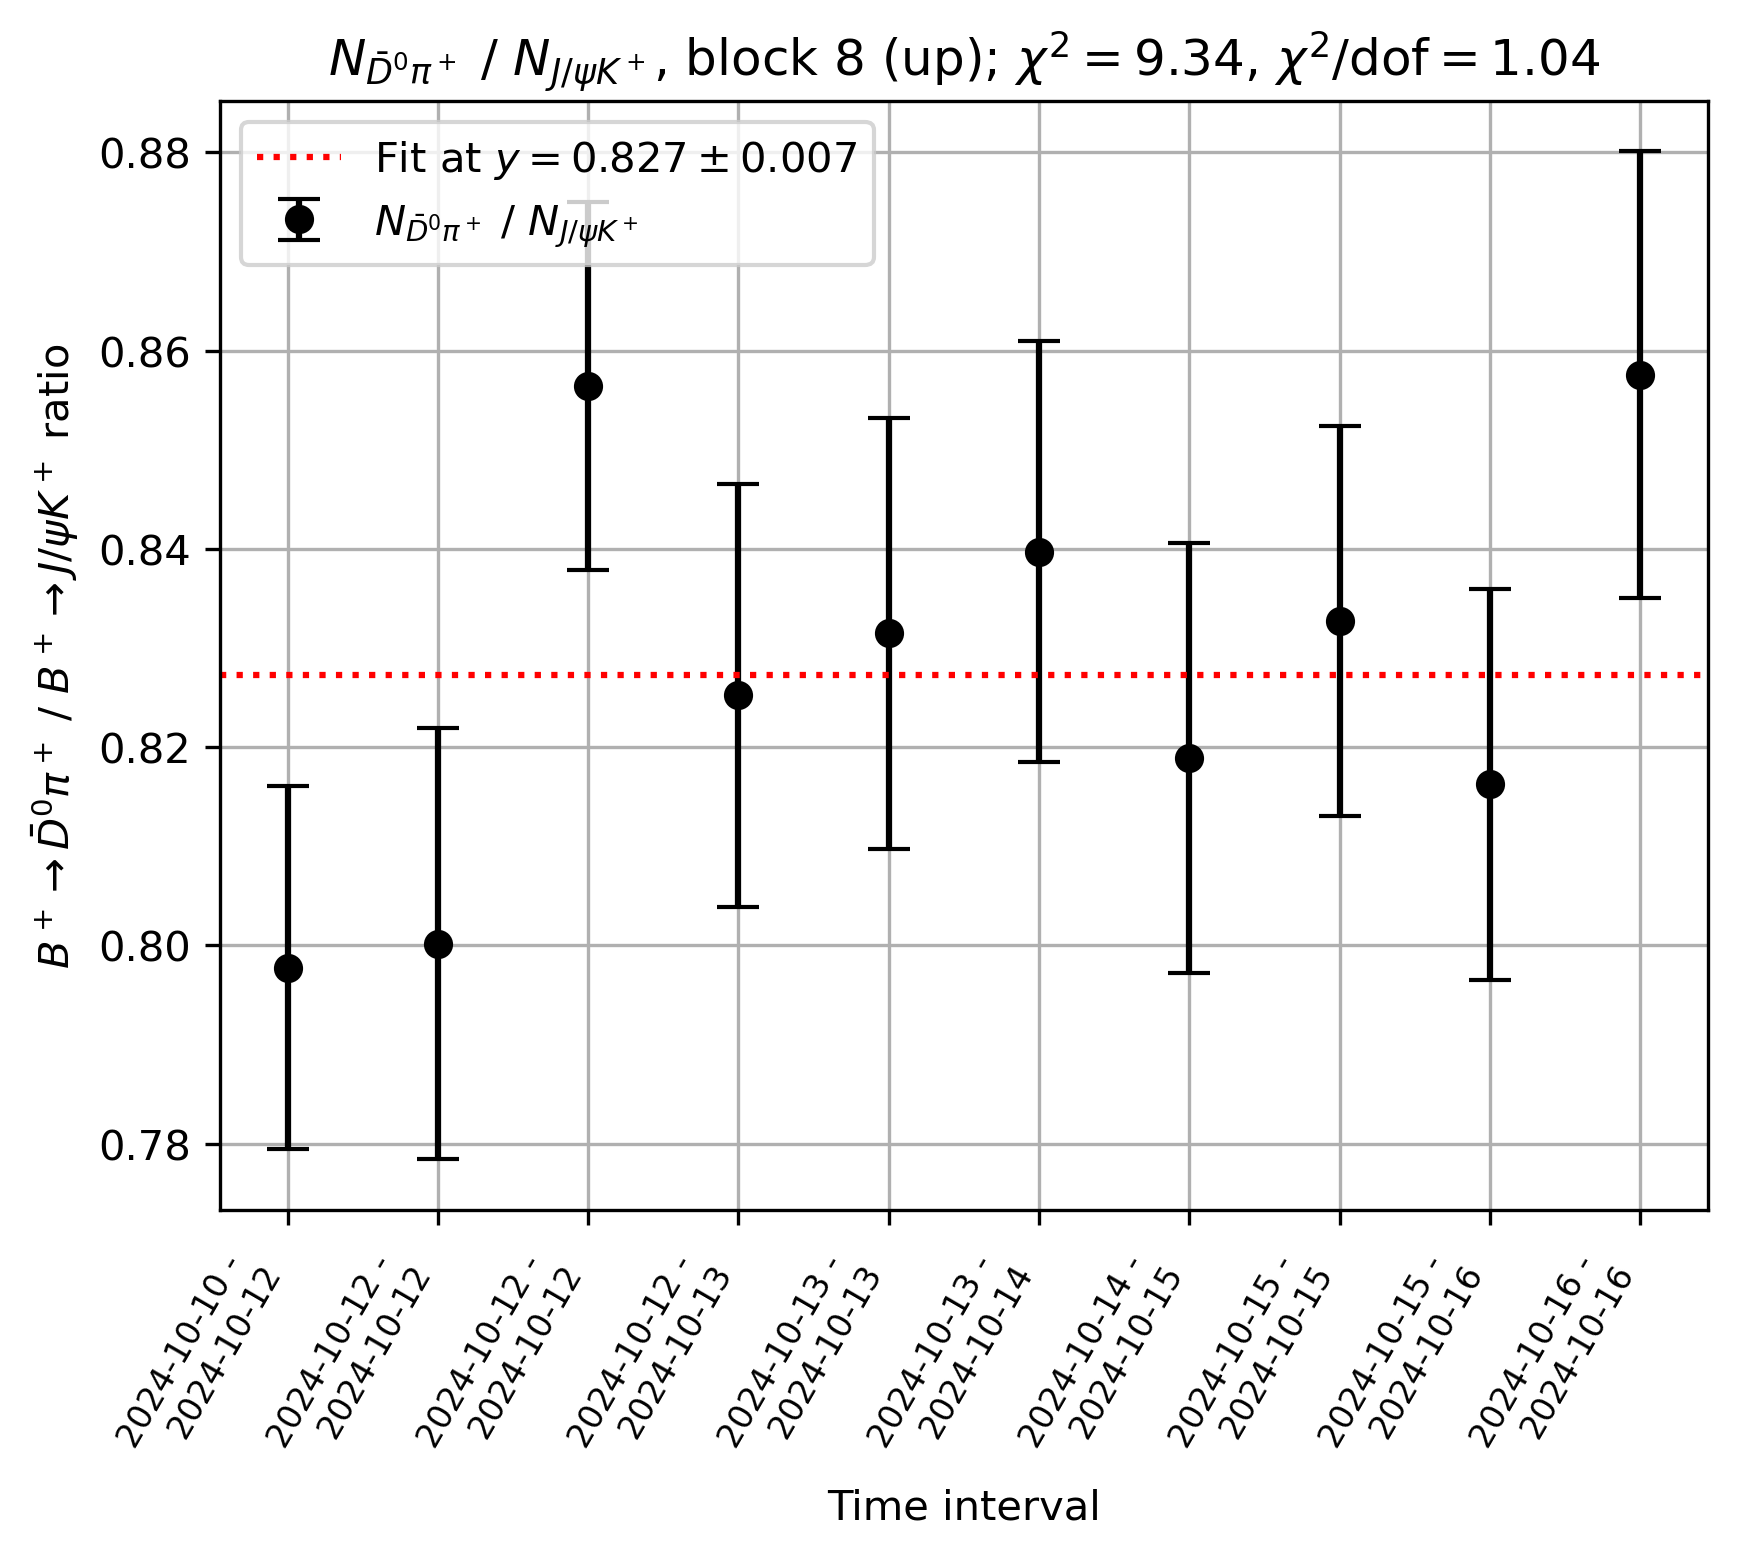

In [ ]:
for i in range(4):

    ratios = [a / b for a, b in zip(signal_yields_dpi[i], signal_yields_jpsik[i])]

    ratios_val = np.array([r.nominal_value for r in ratios])
    ratios_err = np.array([r.std_dev for r in ratios])

    print(signal_yields_dpi[i])
    print(signal_yields_jpsik[i])
    print(ratios)

    x_plot = np.arange(len(ratios_val))
    plt.errorbar(x_plot, ratios_val, yerr=ratios_err, fmt='o', capsize=5, label=r"$N_{\bar{D}^0\pi^+}$ / $N_{J/\psi K^+}$", color='black', ecolor='black')
    plt.xlabel("Time interval")
    plt.ylabel(r"$B^+ \rightarrow \bar{D}^0\pi^+$ / $B^+ \rightarrow J/\psi K^+$ ratio")
    if i == 0 or i == 3:
        plt.title(r"$N_{\bar{D}^0\pi^+}$ / $N_{J/\psi K^+}$" + f", block {i+5} (up)")
    else:
        plt.title(r"$N_{\bar{D}^0\pi^+}$ / $N_{J/\psi K^+}$" + f", block {i+5} (down)")
    ticks = [f"{datetime.fromtimestamp(block_time_bins[i][k] / 1e6).date()} - \n{datetime.fromtimestamp(block_time_bins[i][k+1] / 1e6).date()}" for k in range(n_bins)]
    plt.xticks(x_plot, ticks, rotation=60, ha='right', fontsize=8)
    #plt.ylim(0.95, 1.2)
    plt.legend()
    plt.grid(True)
    plt.show()

    # fit and chi^2

    constant_function = lambda x, a: a

    popt, pcov = curve_fit(constant_function, x_plot, ratios_val, sigma=ratios_err)#, absolute_sigma=True)

    y_fit = constant_function(x_plot, *popt)
    y_unc = np.sqrt(pcov[0, 0])

    y_fit_err = ufloat(y_fit, y_unc)
    avg_ratios[i] = y_fit_err

    # calculate chi^2
    chi_squared = np.sum(((ratios_val - y_fit) / ratios_err) ** 2)

    chi_squared_reduced = chi_squared / 9

    print(f"Fitted constant: {y_fit_err}")
    print(f"Chi^2: {chi_squared}")
    print(f"Chi^2/dof: {chi_squared_reduced}")

    plt.errorbar(x_plot, ratios_val, yerr=ratios_err, fmt='o', capsize=5, label=r"$N_{\bar{D}^0\pi^+}$ / $N_{J/\psi K^+}$", color='black', ecolor='black')
    plt.axhline(y_fit, linestyle="dotted", color='red', label=rf"Fit at $y={y_fit_err.nominal_value:.3f} \pm {math.ceil(y_fit_err.std_dev * 10 ** 3) / (10 ** 3)}$")
    plt.xlabel("Time interval")
    plt.ylabel(r"$B^+ \rightarrow \bar{D}^0\pi^+$ / $B^+ \rightarrow J/\psi K^+$ ratio")
    if i == 0 or i == 3:
        plt.title(rf"$N_{{\bar{{D}}^0\pi^+}}$ / $N_{{J/\psi K^+}}$, block {i+5} (up); $\chi^2 = {chi_squared:.2f}$, $\chi^2/\text{{dof}} = {chi_squared_reduced:.2f}$")
    else:
        plt.title(rf"$N_{{\bar{{D}}^0\pi^+}}$ / $N_{{J/\psi K^+}}$, block {i+5} (down); $\chi^2 = {chi_squared:.2f}$, $\chi^2/\text{{dof}} = {chi_squared_reduced:.2f}$")

    ticks = [f"{datetime.fromtimestamp(block_time_bins[i][k] / 1e6).date()} - \n{datetime.fromtimestamp(block_time_bins[i][k+1] / 1e6).date()}" for k in range(n_bins)]
    plt.xticks(x_plot, ticks, rotation=60, ha='right', fontsize=8)
    #plt.ylim(0.95, 1.2)
    if i == 0 or i == 2:
        plt.legend(loc="upper right")
    else:
        plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

## Yield ratios per block

[0.7886035017121752+/-0.0036943177070475025
 0.7574260316124285+/-0.0046599325229969134
 0.8187828215258154+/-0.00767909316596565
 0.827235369068694+/-0.006609335489828126]


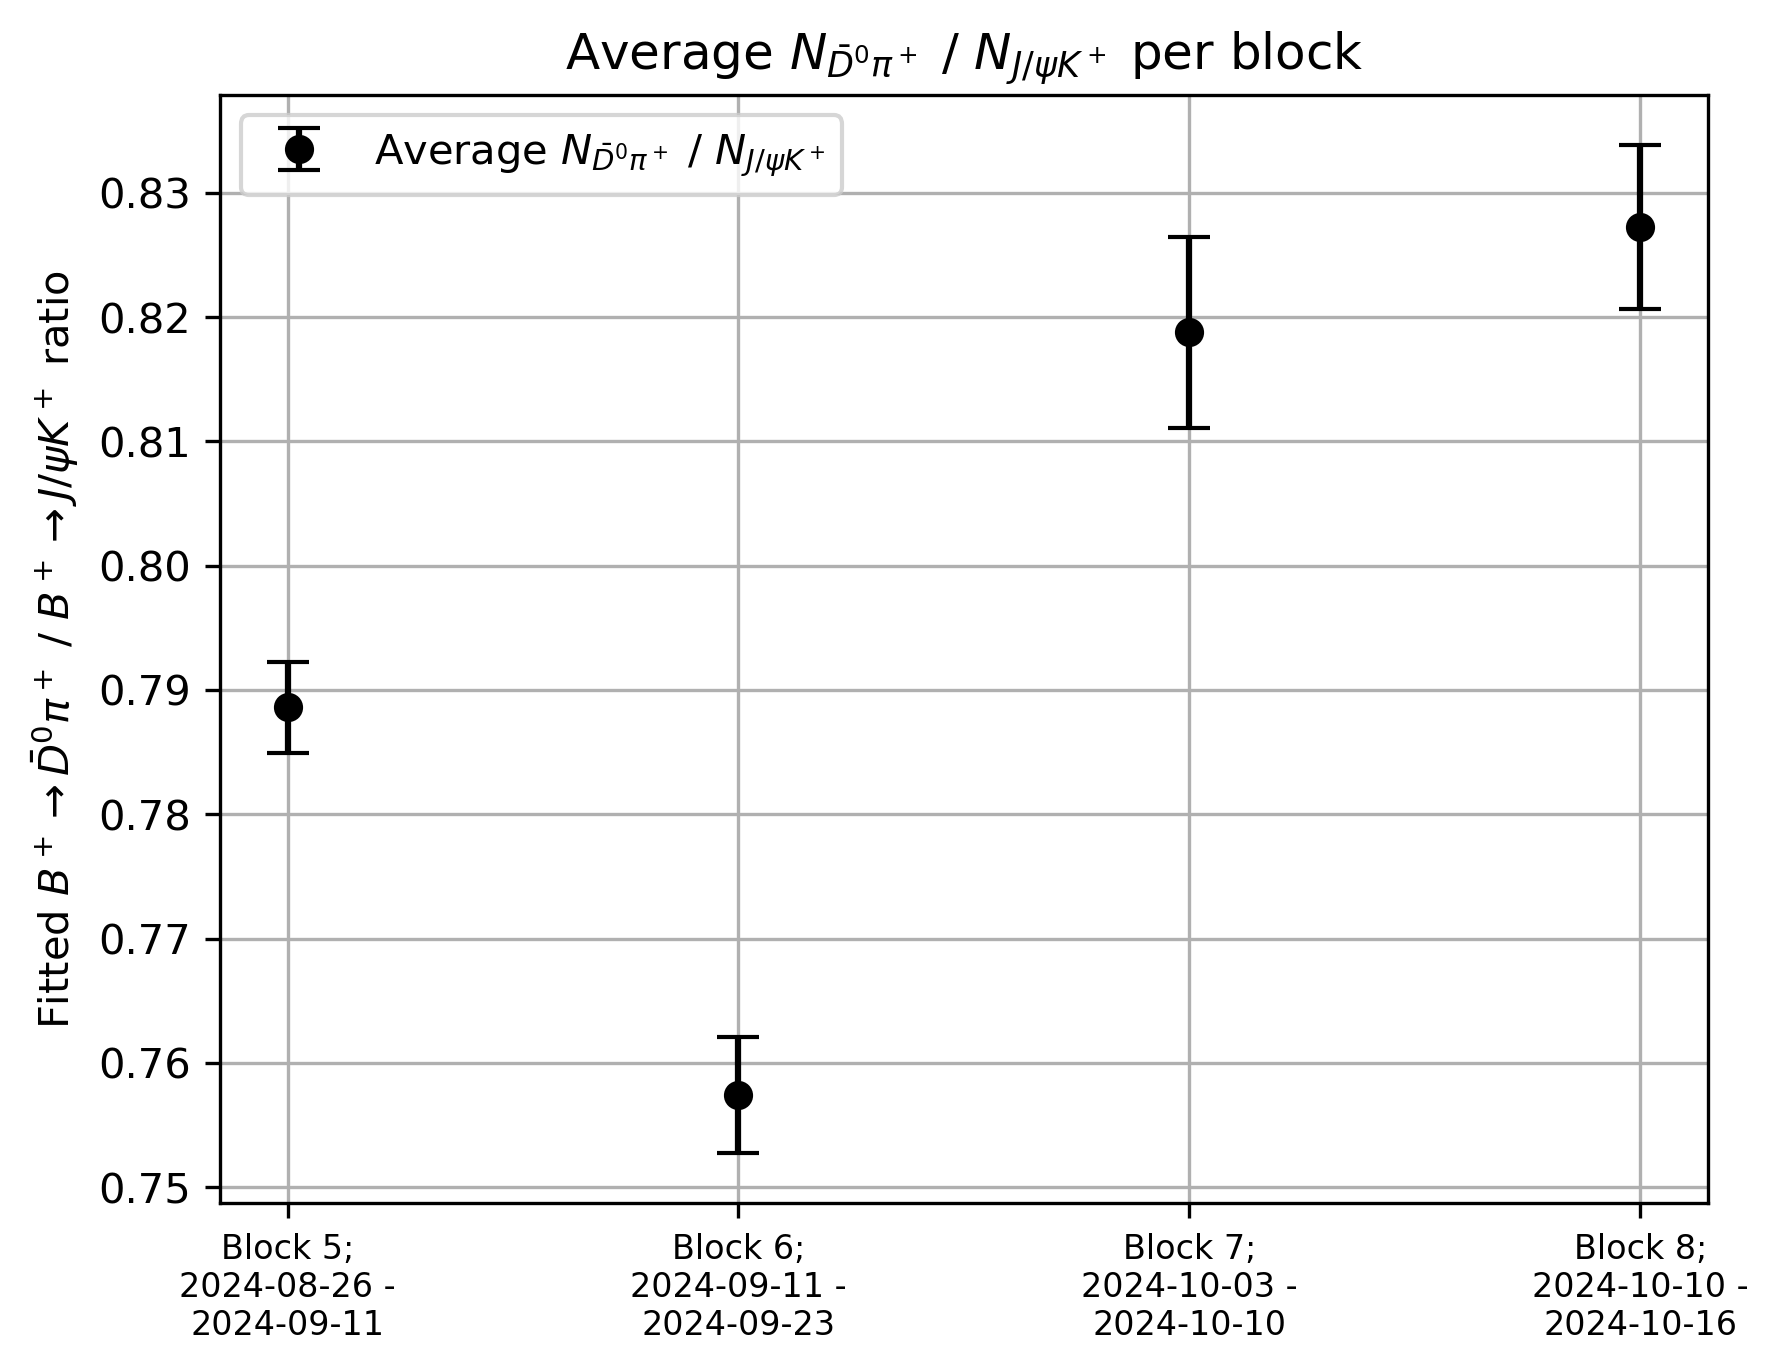

Fitted constant: 0.788+/-0.014
Chi^2: 94.36343666689643
Chi^2/dof: 31.45447888896548


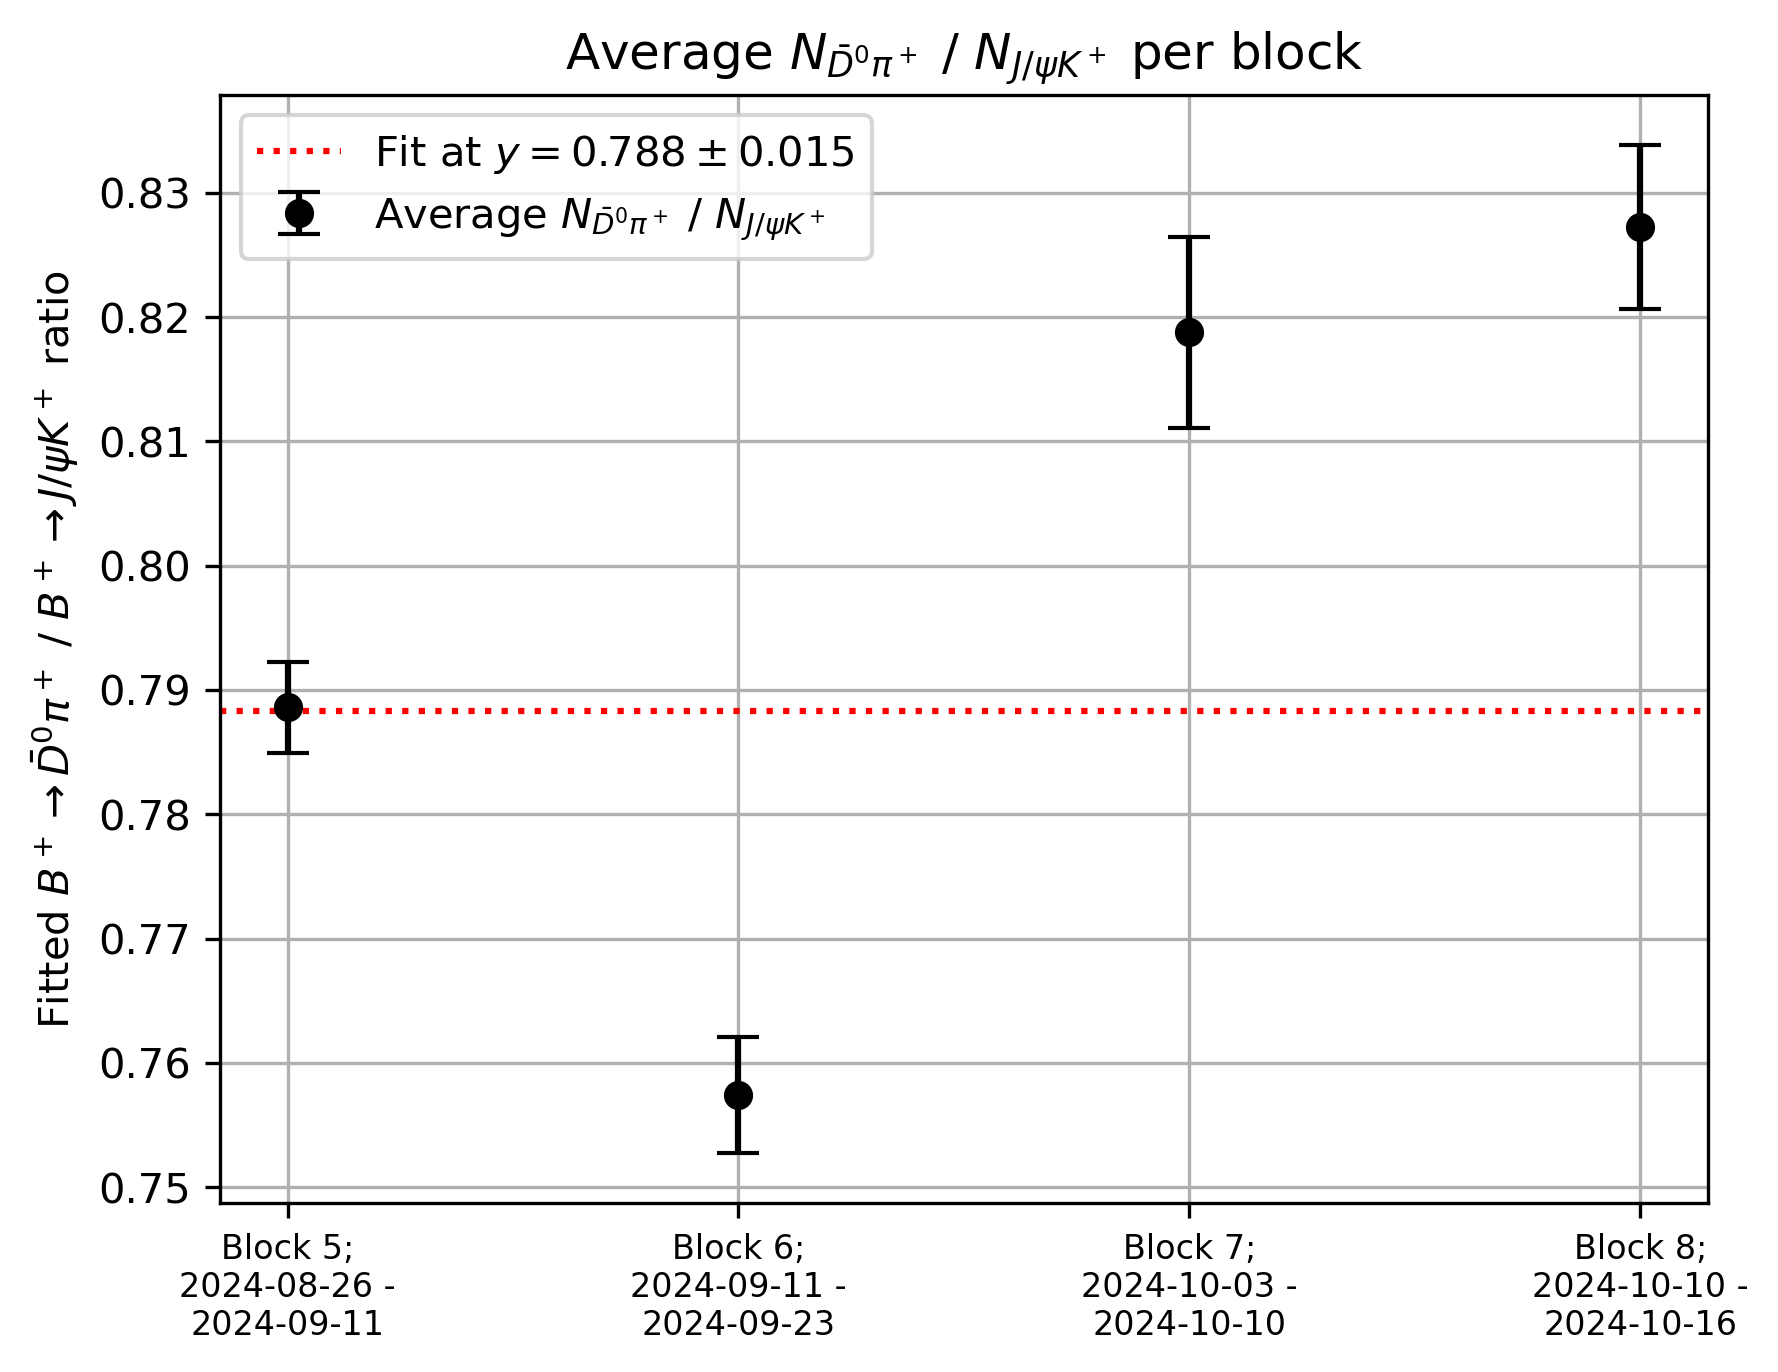

In [ ]:
avg_ratios_val = np.array([r.nominal_value for r in avg_ratios])
avg_ratios_err = np.array([r.std_dev for r in avg_ratios])

print(avg_ratios)

x_plot = np.arange(len(avg_ratios_val))
plt.errorbar(x_plot, avg_ratios_val, yerr=avg_ratios_err, fmt='o', capsize=5, label=r"Average $N_{\bar{D}^0\pi^+}$ / $N_{J/\psi K^+}$", color='black', ecolor='black')
#plt.xlabel("Block")
plt.ylabel(r"Fitted $B^+ \rightarrow \bar{D}^0\pi^+$ / $B^+ \rightarrow J/\psi K^+$ ratio")
plt.title(r"Average $N_{\bar{D}^0\pi^+}$ / $N_{J/\psi K^+}$" + f" per block")
ticks = [f"Block {i+5};\n{datetime.fromtimestamp(block_time_bins[i][0] / 1e6).date()} -\n{datetime.fromtimestamp(block_time_bins[i][-1] / 1e6).date()}" for i in range(4)]
plt.xticks(x_plot, ticks, fontsize=8)#, rotation=60, ha='right', fontsize=8)
#plt.ylim(0.95, 1.2)
plt.legend()
plt.grid(True)
plt.show()

# fit and chi^2

constant_function = lambda x, a: a

popt, pcov = curve_fit(constant_function, x_plot, avg_ratios_val, sigma=avg_ratios_err)#, absolute_sigma=True)

y_fit = constant_function(x_plot, *popt)
y_unc = np.sqrt(pcov[0, 0])

y_fit_err = ufloat(y_fit, y_unc)

# calculate chi^2
chi_squared = np.sum(((avg_ratios_val - y_fit) / avg_ratios_err) ** 2)

chi_squared_reduced = chi_squared / 3

print(f"Fitted constant: {y_fit_err}")
print(f"Chi^2: {chi_squared}")
print(f"Chi^2/dof: {chi_squared_reduced}")

plt.errorbar(x_plot, avg_ratios_val, yerr=avg_ratios_err, fmt='o', capsize=5, label=r"Average $N_{\bar{D}^0\pi^+}$ / $N_{J/\psi K^+}$", color='black', ecolor='black')
plt.axhline(y_fit, linestyle="dotted", color='red', label=rf"Fit at $y={y_fit_err.nominal_value:.3f} \pm {math.ceil(y_fit_err.std_dev * 10 ** 3) / (10 ** 3)}$")
#plt.xlabel("Block")
plt.ylabel(r"Fitted $B^+ \rightarrow \bar{D}^0\pi^+$ / $B^+ \rightarrow J/\psi K^+$ ratio")
plt.title(rf"Average $N_{{\bar{{D}}^0\pi^+}}$ / $N_{{J/\psi K^+}}$ per block")#; $\chi^2 = {chi_squared:.2f}$, $\chi^2/\text{{dof}} = {chi_squared_reduced:.2f}$")
ticks = [f"Block {i+5};\n{datetime.fromtimestamp(block_time_bins[i][0] / 1e6).date()} -\n{datetime.fromtimestamp(block_time_bins[i][-1] / 1e6).date()}" for i in range(4)]
plt.xticks(x_plot, ticks, fontsize=8)#, rotation=30, ha='right', fontsize=8)
#plt.ylim(0.95, 1.2)
plt.legend()
plt.grid(True)
plt.show()

# Variable plotting (incomplete)

I removed the work on plotting variables as they were not necessary in the end when the data proved (preliminarily) stable; only the complete SNR plots are left below.

## SNR

### Function

In [ ]:
def plot_snr(signal_yields, background_yields, time_bins, decay, block, polarity, print_values=False):

    snr = [a / b for a, b in zip(signal_yields, background_yields)]

    ratios_val = np.array([r.nominal_value for r in snr])
    ratios_err = np.array([r.std_dev for r in snr])

    if print_values:
        print(signal_yields_dpi_up_b5)
        print(background_yields_dpi_up_b5)
        print(snr_dpi_up_b5)

    x_plot = np.arange(len(ratios_val))
    plt.errorbar(x_plot, ratios_val, yerr=ratios_err, fmt='o', capsize=5, label="SNR", color='black', ecolor='black')
    plt.xlabel("Time interval")
    plt.ylabel("SNR")
    if decay == "dpi":
        plt.title(rf"Signal to background ratio, $B^+ \rightarrow \bar{{D}}^0\pi^+$, block {block} ({polarity})")
    if decay == "jpsik":
        plt.title(rf"Signal to background ratio, $B^+ \rightarrow J/\psi K^+$, block {block} ({polarity})")
    ticks = [f"{datetime.fromtimestamp(time_bins[i] / 1e6).date()} - \n{datetime.fromtimestamp(time_bins[i+1] / 1e6).date()}" for i in range(n_bins)]
    plt.xticks(x_plot, ticks, rotation=60, ha='right', fontsize=8)
    #plt.ylim(0.95, 1.2)
    plt.legend()
    plt.grid(True)
    plt.show()

### $B^+ \rightarrow \bar{D}^0\pi^+$

#### Block 5 (up)

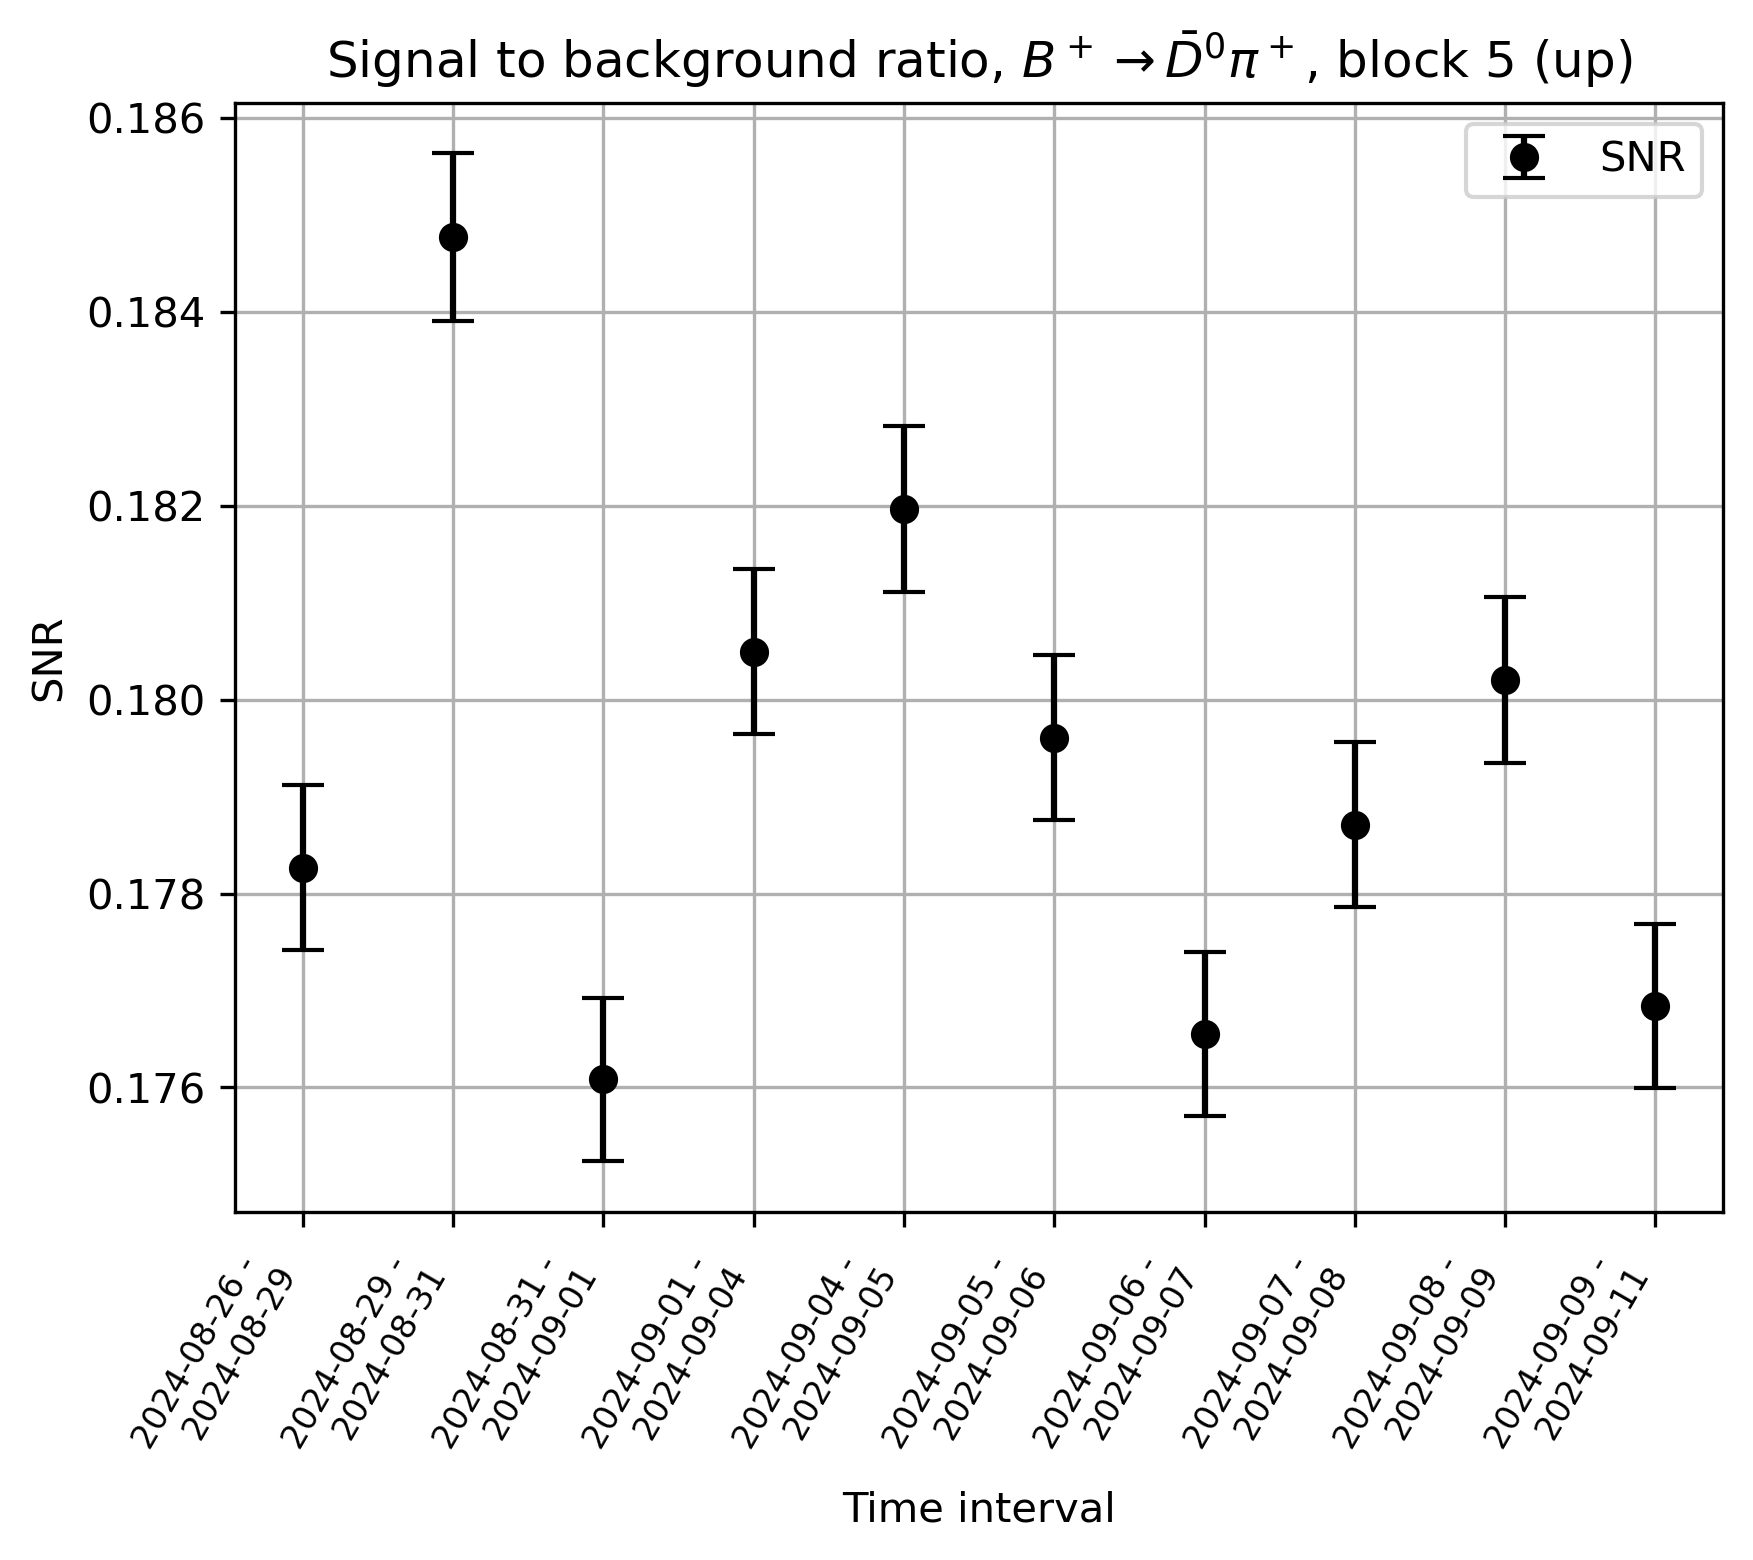

In [ ]:
plot_snr(signal_yields_dpi_up_b5,
         background_yields_dpi_up_b5,
         time_bins_up_b5,
         "dpi",
         5,
         "up",
         print_values=False)

#### Block 6 (down)

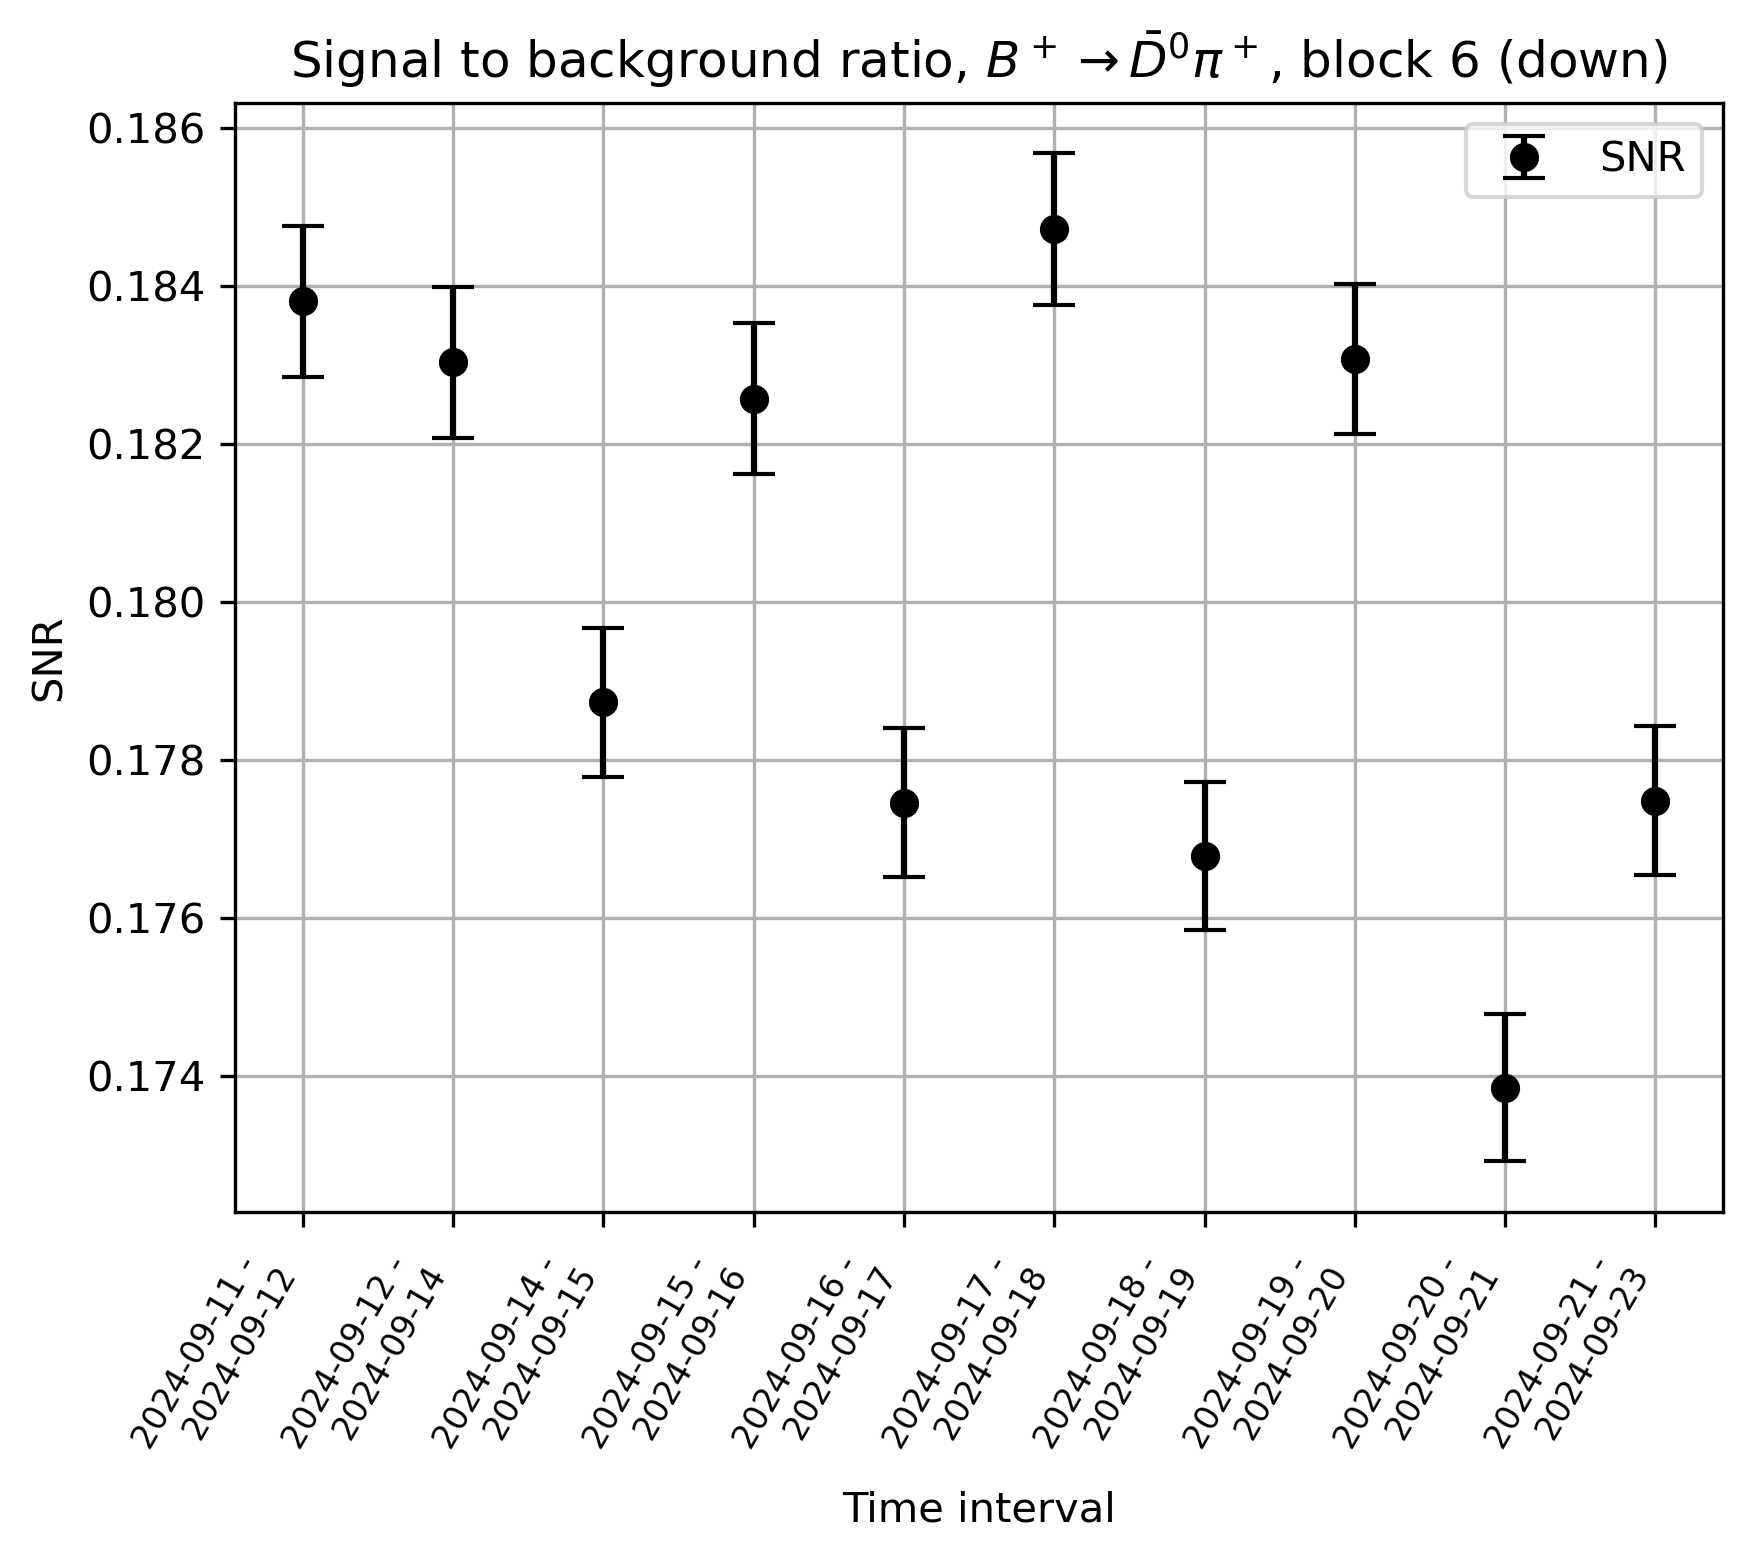

In [ ]:
plot_snr(signal_yields_dpi_down_b6, background_yields_dpi_down_b6, time_bins_down_b6, "dpi", 6, "down", print_values=False)

#### Block 7 (down)

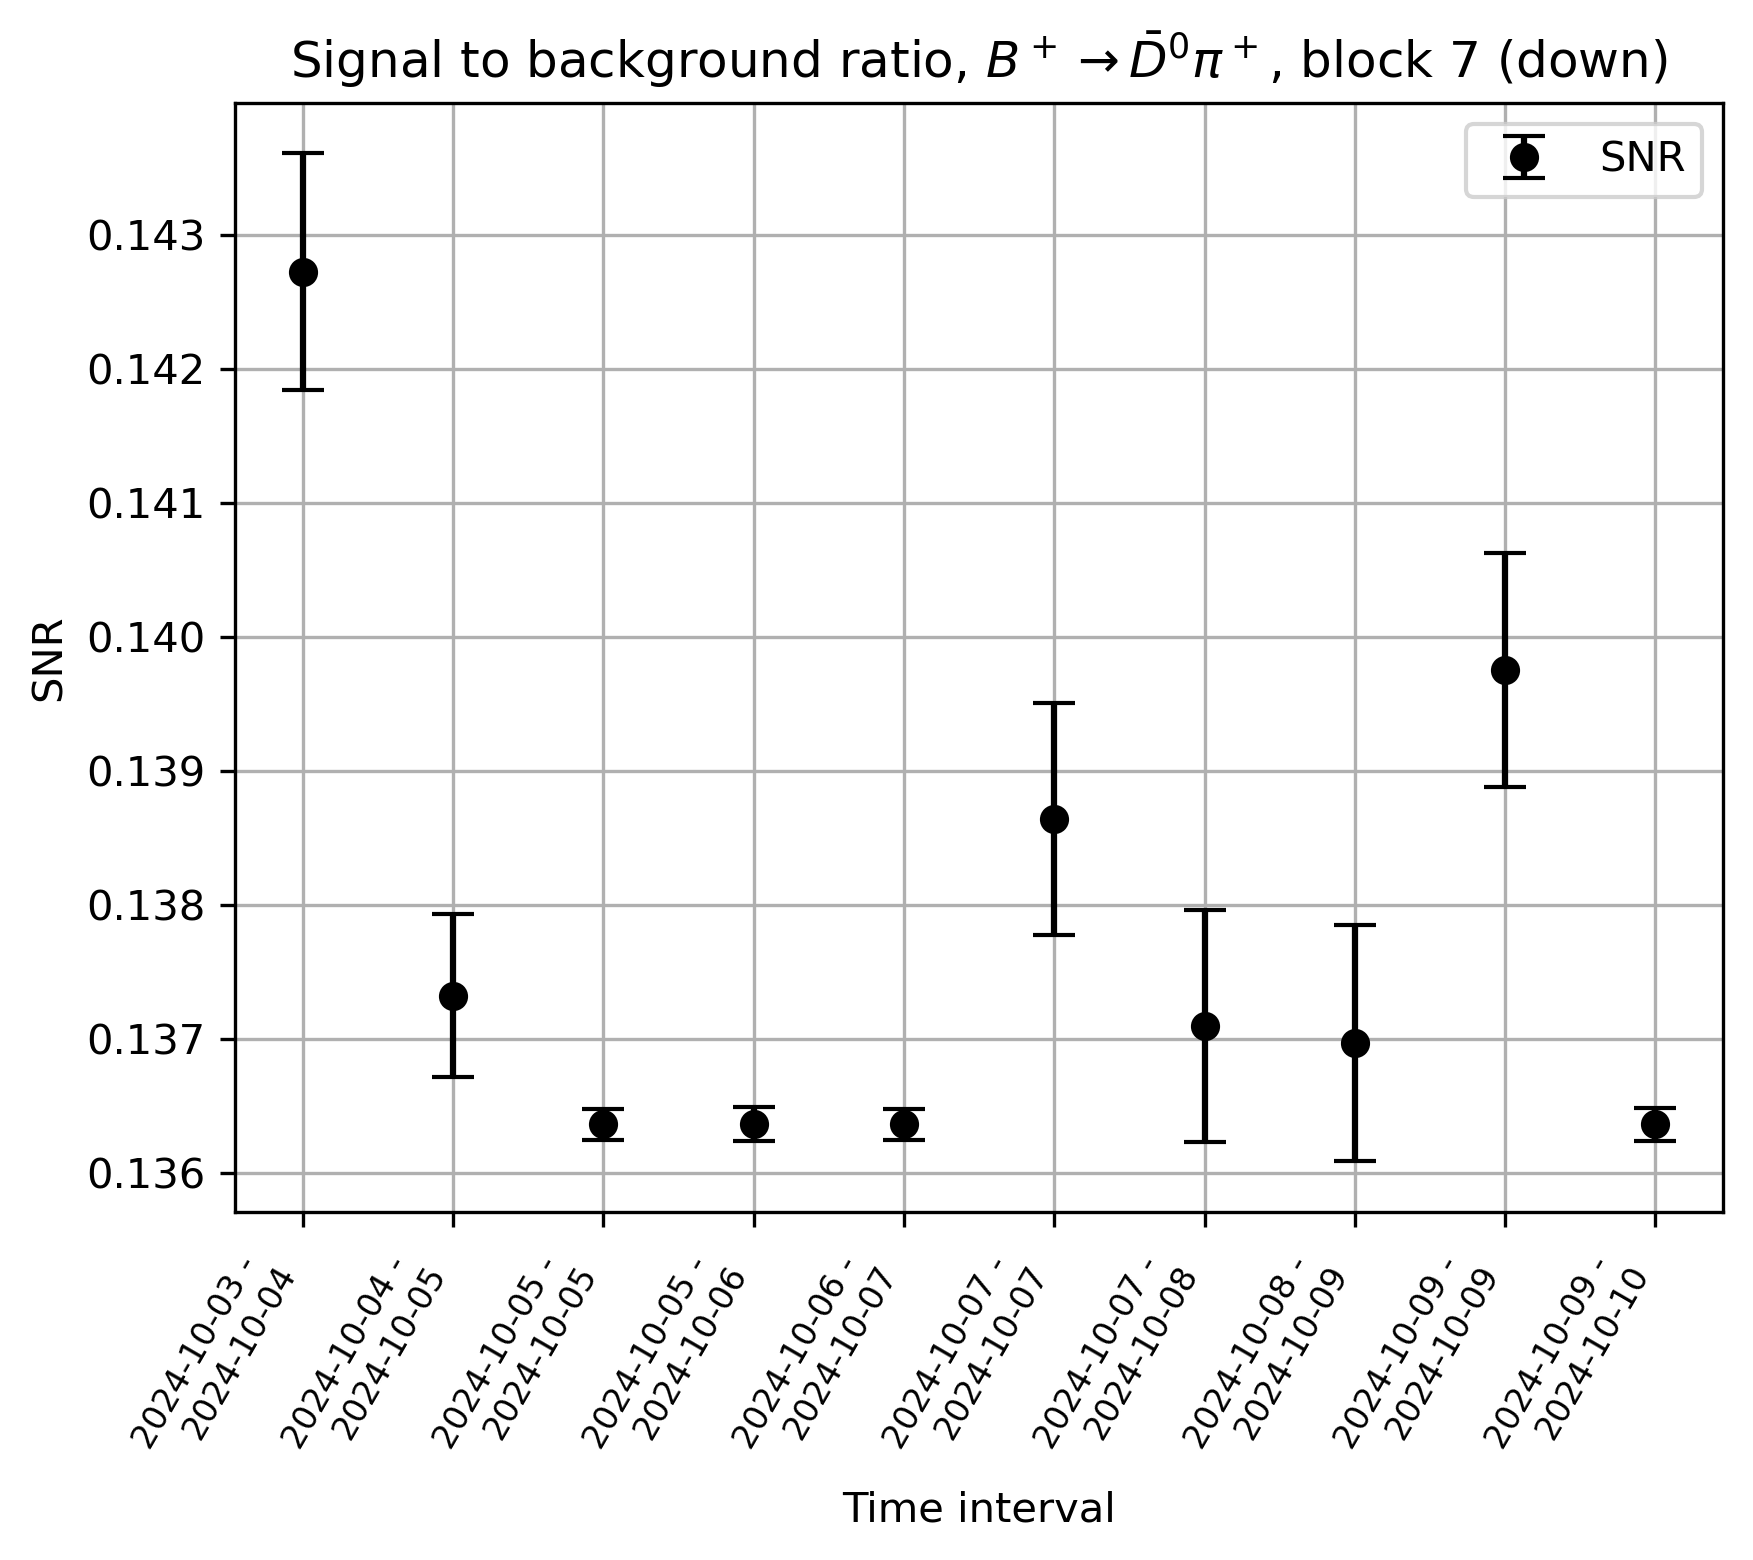

In [ ]:
plot_snr(signal_yields_dpi_down_b7, background_yields_dpi_down_b7, time_bins_down_b7, "dpi", 7, "down", print_values=False)

#### Block 8 (up)

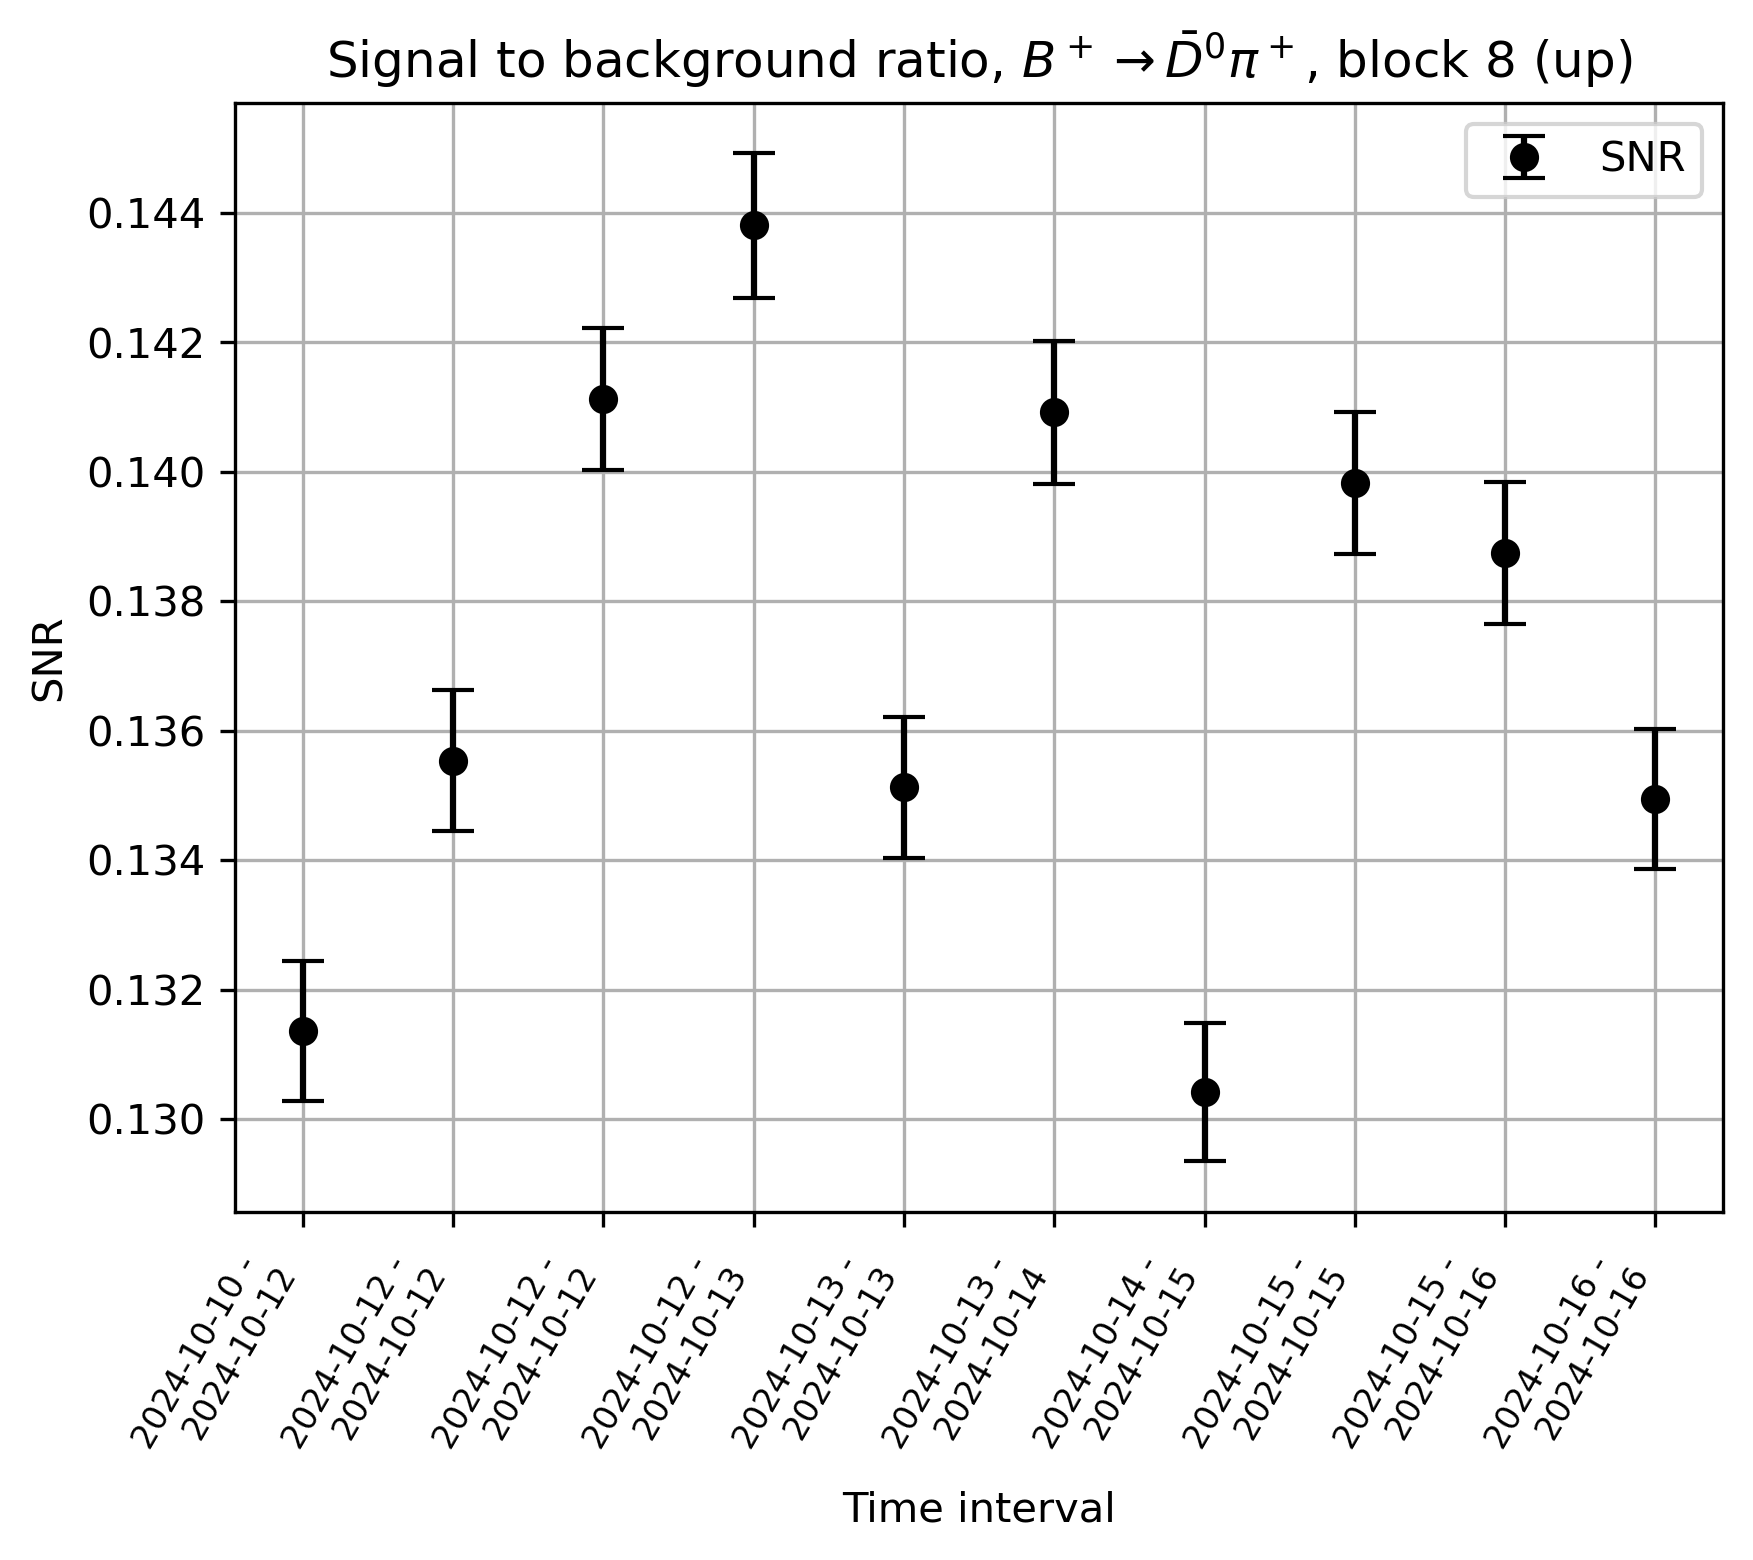

In [ ]:
plot_snr(signal_yields_dpi_up_b8, background_yields_dpi_up_b8, time_bins_up_b8, "dpi", 8, "up", print_values=False)

### $B^+ \rightarrow J/\psi K^+$

#### Block 5 (up)

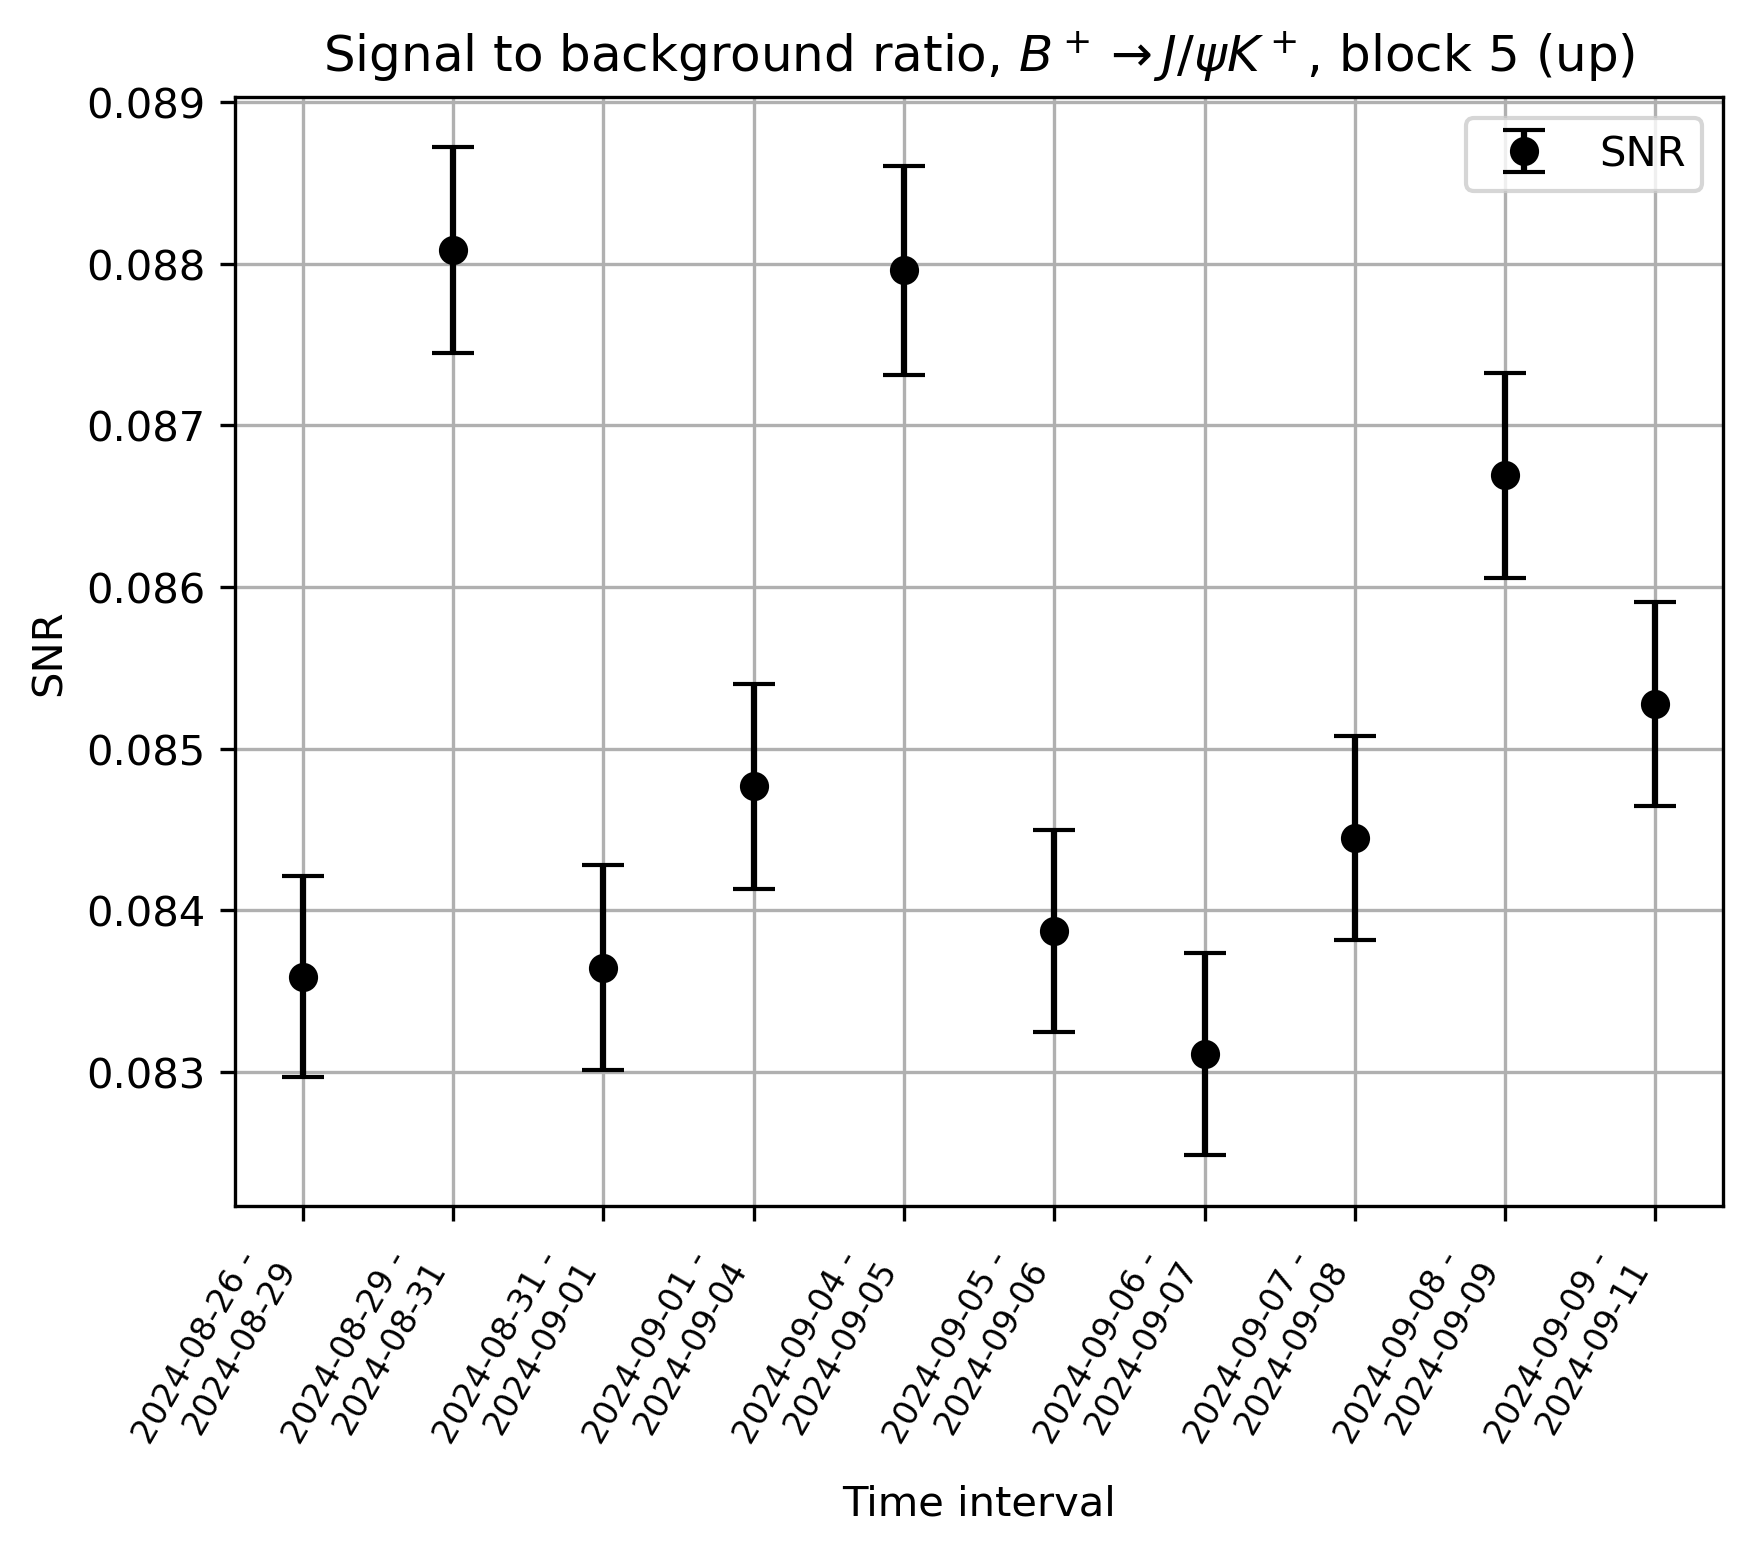

In [ ]:
plot_snr(signal_yields_jpsik_up_b5, background_yields_jpsik_up_b5, time_bins_up_b5, "jpsik", 5, "up", print_values=False)

#### Block 6 (down)

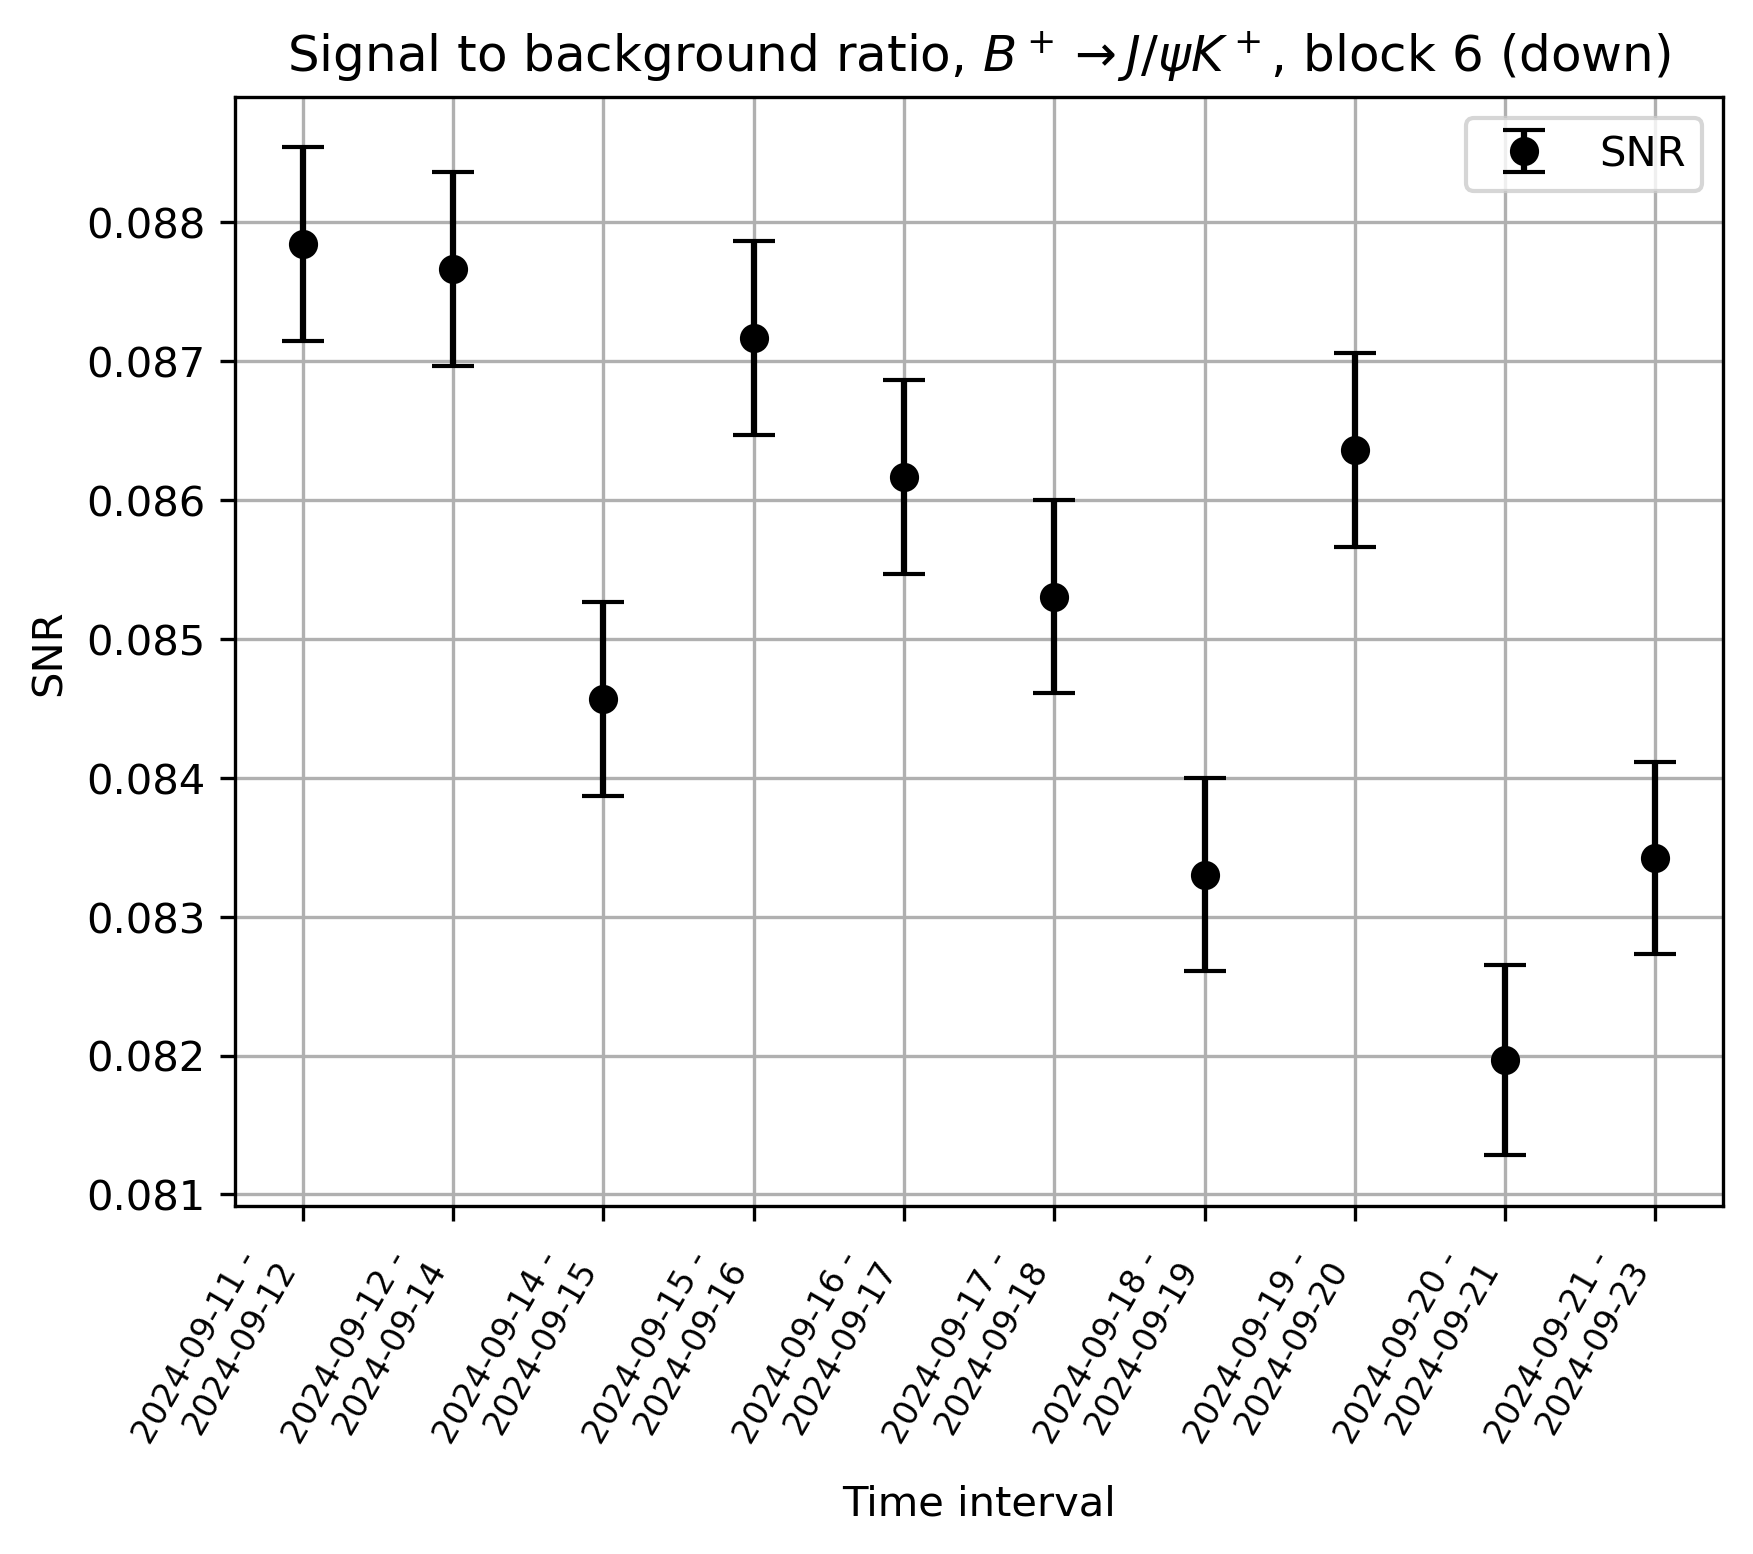

In [ ]:
plot_snr(signal_yields_jpsik_down_b6, background_yields_jpsik_down_b6, time_bins_down_b6, "jpsik", 6, "down", print_values=False)

#### Block 7 (down)

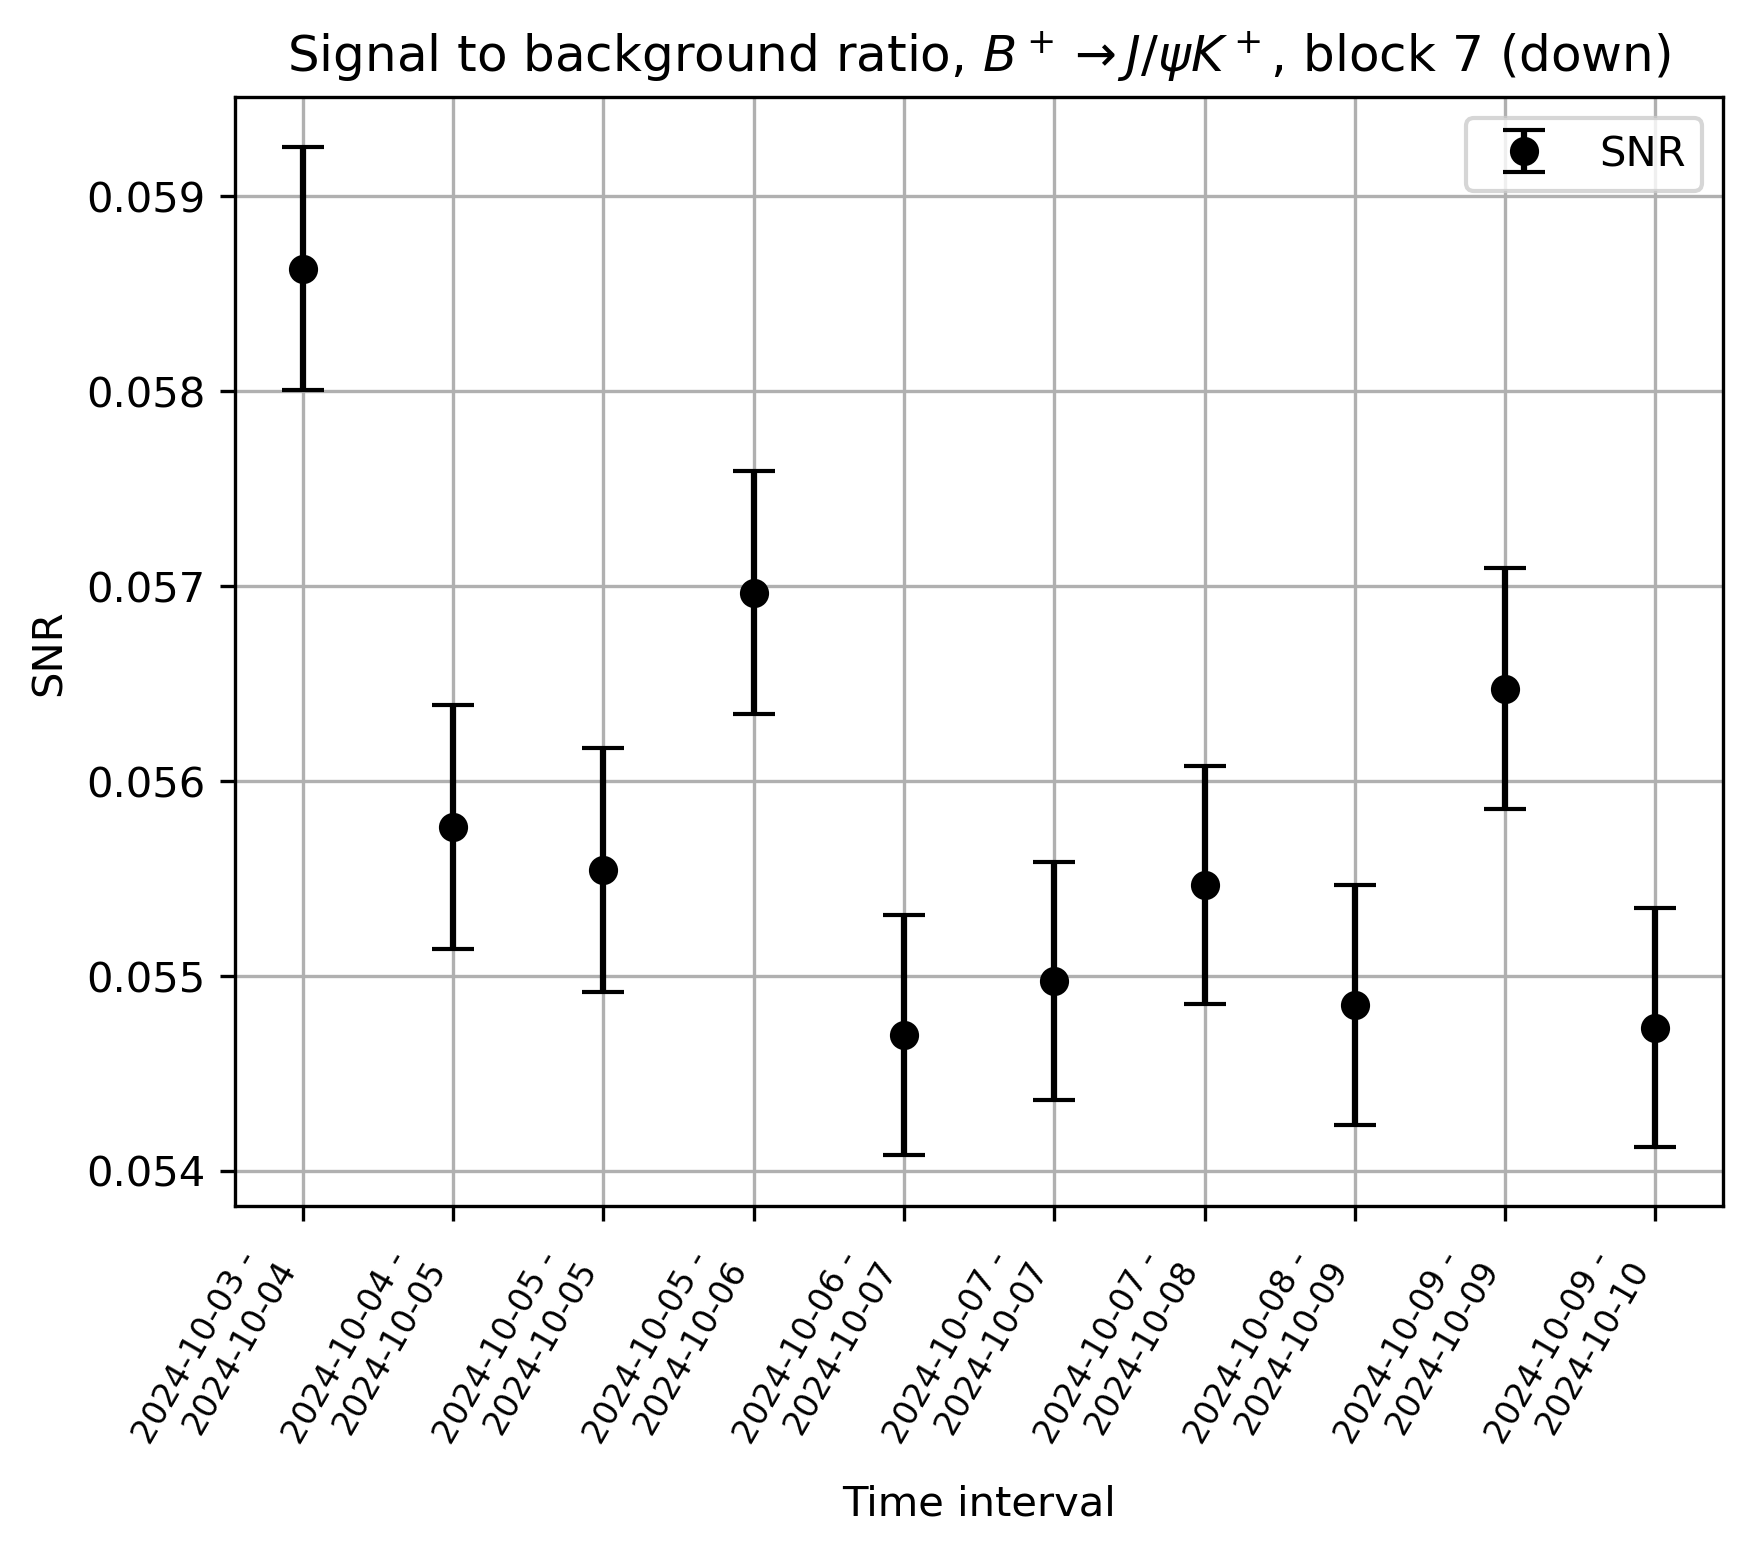

In [ ]:
plot_snr(signal_yields_jpsik_down_b7, background_yields_jpsik_down_b7, time_bins_down_b7, "jpsik", 7, "down", print_values=False)

#### Block 8 (up)

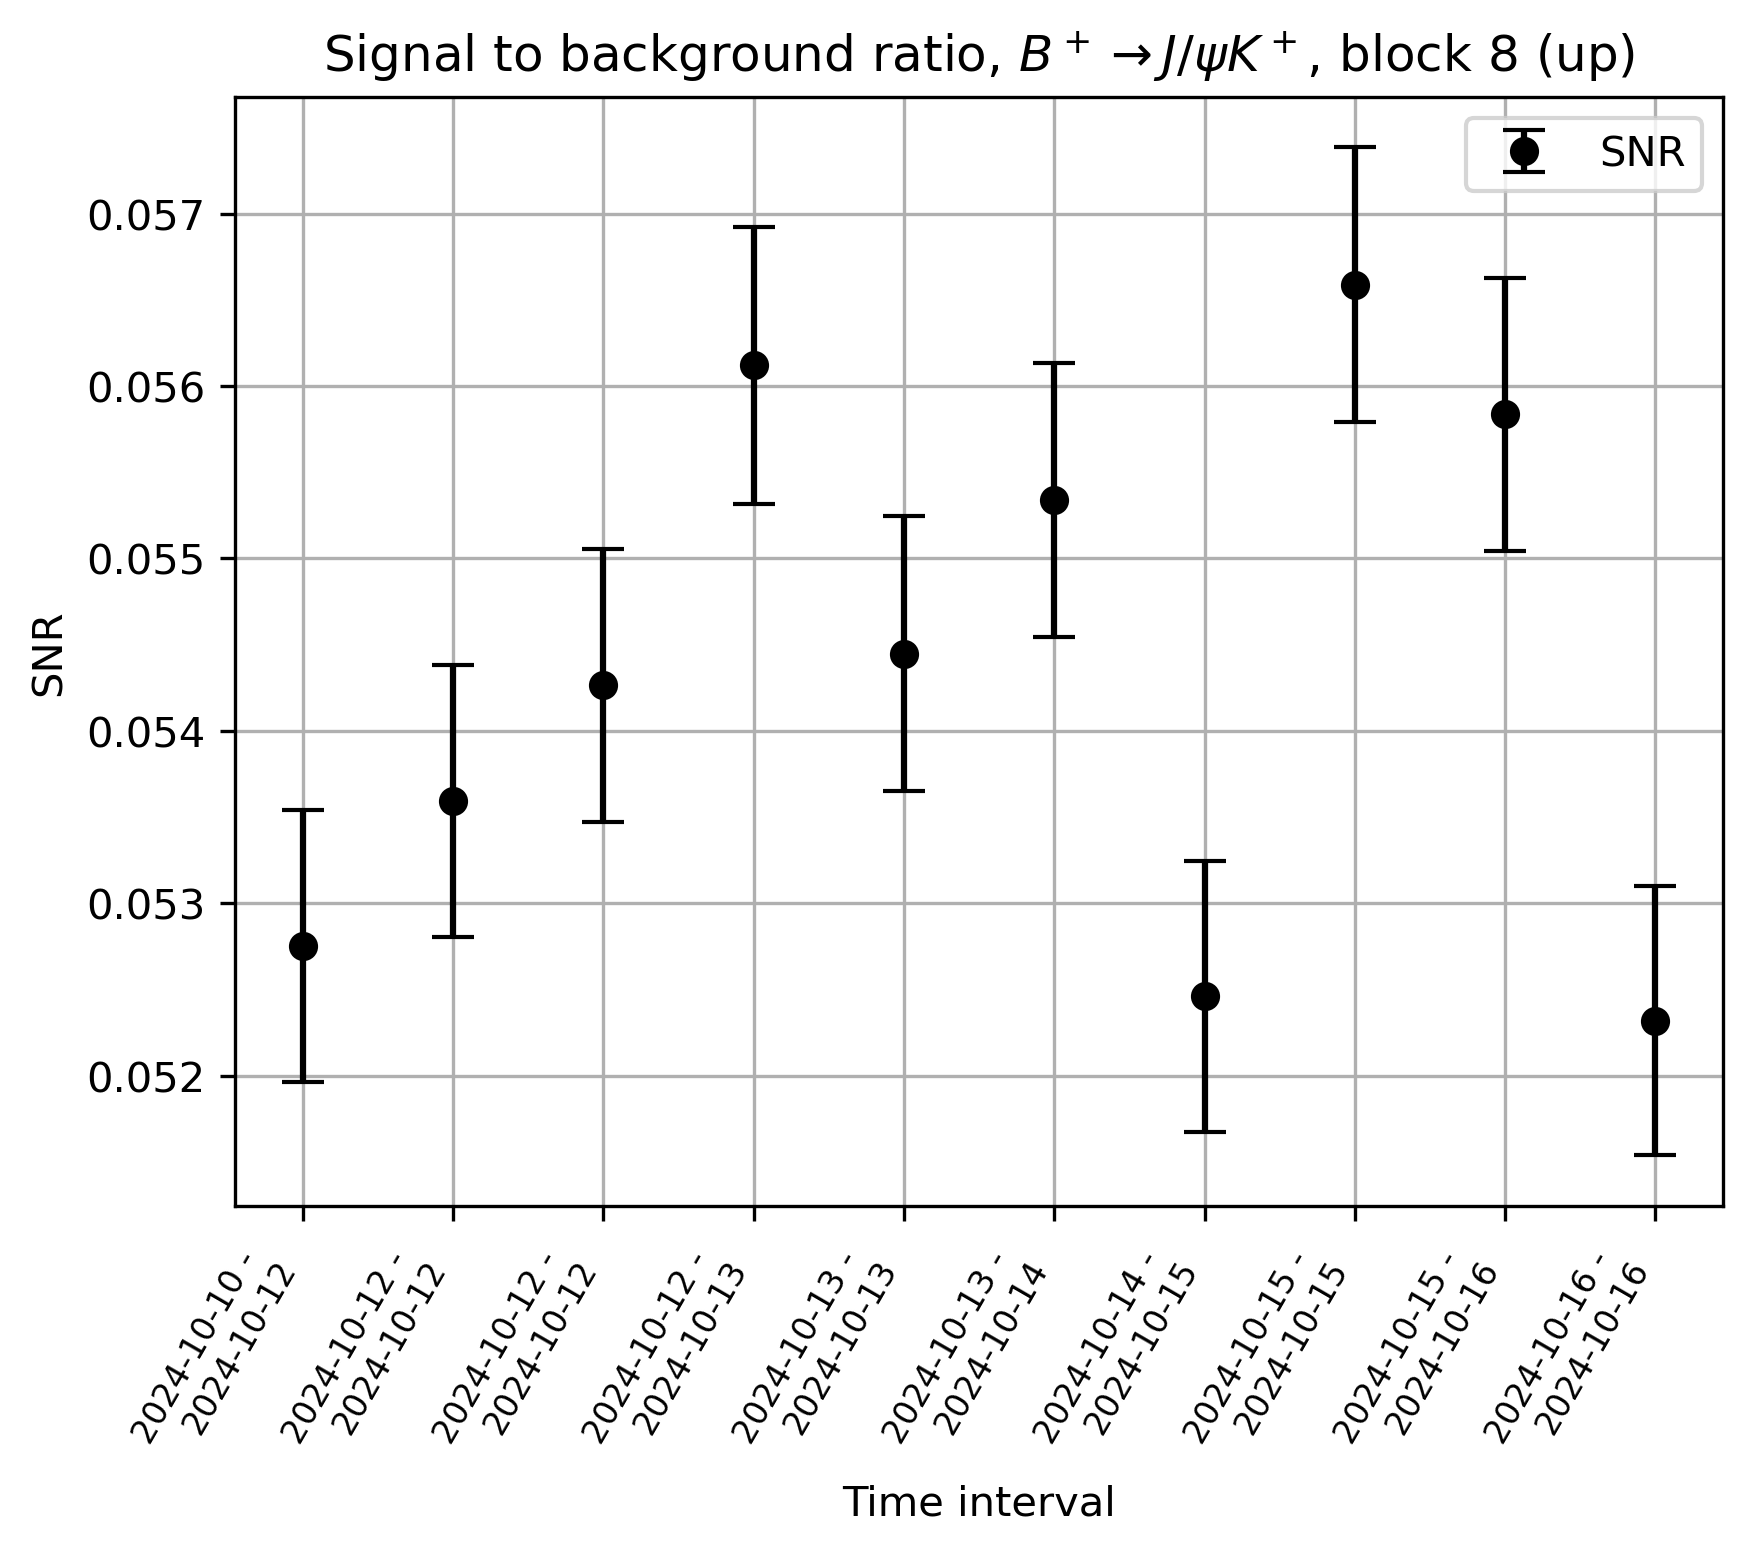

In [ ]:
plot_snr(signal_yields_jpsik_up_b8, background_yields_jpsik_up_b8, time_bins_up_b8, "jpsik", 8, "up", print_values=False)